# Telegram Mining

**Master-Thesis: Social Media & Text Mining am Beispiel von Telegram**

Informatik Master

Maximilian Bundscherer

## Arbeitsumgebung initialisieren

### Jupyter Notebook Parameter

Siehe Beschreibung in ``Thesis.pdf``

In [1]:
C_LOCAL                 = False

C_SHORT_RUN             = False
C_NUMBER_SAMPLES        = 500

C_RESOLVE_NEW_URLS      = False

"""
Ava:    ["dataSet0", "dataSet1", "dataSet1a", "dataSet2"]
Htdocs: ["dataSet0", "dataSet1a", "dataSet2"]
Req:    ["dataSet0"]
"""
C_LOAD_DATASETS         = ["dataSet0", "dataSet1", "dataSet1a", "dataSet2"]

C_LOAD_TRANSFORMERS         = False
C_TRANSFORMERS_DATASETS     = ["dataSet0"]

C_TIME_PLOT_FREQ        = "6M"

"""
Please set only one value!
e.g.
# - long-run-server-28-01.pkl   (Long run, with hf, with htdocs-datasets, updated with sen-pipe-2)
# - long-run-server-07-02.pkl   (Long run, with hf, with all datasets, updated with sen-pipe-2)
# - local-run-28-01.pkl         (Short run, with hf, with htdocs-datasets, updated with sen-pipe-2)
# - test.pkl                    (Test file)
"""
C_USE_CACHE_FILE        = "final-run-24-03.pkl"
C_NEW_CACHE_FILE        = ""

### Arbeitsumgebung vorbereiten

#### Bibliotheken und Abhängigkeiten laden

##### Abhänigkeiten vom Docker-Image und IO-Libs und weitere

In [2]:
# Import default libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
import os
import sys
import demjson
import requests
import networkx as nx
import warnings
from pprint import pprint
from urllib.parse import urlparse
from collections import Counter
from pathlib import Path
from lxml.html import fromstring

##### Weitere Abhänigkeiten installieren

In [3]:
!{sys.executable} -m pip install demoji
!{sys.executable} -m pip install HanTa
!{sys.executable} -m pip install textblob-de

##### Weitere Abhängigkeiten importieren

In [4]:
import demoji

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

#import pyLDAvis.gensim
import pickle 
import pyLDAvis
import pyLDAvis.gensim_models

import nltk
from nltk.util import ngrams

from wordcloud import WordCloud

import torch

from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

from HanTa import HanoverTagger as ht

from textblob_de import TextBlobDE as TextBlob

/opt/conda/lib/python3.8/site-packages/packaging/version.py:127: DeprecationWarning: Creating a LegacyVersion has been deprecated and will be removed in the next major release
  warnings.warn(


In [5]:
# Init hanoverTagger (https://github.com/wartaal/HanTa/blob/master/Demo.ipynb)
hanoverTagger = ht.HanoverTagger('morphmodel_ger.pgz')

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# DeprecationWarnings ausblenden
warnings.filterwarnings("ignore", category=DeprecationWarning)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Stoppuhr bereitstellen

In [7]:
dictGloStopwatches = dict()

# Start timer (for reporting)
def gloStartStopwatch(key):
    print("[Stopwatch started >>" + str(key) + "<<]")
    dictGloStopwatches[key] = time.time()

# Stop timer (for reporting)
def gloStopStopwatch(key):
    endTime     = time.time()
    startTime   = dictGloStopwatches[key]
    print("[Stopwatch stopped >>" + str(key) + "<< (" + '{:5.3f}s'.format(endTime-startTime) + ")]")

#### Modelle und Datenbanken bereitstellen

##### Transfomers

In [8]:
dictPipelines = {}

def loadPipelines():

    if(C_LOAD_TRANSFORMERS == False):
        print("Skip loading pipelines")
        return list()

    gloStartStopwatch("Load Pipelines")
    
    gloStartStopwatch("Load ner-xlm-Roberta")
    dictPipelines["ner-xlm-roberta"] = pipeline(
        'ner', 
        model='xlm-roberta-large-finetuned-conll03-german',
        tokenizer='xlm-roberta-large-finetuned-conll03-german'
    )
    gloStopStopwatch("Load ner-xlm-Roberta")

    gloStartStopwatch("Load ner-Bert")
    dictPipelines["ner-bert"] = pipeline(
        'ner', 
        model='fhswf/bert_de_ner',
        tokenizer='fhswf/bert_de_ner'
    )
    gloStopStopwatch("Load ner-Bert")

    gloStartStopwatch("Load sen-Bert")
    dictPipelines["sen-bert"] = pipeline(
        'sentiment-analysis', 
        model='nlptown/bert-base-multilingual-uncased-sentiment',
        tokenizer='nlptown/bert-base-multilingual-uncased-sentiment'
    )
    gloStopStopwatch("Load sen-Bert")

    gloStartStopwatch("Load text-gen-gpt2")
    dictPipelines["text-gen-gpt2"] = pipeline(
        'text-generation', 
        model='dbmdz/german-gpt2',
        tokenizer='dbmdz/german-gpt2'
    )
    gloStopStopwatch("Load text-gen-gpt2")

    gloStartStopwatch("Load text-gen-gpt2-faust")
    dictPipelines["text-gen-gpt2-faust"] = pipeline(
        'text-generation', 
        model='dbmdz/german-gpt2-faust',
        tokenizer='dbmdz/german-gpt2-faust'
    )
    gloStopStopwatch("Load text-gen-gpt2-faust")

    gloStopStopwatch("Load Pipelines")

    return dictPipelines.keys()

pipelineKeys = loadPipelines()
print()
print(str(pipelineKeys))

Skip loading pipelines

[]


##### NLTK

In [9]:
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

##### Bereitstellen von Stop Words Datenbanken

In [10]:
def gloGetStopWordsList(filterList):

    stopwWorldsList = []

    deWordsList = nltk.corpus.stopwords.words('german')

    enWordsList = nltk.corpus.stopwords.words('english')

    aStopwords = []
    with open(dir_var + "additionalStopwords.txt") as file:
        for line in file: 
            line = line.strip()
            if(line != ""):
                aStopwords.append(line)

    for s in filterList:
        s = gloReplaceGermanChars(s)
        stopwWorldsList.append(s)

    for s in deWordsList:
        s = gloReplaceGermanChars(s)
        stopwWorldsList.append(s)

    for s in enWordsList:
        stopwWorldsList.append(s)

    for s in aStopwords:
        s = gloReplaceGermanChars(s)
        stopwWorldsList.append(s)

    return stopwWorldsList

##### Demoji

In [11]:
demoji.download_codes()

... OK (Got response in 0.47 seconds)
Writing emoji data to /home/jovyan/.demoji/codes.json ...
... OK


#### Konfigurationen auf Umgebung anwenden

##### Umgebungs Einstellungen anwenden

In [12]:
# Set tokenizer parallelism 
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# matplotlib output
%matplotlib inline

# Show all columns (pandas hides columns by default)
pd.set_option('display.max_columns', None)

# Set plot style
plt.style.use('ggplot')

font = {'size'   : 13}

plt.rc('font', **font)

##### Arbeitsverzeichnis definieren

In [13]:
# Set env vars
if(C_LOCAL == True):
    dir_var = "./work/notebooks/"
else:
    dir_var = "./"

dir_var_output = dir_var + "output/"

dir_var_cache= dir_var + "cache/"

dir_var_pandas_cache = dir_var + "cache/pandas/"

# Debug output
! echo "- Workdir -"
! ls -al $dir_var

! echo
! echo "- Outputdir -"
! ls -al $dir_var_output

! echo
! echo "- Cachedir -"
! ls -al $dir_var_cache

! echo
! echo "- Pandas -"
! ls -al $dir_var_pandas_cache

- Workdir -
total 280
drwxr-xr-x 15 jovyan users    480 Mar 27 17:15 .
drwxr-xr-x 10 root   root     320 Feb 11 08:50 ..
-rw-r--r--  1 jovyan users     46 Jan 12 12:10 additionalStopwords.txt
drwxr-xr-x 12 jovyan users    384 Mar 24 15:54 cache
-rw-r--r--  1 jovyan users  37018 Mar 27 16:59 Classifier.ipynb
-rwxr-xr-x  1 jovyan users    285 Jan 24 13:16 clean-notebook.sh
drwxr-xr-x  8 jovyan users    256 Jan 13 09:30 data
-rw-r--r--  1 jovyan users   6148 Dec 22 16:15 .DS_Store
drwxr-xr-x  2 jovyan users     64 Feb  5 09:12 .empty
-rw-r--r--  1 jovyan users  39822 Jan 24 15:22 HuggingFace.ipynb
-rw-r--r--  1 jovyan users  12524 Mar 23 17:08 inputFiles.csv
drwxr-xr-x  4 jovyan users    128 Mar  9 14:45 .ipynb_checkpoints
drwxr-xr-x  6 jovyan users    192 Mar 27 17:15 output
-rwxr-xr-x  1 jovyan users    456 Mar 27 13:48 run-notebook.sh
-rwxr-xr-x  1 jovyan users 163928 Mar 27 17:15 Telegram.ipynb

- Outputdir -
total 8
drwxr-xr-x  6 jovyan users  192 Mar 27 17:15 .
drwxr-xr-x 15 jovyan 

##### Cache für dynamisches Auflößen initalisieren

Cache-IO Funktionen

- toFile
- fromFile
- initFile

In [14]:
# Dict File Cache
dictFileCache = {}

# Write dict to file (CSV)
def gloWriteDictToFile(filename, targetDict):
    dictFileCache = {} #Clear cache
    d = pd.DataFrame.from_dict(targetDict, orient="index")
    d.to_csv(dir_var_cache + filename, header=False)

# Read dict from file (CSV)
def gloReadDictFromFile(filename):
    # Cache?
    if(filename in dictFileCache):
        return dictFileCache[filename]

    d = pd.read_csv(dir_var_cache + filename, header=None, index_col=0, squeeze=True)
    retDict = d.to_dict()

    dictFileCache[filename] = retDict #Add to cache

    return retDict

# Init csv file if not exists
def gloInitFileDict(filename):
    f = Path(dir_var_cache + filename)
    if(f.exists() == False):
        print("Init cache file >>" + filename + "<<")
        f.touch()
        gloWriteDictToFile(filename, {"initKey": "initValue"})
    else:
        print("Cache already exists >>" + filename + "<<")

Cache Funktionen

- checkIsCached
- addToCache
- getFromCache

In [15]:
# Check if is already cached
def gloCheckIsAlreadyCached(filename, targetKey):
    targetDict = gloReadDictFromFile(filename)
    if(targetKey in targetDict.keys()):
        return True
    else:
        return False

# Add key to cache
def gloAddToCache(filename, targetKey, targetValue):
    targetDict = gloReadDictFromFile(filename)
    targetDict[targetKey] = targetValue
    gloWriteDictToFile(filename, targetDict)

# Get key from cache
def gloGetCached(filename, targetKey):
    targetDict = gloReadDictFromFile(filename)
    return targetDict[targetKey]

Cache-IO init

In [16]:
gloInitFileDict("resolved-urls.csv")
gloInitFileDict("resolved-youtube.csv")

Cache already exists >>resolved-urls.csv<<
Cache already exists >>resolved-youtube.csv<<


## Chats laden und aufbereiten

### Aufbereitungsfunktionen für die deutsche Sprache

#### Deutsch-spezifische Buchstaben aus einem String ersetzten

In [17]:
def gloReplaceGermanChars(inputText):

    inputText = inputText.replace("ö", "oe")
    inputText = inputText.replace("ü", "ue")
    inputText = inputText.replace("ä", "ae")

    inputText = inputText.replace("Ö", "Oe")
    inputText = inputText.replace("Ü", "Ue")
    inputText = inputText.replace("Ä", "Ae")

    inputText = inputText.replace("ß", "ss")
    
    return inputText

gloReplaceGermanChars("ö ä ü Ö Ä Ü")

'oe ae ue Oe Ae Ue'

#### Tokenization über NLTK

NLTK German Token

In [18]:
def getTokenFromText(inputText):
    return nltk.word_tokenize(inputText, language="german")

list(getTokenFromText("Hallo Leser! Das ist ein Test."))

['Hallo', 'Leser', '!', 'Das', 'ist', 'ein', 'Test', '.']

#### Lemmatization & POS-Tagging über HanTa

POS Versuch mit NLTK Englisch

1. NLTK German Token
2. Englische Sprache (NLTK)

In [19]:
sampleText = "Sie lesen gerade einen kurzen Beispielsatz!"
sampleText

'Sie lesen gerade einen kurzen Beispielsatz!'

In [20]:
nltk.pos_tag(getTokenFromText(sampleText))

[('Sie', 'NNP'),
 ('lesen', 'PRP'),
 ('gerade', 'VBD'),
 ('einen', 'JJ'),
 ('kurzen', 'JJ'),
 ('Beispielsatz', 'NN'),
 ('!', '.')]

HanTa

In [21]:
def getLemmaAndTaggingFromText(inputText):
    return hanoverTagger.tag_sent(getTokenFromText(inputText))

getLemmaAndTaggingFromText(sampleText)

[('Sie', 'sie', 'PPER'),
 ('lesen', 'lesen', 'VVFIN'),
 ('gerade', 'gerade', 'ADV'),
 ('einen', 'einen', 'ART'),
 ('kurzen', 'kurz', 'ADJA'),
 ('Beispielsatz', 'Beispielsatz', 'NN'),
 ('!', '--', '$.')]

### Stufe 1: Chats laden

#### CSV Einlesen

In [22]:
def readDataFrameFromCSV(filePath):
    return pd.read_csv(dir_var + filePath, sep=";")

dfInputFiles = readDataFrameFromCSV("inputFiles.csv")

#### Filtern uns ausgeben

In [23]:
def filterBaseData(df):
    dfFilter = pd.DataFrame()

    for dS in C_LOAD_DATASETS:
        dfFilter = dfFilter.append(df[df.inputLabel == dS])
        
    return dfFilter

dfInputFiles = filterBaseData(dfInputFiles)

dfInputFiles

inputName  \
47                                     ATTILA HILDMANN   
48                           Oliver Janich oeffentlich   
49                                Eva Herman Offiziell   
50                         Xavier Naidoo (inoffiziell)   
51                    Gerechtigkeit fuer das Vaterland   
..                                                 ...   
103                  Querdenken 773 Hegau - Info Kanal   
104  Querdenken 711 Stuttgart - Diskussion u. Austa...   
105              Querdenken 711 Stuttgart - Info Kanal   
106  Querdenken 69 Frankfurt - Diskussion u. Austausch   
107               Querdenken 69 Frankfurt - Info Kanal   

                                             inputPath          inputType  \
47        DS-05-01-2021/ChatExport_2021-01-05-hildmann     public_channel   
48          DS-05-01-2021/ChatExport_2021-01-05-janich     public_channel   
49       DS-05-01-2021/ChatExport_2021-01-05-evaherman     public_channel   
50          DS-05-01-2021/ChatExport_2021-01-05-xavier     public_channel   
51   DS-05-01-2021a/ChatExport_2021-01-05-gerechtig...     public_channel   
..                                                 ...                ...   
103  DS-13-01-2021/ChatExport_2021-01-13-querdenken...     public_channel   
104  DS-13-01-2021/ChatExport_2021-01-13-querdenken711  public_supergroup   
105  DS-13-01-2021/ChatExport_2021-01-13-querdenken...     public_channel   
106   DS-13-01-2021/ChatExport_2021-01-13-querdenken69  public_supergroup   
107  DS-13-01-2021/ChatExport_2021-01-13-querdenken...     public_channel   

         inputId inputLabel inputDownloadType  
47   10034163583   dataSet0          onlyText  
48    9808932799   dataSet0          onlyText  
49    9915108907   dataSet0          onlyText  
50    9874390332   dataSet0          onlyText  
51   10069007089   dataSet1          onlyText  
..           ...        ...               ...  
103   9885532851   dataSet2          onlyText  
104   9812812343   dataSet2          onlyText  
105   9818761759   dataSet2          onlyText  
106   9906959218   dataSet2          onlyText  
107   9991668824   dataSet2          onlyText  

[61 rows x 6 columns]

### Stufe 2: Chats aufbereiten

In [24]:
# Convert to DataFrame Meta (Chat Meta)
def convertToDataFrameMeta(filePath):
    dF = pd.read_json(dir_var + "data/" + filePath + "/result.json", encoding='utf-8')
    return dF

dictMeta          = {}   

# Add Key = filePath / Value = DataFrame (Chat Meta)
for fP in dfInputFiles.inputPath:
    dictMeta[fP] = convertToDataFrameMeta(fP)

In [25]:
list(dictMeta.keys())

['DS-05-01-2021/ChatExport_2021-01-05-hildmann',
 'DS-05-01-2021/ChatExport_2021-01-05-janich',
 'DS-05-01-2021/ChatExport_2021-01-05-evaherman',
 'DS-05-01-2021/ChatExport_2021-01-05-xavier',
 'DS-05-01-2021a/ChatExport_2021-01-05-gerechtigkeitVaterland',
 'DS-05-01-2021a/ChatExport_2021-01-05-aktuelleKarikaturen',
 'DS-05-01-2021a/ChatExport_2021-01-05-drHeinrichFiechtnerInfo',
 'DS-05-01-2021a/ChatExport_2021-01-05-michaelWendler',
 'DS-05-01-2021a/ChatExport_2021-01-05-laserLurch',
 'DS-05-01-2021a/ChatExport_2021-01-05-dawidSnowden',
 'DS-05-01-2021a/ChatExport_2021-01-05-kenJebsen',
 'DS-05-01-2021a/ChatExport_2021-01-05-nachrichtenWelt',
 'DS-05-01-2021a/ChatExport_2021-01-05-qAnonAussteiger',
 'DS-05-01-2021a/ChatExport_2021-01-05-whatTheyHide',
 'DS-05-01-2021a/ChatExport_2021-01-05-kulturStudio',
 'DS-05-01-2021a/ChatExport_2021-01-05-jouwatch',
 'DS-05-01-2021a/ChatExport_2021-01-05-derWaldgang',
 'DS-05-01-2021a/ChatExport_2021-01-05-einzelfallInfos',
 'DS-05-01-2021a/ChatE

In [26]:
list(dictMeta["DS-05-01-2021/ChatExport_2021-01-05-hildmann"].keys())

['name', 'type', 'id', 'messages']

### Stufe 3: Nachrichten aufbereiten

#### Stufe 3a: Nachrichten parsen

##### Nachrichten parsen

In [27]:
# Convert to DataFrame Messages (Chat Messages)
def convertToDataFrameMessages(filePath):
    dF = pd.json_normalize(dictMeta[filePath].messages)
    return dF

##### Auf Stichprobe reduzieren (optional)

Siehe Beschreibung in ``Thesis.pdf``

##### Nachrichten Attribute kennenlernen

In [28]:
convertToDataFrameMessages("DS-05-01-2021/ChatExport_2021-01-05-hildmann").columns

Index(['id', 'type', 'date', 'actor', 'actor_id', 'action', 'title', 'text',
       'from', 'from_id', 'file', 'media_type', 'mime_type',
       'duration_seconds', 'edited', 'thumbnail', 'width', 'height', 'photo',
       'forwarded_from', 'poll.question', 'poll.closed', 'poll.total_voters',
       'poll.answers', 'sticker_emoji', 'message_id', 'reply_to_message_id',
       'location_information.latitude', 'location_information.longitude',
       'live_location_period_seconds', 'via_bot', 'performer'],
      dtype='object')

##### Chat Attribute zuweisen

Siehe Beschreibung in ``Thesis.pdf``

##### Formatierte Nachrichten erkennen

Siehe Beschreibung in ``Thesis.pdf``

In [29]:
def gloCheckIsTextJsonFormatted(text, singleMode):
    textString = str(text)
    if      (singleMode == False and textString.startswith("[") == True and textString.endswith("]") == True):
        return True
    elif    (singleMode == True and textString.startswith("{") == True and textString.endswith("}") == True):
        return True
    else:
        return False

#### Stufe 3b: Text und Meta Informationen extrahieren

##### Text und Meta Informationen extrahieren

In [30]:
"""
Extract text data (see cell above key)
See cell above (key)

param   ftIsJsonFormatted Boolean (is text json formatted?)
param   text                String  (text from message) 

return
a   procText            Plain Text
b   processedURLs       Array of URLs in Text
c   processedHashtags   Array of Hashtags in Text #TODO: RM
d   processedBolds      Array of Bold Items in Text
e   processedItalics    Array of Italic Items in Text
f   processedUnderlines Array of Underlined Items in Text
g   processedEmails     Array of E-Mails in Text
"""
def extractTextData(ftIsJsonFormatted, text):
    
    processedURLs       = list()
    processedHashtags   = list()
    processedBolds      = list()
    processedItalics    = list()
    processedUnderlines = list()
    processedEmails     = list()
    
    if(ftIsJsonFormatted != True):
        #Is not JSON formatted (return normal text)
        return (text, processedURLs, processedHashtags, processedBolds, processedItalics, processedUnderlines, processedEmails)
    else:
        #Is is JSON formatted (try to parse)
        try:
            returnList = []
            jsonList = demjson.decode(str(text), encoding='utf8')

            # Do for each item in list
            for lItem in jsonList:

                messageString = str(lItem)

                isJsonSubString = gloCheckIsTextJsonFormatted(messageString, singleMode = True)

                if(isJsonSubString):
                    # Is Json Sub String
                    subJsonString = demjson.decode(str(messageString), encoding='utf8')
                    subJsonType = subJsonString["type"]

                    if(subJsonType == "bold"):
                        #text included
                        processedBolds.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "italic"):
                        #text included
                        processedItalics.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "underline"):
                        #text included
                        processedUnderlines.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                    
                    elif(subJsonType == "email"):
                        #text included
                        processedEmails.append(subJsonString["text"])
                        
                    elif(subJsonType == "text_link"):
                        #text and href included
                        processedURLs.append(subJsonString["href"])
                        #returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "link"):
                        #text included
                        processedURLs.append(subJsonString["text"])
                        
                    elif(subJsonType == "hashtag"):
                        #text included
                        #processedHashtags.append(subJsonString["text"]) # TODO: Refactor: Dont add hashtags here!
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "mention"):
                        #text included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "mention_name"):
                        #text and user_id included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "bot_command"):
                        #text included
                        returnList = returnList 
                        
                    elif(subJsonType == "code"):
                        #text included
                        returnList = returnList
                        
                    elif(subJsonType == "phone"):
                        #text included
                        returnList = returnList
                        
                    elif(subJsonType == "strikethrough"):
                        #text included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "pre"):
                        #text and language included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "bank_card"):
                        #text included
                        returnList = returnList
                        
                    else:
                        print("- Error: Unkown json type >>" + str(subJsonType) + "<< (ignore) >>" + str(text) + "<<")

                else:
                    # Is no json formatted sub string (append text)
                    returnList.append(messageString)

            return (''.join(returnList), processedURLs, processedHashtags, processedBolds, processedItalics, processedUnderlines, processedEmails)
        
        except:
            # Parser error (set inputText to returnText)
            print("- Warn: Json parser error (set inputText to returnText) >>" + str(text) + "<<")
            return (text, processedURLs, processedHashtags, processedBolds, processedItalics, processedUnderlines, processedEmails)

##### Text und Meta Informationen nachbearbeiten

Urls

Siehe Beschreibung in ``Thesis.pdf``

In [31]:
def getUrlRegex():
    return "((?:https?://)?(?:(?:www\.)?(?:[\da-z\.-]+)\.(?:[a-z]{2,6})|(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)|(?:(?:[0-9a-fA-F]{1,4}:){7,7}[0-9a-fA-F]{1,4}|(?:[0-9a-fA-F]{1,4}:){1,7}:|(?:[0-9a-fA-F]{1,4}:){1,6}:[0-9a-fA-F]{1,4}|(?:[0-9a-fA-F]{1,4}:){1,5}(?::[0-9a-fA-F]{1,4}){1,2}|(?:[0-9a-fA-F]{1,4}:){1,4}(?::[0-9a-fA-F]{1,4}){1,3}|(?:[0-9a-fA-F]{1,4}:){1,3}(?::[0-9a-fA-F]{1,4}){1,4}|(?:[0-9a-fA-F]{1,4}:){1,2}(?::[0-9a-fA-F]{1,4}){1,5}|[0-9a-fA-F]{1,4}:(?:(?::[0-9a-fA-F]{1,4}){1,6})|:(?:(?::[0-9a-fA-F]{1,4}){1,7}|:)|fe80:(?::[0-9a-fA-F]{0,4}){0,4}%[0-9a-zA-Z]{1,}|::(?:ffff(?::0{1,4}){0,1}:){0,1}(?:(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])|(?:[0-9a-fA-F]{1,4}:){1,4}:(?:(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])))(?::[0-9]{1,4}|[1-5][0-9]{4}|6[0-4][0-9]{3}|65[0-4][0-9]{2}|655[0-2][0-9]|6553[0-5])?(?:/[\w\.-]*)*/?)"

def urlExtractUrls(inputText):
    return re.findall(getUrlRegex(), str(inputText))

def urlRemoveUrls(inputText):
    return re.sub(getUrlRegex(), " ", str(inputText))

Hashtags

Siehe Beschreibung in ``Thesis.pdf``

In [32]:
def getHashtagRegex():
    return "#(\w+)"

def hashTagExtractHashTags(inputText):

    inputText = str(inputText)

    inputText = re.sub('\n', ' ', inputText) # Replace \n
    inputText = demoji.replace(inputText, " ") # Rm emoji
    inputText = gloReplaceGermanChars(inputText) # Replace german chars

    return re.findall(getHashtagRegex(), inputText)

In [33]:
"""
Get params from extractedTextData
See cell below (key)
"""
def getExtractedTextDataParam(key, extractedTextData):

    a,b,c,d,e,f,g = extractedTextData

    if(key == 0):

        return urlRemoveUrls(a)

    elif(key == 1):

        before = b
        extracted = urlExtractUrls(a)

        after = before
        after.extend(extracted)

        return after

    elif(key == 2):

        return hashTagExtractHashTags(a)

    else:
        switcher = {
            3: d,
            4: e,
            5: f,
            6: g
        }
        return switcher.get(key)

##### Text bereinigen und weitere Attribute berechnen

Siehe Beschreibung in ``Thesis.pdf``

#### Stufe 3c: Query Features

Siehe Beschreibung in ``Thesis.pdf``

In [34]:
def evalIsValidText(ftTdTextLength):
    if(ftTdTextLength > 3):
        return True
    else:
        return False

In [35]:
def evalContainsSomething(att):
    if(str(att) == "nan"):
        return False
    else:
        return True

In [36]:
def evalNonEmptyList(att):
    if(str(att) == "[]"):
        return False
    else:
        return True

#### Stufe 3d: Fortgeschrittene Text Mining Modelle

##### Transformers

Siehe Beschreibung in ``Thesis.pdf``

In [37]:
# returns dict (empty dict if disabled, dict with not entries if error)
listUnknownTypes = list()
def processNerPipeline(inputText, pipelineKey, configMinScore):
    if(pipelineKey in pipelineKeys):

        listPer     = list()
        listMisc    = list()
        listOrg     = list()
        listLoc     = list()

        try:

            data = dictPipelines[pipelineKey](inputText)

            for d in data:

                jsonData = demjson.decode(str(d), encoding='utf8')
                            
                if(jsonData["score"] >= configMinScore):
                    # Is Valid
                    if      (jsonData["entity"] == "I-PER" or jsonData["entity"] == "B-PER"):
                        listPer.append(jsonData["word"])
                    elif    (jsonData["entity"] == "I-MISC" or jsonData["entity"] == "B-MISC"):
                        listMisc.append(jsonData["word"])
                    elif    (jsonData["entity"] == "I-ORG" or jsonData["entity"] == "B-ORG"):
                        listOrg.append(jsonData["word"])
                    elif    (jsonData["entity"] == "I-LOC" or jsonData["entity"] == "B-LOC"):
                        listLoc.append(jsonData["word"])
                    else:
                        uT = str(jsonData["entity"])
                        if(uT not in listUnknownTypes):
                            print("- Warn - Got unknown type >>" + uT + "<<")
                            listUnknownTypes.append(uT)

        except:
            pass
            #print("Error in processNerPipeline (ignore) >>" + str(inputText) + "<<")
        

        return {
            "per": listPer,
            "misc": listMisc,
            "org": listOrg,
            "loc": listLoc
        }

    else:
        return dict()

In [38]:
# returns
# 1 - 5 (1 = bad / 5 = good)
# -1 disabled or error
def processSenPipeline(inputText, pipelineKey, configMinScore):
    if(pipelineKey in pipelineKeys):

        sen = -1

        try:

            data = dictPipelines[pipelineKey](inputText)
            
            for d in data:


                jsonData = demjson.decode(str(d), encoding='utf-8')

                if(jsonData["score"]) > configMinScore:
                    # Is Valid
                    labelData = str(jsonData["label"])

                    if("stars" in labelData):
                        labelData = re.sub(" stars", "", labelData)
                    else:
                        labelData = re.sub(" star", "", labelData)
                    
                    sen = int(labelData)

        except:
            pass
            #print("Error in processSenPipeline (ignore) >>" + str(inputText) + "<<")

        return sen

    else:
        return -1

##### TextBlob

Siehe Beschreibung in ``Thesis.pdf``

In [39]:
# returns
# dict (polarity, subjectivity) or none (fail or disabled)
def processSentimentAnalysisPython(inputText):

    try:
        t = TextBlob(inputText)
        return {
            "polarity": t.polarity,
            "subjectivity": t.subjectivity
        }
    except:
        return None

#### Aus dem Cache laden oder Cache erzeugen

Siehe Beschreibung in ``Thesis.pdf``

In [40]:
# return dictMessages and dfAllDataMessages
def initProcessData():

    dictMessages      = {}
    dfAllDataMessages = pd.DataFrame()

    gloStartStopwatch("Extract Text Data")

    # Add Key = filePath / Value = DataFrame (Chat Message)
    for fP in dfInputFiles.inputPath:

        gloStartStopwatch("TD-Extract " + fP)
        
        ##############################
        ########## Stufe 3a ##########
        ##############################
        
        # Nachrichten parsen
        dfMessages                          = convertToDataFrameMessages(fP)
        tmpMeta                             = convertToDataFrameMeta(fP)

        # Auf Stichprobe reduzieren (optional)
        if(C_SHORT_RUN):
            print("Short run active!")
            dfMessages = dfMessages.head(C_NUMBER_SAMPLES)
            
        # Nachrichten Attribute kennenlernen
        # siehe oben

        # Chat Attribute zuweisen (filePath, chatType)
        dfMessages["ftFilePath"]      = fP
        dfMessages["ftChatType"]      = tmpMeta.type.iloc[0]
        
        # Formatierte Nachrichten erkennen (isJsonFormatted)
        dfMessages["ftIsJsonFormatted"]   = dfMessages["text"].apply(gloCheckIsTextJsonFormatted, singleMode = False)        
        
        ##############################
        ########## Stufe 3b ##########
        ##############################
        
        # Text und Meta Informationen extrahieren
        dfMessages["tmpExtractedTD"]        = dfMessages.apply(lambda x: extractTextData(x.ftIsJsonFormatted, x.text), axis=1)

        # Text und Meta Informationen nachbearbeiten
        dfMessages["ftTdText"]            = dfMessages.apply(lambda x: getExtractedTextDataParam(0, x.tmpExtractedTD), axis=1)        
        
        dfMessages["ftTdUrls"]            = dfMessages.apply(lambda x: getExtractedTextDataParam(1, x.tmpExtractedTD), axis=1)        
        dfMessages["ftTdHashtags"]        = dfMessages.apply(lambda x: getExtractedTextDataParam(2, x.tmpExtractedTD), axis=1)
        dfMessages["ftTdBolds"]           = dfMessages.apply(lambda x: getExtractedTextDataParam(3, x.tmpExtractedTD), axis=1)
        dfMessages["ftTdItalics"]         = dfMessages.apply(lambda x: getExtractedTextDataParam(4, x.tmpExtractedTD), axis=1)
        dfMessages["ftTdUnderlines"]      = dfMessages.apply(lambda x: getExtractedTextDataParam(5, x.tmpExtractedTD), axis=1)        
        dfMessages["ftTdEmails"]          = dfMessages.apply(lambda x: getExtractedTextDataParam(6, x.tmpExtractedTD), axis=1)        

        # Text bereinigen und weitere Attribute zuweisen
        dfMessages['ftTdCleanText']           = dfMessages['ftTdText'].map(lambda x: re.sub('\n', ' ', x)) # Replace \n
        
        dfMessages['ftTdEmojis']              = dfMessages['ftTdCleanText'].map(lambda x: demoji.findall_list(x, desc = False)) # Filter out emoji
        dfMessages['ftTdEmojisDesc']          = dfMessages['ftTdCleanText'].map(lambda x: demoji.findall_list(x, desc = True)) # Filter out emoji with desc
        
        dfMessages['ftTdCleanText']           = dfMessages['ftTdCleanText'].map(lambda x: demoji.replace(x, " ")) # Rm emoji
        dfMessages['ftTdCleanText']           = dfMessages['ftTdCleanText'].map(lambda x: gloReplaceGermanChars(x)) # Replace german chars
        
        dfMessages['ftTdSafeText']            = dfMessages['ftTdCleanText'].map(lambda x: re.sub(r'[^a-zA-Z0-9\s]', ' ', x)) # Filter out . ! ? ... (get only safe chars)
        dfMessages['ftTdSafeLowerText']       = dfMessages['ftTdSafeText'].map(lambda x: x.lower()) # To lower
        
        dfMessages["ftTdTextLength"]          = dfMessages["ftTdCleanText"].str.len()

        ##############################
        ########## Stufe 3c ##########
        ##############################
        
        # Hilfsspalten einfügen (optional)
        if "photo" not in dfMessages:
            dfMessages["photo"] = np.nan

        if "file" not in dfMessages:
            dfMessages["file"] = np.nan

        if "edited" not in dfMessages:
            dfMessages["edited"] = np.nan

        if "forwarded_from" not in dfMessages:
            dfMessages["forwarded_from"] = np.nan

        # Query Attribute zuweisen
        dfMessages["ftQrIsValidText"]               = dfMessages.ftTdTextLength.apply(evalIsValidText)
        dfMessages["ftQrIsEdited"]                  = dfMessages.edited.apply(evalContainsSomething)       
        dfMessages["ftQrIsForwarded"]               = dfMessages.forwarded_from.apply(evalContainsSomething)
        
        dfMessages["ftQrCoPhotos"]                  = dfMessages.photo.apply(evalContainsSomething)        
        dfMessages["ftQrCoFiles"]                   = dfMessages.file.apply(evalContainsSomething)
        dfMessages["ftQrCoUrls"]                    = dfMessages.ftTdUrls.apply(evalNonEmptyList)
        dfMessages["ftQrCoHashtags"]                = dfMessages.ftTdHashtags.apply(evalNonEmptyList)
        dfMessages["ftQrCoBolds"]                   = dfMessages.ftTdBolds.apply(evalNonEmptyList)
        dfMessages["ftQrCoItalics"]                 = dfMessages.ftTdItalics.apply(evalNonEmptyList)
        dfMessages["ftQrCoUnderlines"]              = dfMessages.ftTdUnderlines.apply(evalNonEmptyList)
        dfMessages["ftQrCoEmails"]                  = dfMessages.ftTdEmails.apply(evalNonEmptyList)
        dfMessages['ftQrCoEmojis']                  = dfMessages.ftTdEmojis.apply(evalNonEmptyList)

        ##############################
        ########## Stufe 3d ##########
        ##############################
        
        # Transformers anwenden
        if dfInputFiles[dfInputFiles.inputPath == fP].iloc[0].inputLabel in C_TRANSFORMERS_DATASETS:
            
            # NER Transformers
            
            # - ner-xlm-roberta
            gloStartStopwatch("Process pipeline ner-xlm-roberta")
            dfMessages['ftTrNerRoberta']    = dfMessages['ftTdCleanText'].map(lambda x: processNerPipeline(x, "ner-xlm-roberta", configMinScore=0))
            gloStopStopwatch("Process pipeline ner-xlm-roberta")

            # - ner-bert
            gloStartStopwatch("Process pipeline ner-bert")
            dfMessages['ftTrNerBert']           = dfMessages['ftTdCleanText'].map(lambda x: processNerPipeline(x, "ner-bert", configMinScore=0))
            gloStopStopwatch("Process pipeline ner-bert")

            # SEN Transformers
            
            # - sen-bert
            gloStartStopwatch("Process pipeline sen-bert")
            dfMessages['ftTrSenBert']           = dfMessages['ftTdCleanText'].map(lambda x: processSenPipeline(x, "sen-bert", configMinScore=0))
            gloStopStopwatch("Process pipeline sen-bert")

        # TextBlob anwenden
        gloStartStopwatch("Process textblob")
        dfMessages['ftSenTb']           = dfMessages['ftTdCleanText'].map(lambda x: processSentimentAnalysisPython(x))
        gloStopStopwatch("Process textblob")
        
        ##############################
        ## (Mapping dictMessages) ####
        ##############################
        
        dictMessages[fP] = dfMessages
        gloStopStopwatch("TD-Extract " + fP)

    gloStopStopwatch("Extract Text Data")

    ###############################
    # (Mapping dfAllDataMessages) #
    ###############################
    
    # All Messages to DataFrame
    gloStartStopwatch("Generate global DataFrame")
    for fP in dfInputFiles.inputPath:
        dfMessages        = dictMessages[fP].copy()
        dfAllDataMessages = dfAllDataMessages.append(dfMessages)
    gloStopStopwatch("Generate global DataFrame")

    return (dictMessages, dfAllDataMessages)

In [41]:
# Return dictMessages and dfAllDataMessages
def initCacheData(dfAllDataMessages):
    dictMessages = {}
    for fP in dfInputFiles.inputPath:
        dictMessages[fP] = dfAllDataMessages[dfAllDataMessages.ftFilePath == fP]
    return (dictMessages, dfAllDataMessages)

Globale Stopuhr starten

In [42]:
gloStartStopwatch("Global notebook")

[Stopwatch started >>Global notebook<<]


In [43]:
if(C_USE_CACHE_FILE == ""):
    print("Should not use cache (build new cache)")
    dictMessages, dfAllDataMessages = initProcessData()
    if(C_NEW_CACHE_FILE != ""):
        print("Write cache to file >>" + str(C_NEW_CACHE_FILE) + "<<")
        dfAllDataMessages.to_pickle(dir_var_pandas_cache + C_NEW_CACHE_FILE)
else:
    print("Should use cache (load cache)")
    dictMessages, dfAllDataMessages = initCacheData(pd.read_pickle(dir_var_pandas_cache + C_USE_CACHE_FILE))

Should use cache (load cache)


## Social Media Mining

### Chats

#### Einführung: Was für Chat Arten?

In [44]:
dfInputFiles.inputType.value_counts()

public_channel       54
public_supergroup     7
Name: inputType, dtype: int64

#### Eindeutiger Chat Bezeichner

In [45]:
# Rm unsafe chars
def gloConvertToSafeString(text):
    text = demoji.replace(text, "")
    text = gloReplaceGermanChars(text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

# Generate unique chat name
def gloConvertToSafeChatName(chatName):
    chatName = gloConvertToSafeString(chatName)
    return chatName[:30]

#### Abfragen zu Attributen definieren

In [46]:
def queryChatId(filePath):
    dfMeta = dictMeta[filePath].copy()
    return str(dfMeta["id"].iloc[0])

In [47]:
def queryChatName(filePath):
    dfMeta      = dictMeta[filePath].copy()
    chatName    = str(dfMeta["name"].iloc[0])
    chatName    = gloConvertToSafeChatName(chatName)
    return chatName

In [48]:
def queryChatType(filePath):
    dfMeta = dictMeta[filePath].copy()
    return str(dfMeta["type"].iloc[0])

In [49]:
def queryNumberOfMessages(filePath):
    dfMessages = dictMessages[filePath].copy()
    return len(dfMessages.index)

In [50]:
def queryNumberOfMessagesByAttEqTrue(filePath, attKey):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages[attKey] == True]
    return len(dfMessages.index)

#### Abfragen ausführen (dfQueryMeta)

In [51]:
dfQueryMeta = pd.DataFrame(dfInputFiles.inputPath)

dfQueryMeta["qryChatId"]                        = dfQueryMeta.inputPath.apply(queryChatId)
dfQueryMeta["qryChatName"]                      = dfQueryMeta.inputPath.apply(queryChatName)
dfQueryMeta["qryChatType"]                      = dfQueryMeta.inputPath.apply(queryChatType)
dfQueryMeta["qryNumberOfMessages"]              = dfQueryMeta.inputPath.apply(queryNumberOfMessages)

dfQueryMeta["qryNumberOfFormattedTextMessages"] = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "ftIsJsonFormatted"), axis=1)

dfQueryMeta["qryNumberOfValidTextMessages"]     = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "ftQrIsValidText"), axis=1)

dfQueryMeta["qryNumberOfPhotos"]                = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "ftQrCoPhotos"), axis=1)
dfQueryMeta["qryNumberOfFiles"]                 = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "ftQrCoFiles"), axis=1)
dfQueryMeta["qryNumberOfEditedMessages"]        = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "ftQrIsEdited"), axis=1)
dfQueryMeta["qryNumberOfForwardedMessages"]     = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "ftQrIsForwarded"), axis=1)

dfQueryMeta["qryNumberOfMessagesWithUrl"]           = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "ftQrCoUrls"), axis=1)
dfQueryMeta["qryNumberOfMessagesWithHashtag"]       = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "ftQrCoHashtags"), axis=1)
dfQueryMeta["qryNumberOfMessagesWithBold"]          = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "ftQrCoBolds"), axis=1)
dfQueryMeta["qryNumberOfMessagesWithItalic"]        = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "ftQrCoItalics"), axis=1)
dfQueryMeta["qryNumberOfMessagesWithUnderline"]     = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "ftQrCoUnderlines"), axis=1)
dfQueryMeta["qryNumberOfMessagesWithEmail"]         = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "ftQrCoEmails"), axis=1)
dfQueryMeta["qryNumberOfMessagesWithEmoji"]         = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "ftQrCoEmojis"), axis=1)

#### Wie könnte man diese Attribute darstellen?

##### Über Tabelle

In [52]:
dfQueryMeta.sort_values(by="qryNumberOfMessages", ascending=False)

inputPath    qryChatId  \
58   DS-05-01-2021a/ChatExport_2021-01-05-freiheits...   9717909816   
60   DS-05-01-2021a/ChatExport_2021-01-05-freiheits...   9943834900   
100  DS-13-01-2021/ChatExport_2021-01-13-querdenken089  10025647074   
66   DS-05-01-2021a/ChatExport_2021-01-05-einzelfal...   9834356947   
106   DS-13-01-2021/ChatExport_2021-01-13-querdenken69   9906959218   
..                                                 ...          ...   
55     DS-05-01-2021a/ChatExport_2021-01-05-laserLurch  10077326081   
72   DS-05-01-2021a/ChatExport_2021-01-05-coronaFakten   9968282240   
107  DS-13-01-2021/ChatExport_2021-01-13-querdenken...   9991668824   
101  DS-13-01-2021/ChatExport_2021-01-13-querdenken...   9864889937   
103  DS-13-01-2021/ChatExport_2021-01-13-querdenken...   9885532851   

                        qryChatName        qryChatType  qryNumberOfMessages  \
58                    FREIHEITSCHAT  public_supergroup               377365   
60             FREIHEITSCHAT  BLITZ  public_supergroup               125958   
100  Querdenken 089  MUeNCHEN  Disk  public_supergroup                82446   
66                  Einzelfallinfos     public_channel                51130   
106  Querdenken 69  FRANKFURT  Disk  public_supergroup                47029   
..                              ...                ...                  ...   
55                      Laser Lurch     public_channel                  446   
72                     CoronaFakten     public_channel                  372   
107  Querdenken 69 Frankfurt  Info      public_channel                  295   
101  QUERDENKEN 591  Emsland  INFOK     public_channel                  228   
103  QUERDENKEN 773  HEGAU  INFOKan     public_channel                   95   

     qryNumberOfFormattedTextMessages  qryNumberOfValidTextMessages  \
58                             123812                        226156   
60                              31109                        101657   
100                             26354                         63729   
66                              51093                         51101   
106                             10385                         39733   
..                                ...                           ...   
55                                316                           350   
72                                318                           331   
107                               164                           225   
101                               116                           142   
103                                20                            71   

     qryNumberOfPhotos  qryNumberOfFiles  qryNumberOfEditedMessages  \
58               51116             37522                       5091   
60               13878              9815                       2031   
100              10901              7213                       2240   
66                   0                 0                       6627   
106               3343              2584                       1420   
..                 ...               ...                        ...   
55                 184               106                        198   
72                  74               100                        190   
107                 78                37                         64   
101                 66                28                          3   
103                 13                11                         10   

     qryNumberOfForwardedMessages  qryNumberOfMessagesWithUrl  \
58                         106025                      103022   
60                          27838                       22713   
100                         23087                       24412   
66                              0                       50911   
106                          7366                        9644   
..                            ...                         ...   
55                            103                         255   
72               

##### Über Plot

In [53]:
# Auto label query plot
def autolabelAx(rects, ax):
    """
    Attach a text label above each bar in *rects*, displaying its height.
    Copied from https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html (22.12.2020)
    """
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
# param inputDescFilter set "" == no filter
# param outputFilename set "" = no output
def queryMetaPlotter(inputDescFilter, configPlotWidth, configPlotHeight, configBarWidth, outputFilename):
    # Init data
    dataLabels                          = list()
    dataNumberOfMesssages               = list()
    dataNumberOfFormattedTextMessages   = list()
    dataNumberOfValidTextMessages       = list()
    dataNumberOfEditedMessages          = list()
    dataNumberOfForwardedMessages       = list()
    dataNumberOfPhotos                  = list()
    dataNumberOfFiles                   = list()
    dataNumberOfMessagesWUrl            = list()
    dataNumberOfMessagesWHashtag        = list()
    dataNumberOfMessagesWBold           = list()
    dataNumberOfMessagesWItalic         = list()
    dataNumberOfMessagesWUnderline      = list()
    dataNumberOfMessagesWEmail          = list()
    dataNumberOfMessagesWEmoji          = list()

    # Iterate over Meta DataFrame
    for index, row in dfQueryMeta.sort_values(by="qryNumberOfMessages", ascending=False).iterrows():

        # Get attributes (check filter)
        if(inputDescFilter == "" or dfInputFiles[dfInputFiles.inputPath == row.inputPath].inputLabel.iloc[0] == inputDescFilter):
            dataLabels                          .append(row.qryChatName)
            dataNumberOfMesssages               .append(row.qryNumberOfMessages)
            dataNumberOfFormattedTextMessages   .append(row.qryNumberOfFormattedTextMessages)
            dataNumberOfValidTextMessages       .append(row.qryNumberOfValidTextMessages)
            dataNumberOfEditedMessages          .append(row.qryNumberOfEditedMessages)
            dataNumberOfForwardedMessages       .append(row.qryNumberOfForwardedMessages)
            dataNumberOfPhotos                  .append(row.qryNumberOfPhotos)
            dataNumberOfFiles                   .append(row.qryNumberOfFiles)
            dataNumberOfMessagesWUrl            .append(row.qryNumberOfMessagesWithUrl)
            dataNumberOfMessagesWHashtag        .append(row.qryNumberOfMessagesWithHashtag)
            dataNumberOfMessagesWBold           .append(row.qryNumberOfMessagesWithBold)
            dataNumberOfMessagesWItalic         .append(row.qryNumberOfMessagesWithItalic)
            dataNumberOfMessagesWUnderline      .append(row.qryNumberOfMessagesWithUnderline)
            dataNumberOfMessagesWEmail          .append(row.qryNumberOfMessagesWithEmail)
            dataNumberOfMessagesWEmoji          .append(row.qryNumberOfMessagesWithEmoji)

    # Convert list to array
    dataLabels                          = np.array(dataLabels)
    dataNumberOfMesssages               = np.array(dataNumberOfMesssages)
    dataNumberOfFormattedTextMessages   = np.array(dataNumberOfFormattedTextMessages)
    dataNumberOfValidTextMessages       = np.array(dataNumberOfValidTextMessages)
    dataNumberOfEditedMessages          = np.array(dataNumberOfEditedMessages)
    dataNumberOfForwardedMessages       = np.array(dataNumberOfForwardedMessages)
    dataNumberOfPhotos                  = np.array(dataNumberOfPhotos)
    dataNumberOfFiles                   = np.array(dataNumberOfFiles)
    dataNumberOfMessagesWUrl            = np.array(dataNumberOfMessagesWUrl)
    dataNumberOfMessagesWHashtag        = np.array(dataNumberOfMessagesWHashtag)
    dataNumberOfMessagesWBold           = np.array(dataNumberOfMessagesWBold)
    dataNumberOfMessagesWItalic         = np.array(dataNumberOfMessagesWItalic)
    dataNumberOfMessagesWUnderline      = np.array(dataNumberOfMessagesWUnderline)
    dataNumberOfMessagesWEmail          = np.array(dataNumberOfMessagesWEmail)
    dataNumberOfMessagesWEmoji          = np.array(dataNumberOfMessagesWEmoji)

    # Draw
    with sns.color_palette("tab10", 11):
        fig, ax = plt.subplots()
    x = np.arange(len(dataLabels))

    barWidth = configBarWidth

    fig.set_figwidth(configPlotWidth)
    fig.set_figheight(configPlotHeight)

    r1 = x
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]
    r5 = [x + barWidth for x in r4]
    r6 = [x + barWidth for x in r5]
    r7 = [x + barWidth for x in r6]
    r8 = [x + barWidth for x in r7]
    r9 = [x + barWidth for x in r8]
    r10 = [x + barWidth for x in r9]
    r11 = [x + barWidth for x in r10]
    r12 = [x + barWidth for x in r11]
    r13 = [x + barWidth for x in r12]
    r14 = [x + barWidth for x in r13]

    rects1 = ax.bar(r1, dataNumberOfMesssages, barWidth, label='Messages')
    rects2 = ax.bar(r2, dataNumberOfFormattedTextMessages, barWidth, label='Formatted Messsages')
    rects3 = ax.bar(r3, dataNumberOfValidTextMessages, barWidth, label='Valid Text Messages')
    rects4 = ax.bar(r4, dataNumberOfEditedMessages, barWidth, label='Edited Messages')
    rects5 = ax.bar(r5, dataNumberOfForwardedMessages, barWidth, label='Forwarded Messages')
    rects6 = ax.bar(r6, dataNumberOfPhotos, barWidth, label='Messages with Photos')
    rects7 = ax.bar(r7, dataNumberOfFiles, barWidth, label='Messages with Files')
    rects8 = ax.bar(r8, dataNumberOfMessagesWUrl, barWidth, label='Messages with Urls')
    rects9 = ax.bar(r9, dataNumberOfMessagesWHashtag, barWidth, label='Messages with Hashtags')
    rects10 = ax.bar(r10, dataNumberOfMessagesWBold, barWidth, label='Messages with Bold Items')
    rects11 = ax.bar(r11, dataNumberOfMessagesWItalic, barWidth, label='Messages with Italic Items')
    rects12 = ax.bar(r12, dataNumberOfMessagesWUnderline, barWidth, label='Messages with Underlined Items')
    rects13 = ax.bar(r13, dataNumberOfMessagesWEmail, barWidth, label='Messages with E-Mails')
    rects14 = ax.bar(r14, dataNumberOfMessagesWEmoji, barWidth, label='Messages with Emojis')

    chartTitle = ""
    if(inputDescFilter != ""):
        chartTitle = " (" + inputDescFilter + ")"

    ax.set_ylabel("Number of")
    ax.set_title("Meta Overview" + chartTitle)
    ax.set_xticks(x)
    ax.set_xticklabels(dataLabels)
    plt.xticks(rotation=0)
    ax.legend()

    rects = [rects1, rects2, rects3, rects4, rects5, rects6, rects7, rects8, rects9, rects10, rects11, rects12, rects13, rects14]

    for rect in rects:
        autolabelAx(rect, ax)

    fig.tight_layout()

    #plt.xticks(rotation=30)
    
    if(outputFilename != ""):
        plt.savefig(dir_var_output + outputFilename)
    
    plt.show()

- Plot DataSet0

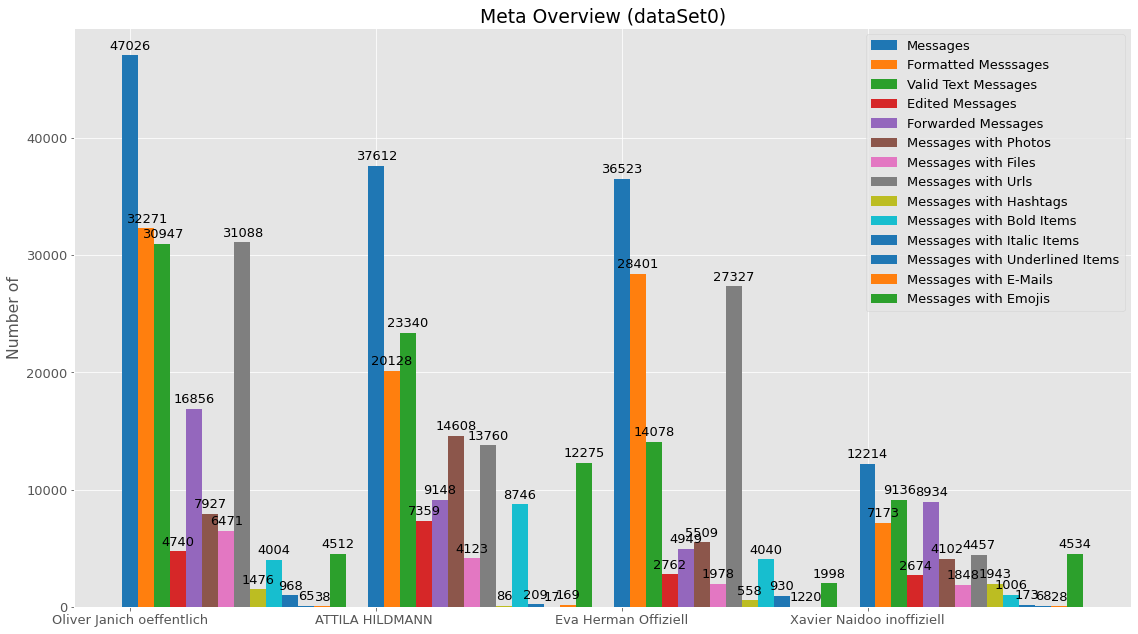

In [54]:
queryMetaPlotter(
    inputDescFilter = "dataSet0",
    configPlotWidth = 16,
    configPlotHeight = 9,
    configBarWidth = 0.065,
    outputFilename = "meta-overview-dataSet0.svg"
)

- Plot DataSet1

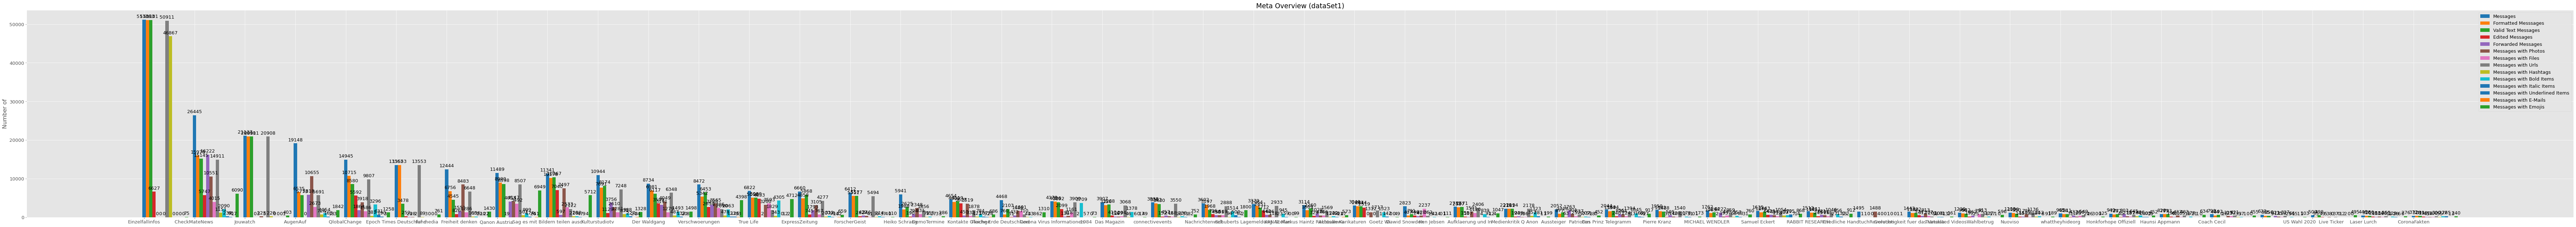

In [55]:
if("dataSet1" in C_LOAD_DATASETS):
    queryMetaPlotter(
        inputDescFilter = "dataSet1",
        configPlotWidth = 100,
        configPlotHeight = 9,
        configBarWidth = 0.065,
        outputFilename = "meta-overview-dataSet1.svg"
    )

- Plot DataSet1a

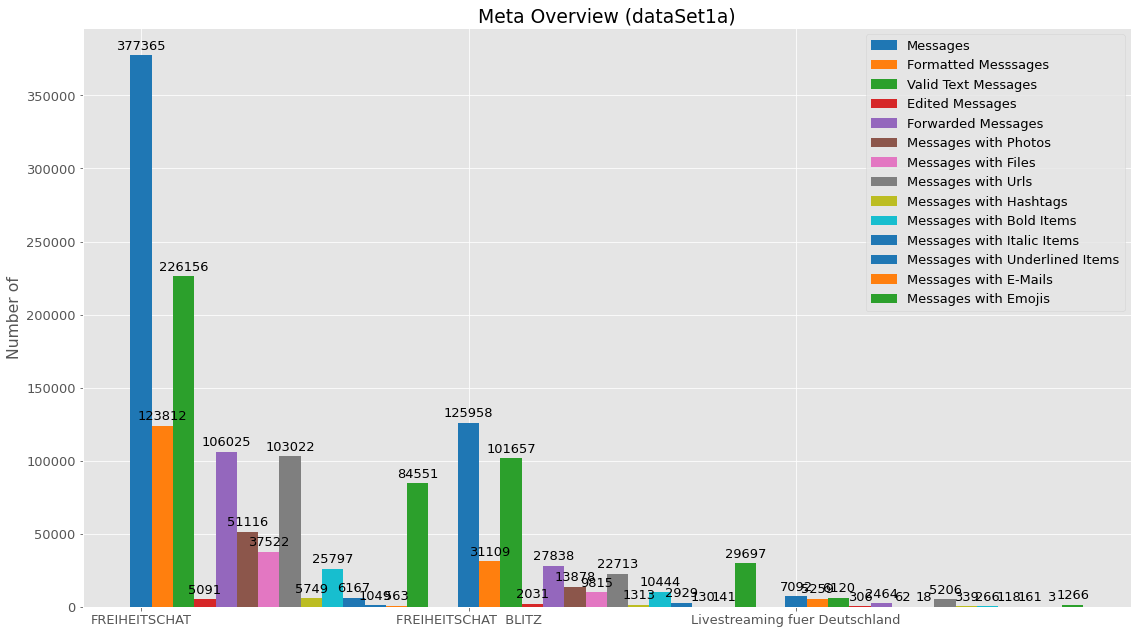

In [56]:
if("dataSet1a" in C_LOAD_DATASETS):
    queryMetaPlotter(
        inputDescFilter = "dataSet1a",
        configPlotWidth = 16,
        configPlotHeight = 9,
        configBarWidth = 0.065,
        outputFilename = "meta-overview-dataSet1a.svg"
    )

- Plot DataSet2

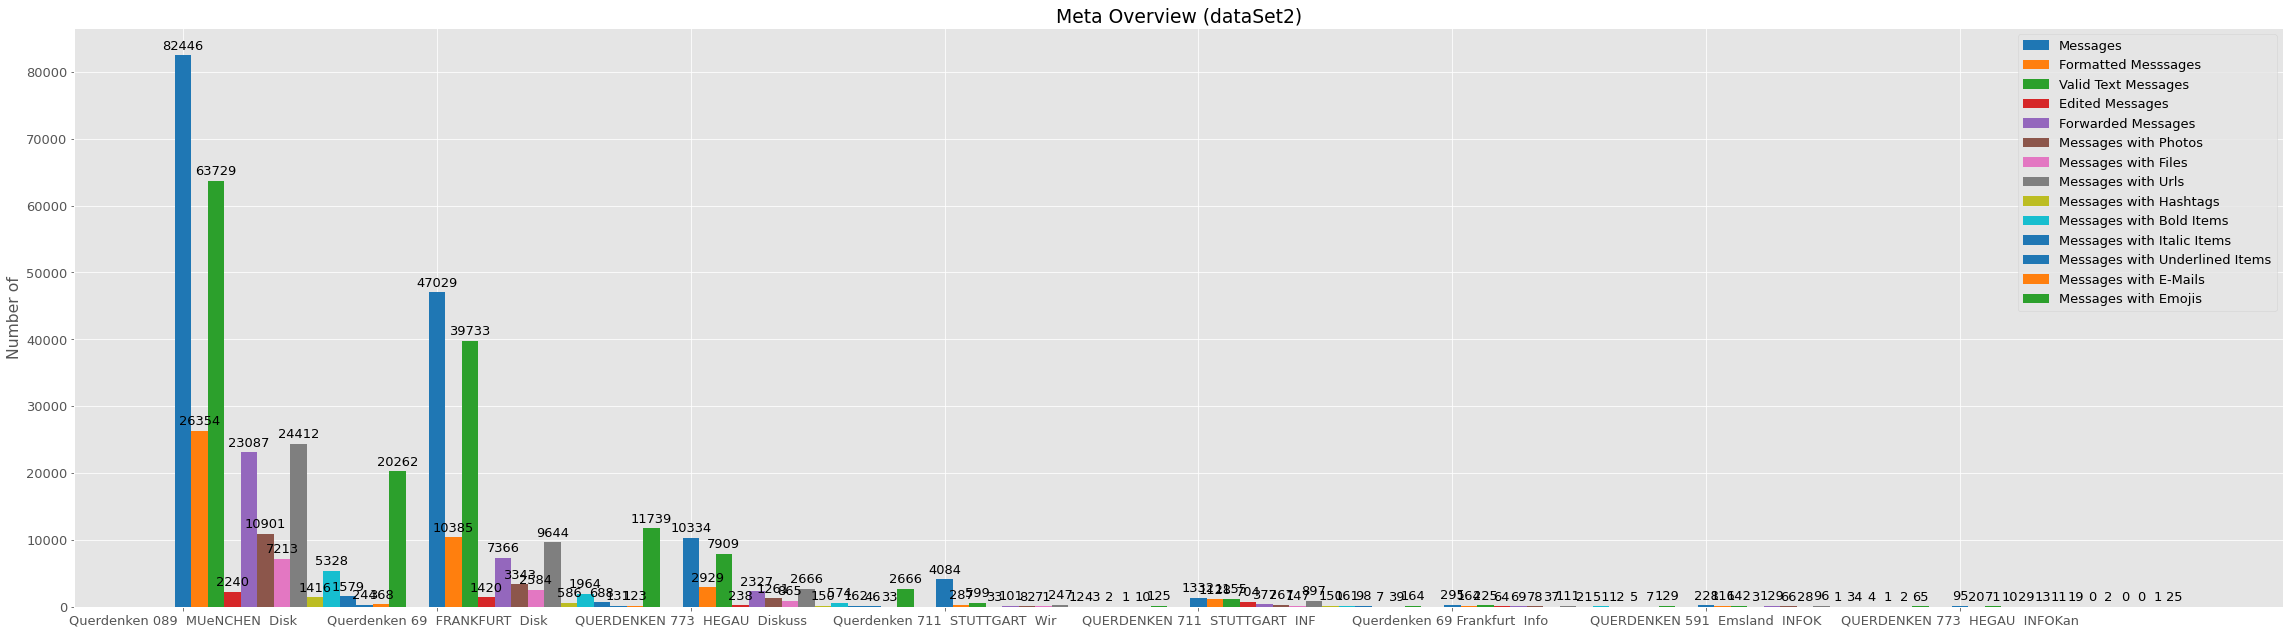

In [57]:
if("dataSet2" in C_LOAD_DATASETS):
    queryMetaPlotter(
        inputDescFilter = "dataSet2",
        configPlotWidth = 32,
        configPlotHeight = 9,
        configBarWidth = 0.065,
        outputFilename = "meta-overview-dataSet2.svg"
    )

### Social Graphs - Abbildung von Chats auf Features

#### Abweichungen von Chat und Nutzernamen

Siehe Beschreibung in ``Thesis.pdf``

In [58]:
def compareIdsAndLabels(df):

    gloStartStopwatch("Compare ids and labels")

    dictFromTranslator  = {}
    dictActorTranslator = {}

    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    
    df = df.set_index("date")
    df = df.sort_index()
    
    addFromCounter      = 0
    changedFromCounter  = 0
    
    addActorCounter     = 0
    changedActorCounter = 0

    for index, row in df.iterrows():
        
        n_from      = row["from"]
        n_from_id   = row["from_id"]

        n_from = str(n_from)
        n_from_id = str(n_from_id)

        n_actor      = row["actor"]
        n_actor_id   = row["actor_id"]

        n_actor = str(n_actor)
        n_actor_id = str(n_actor_id)

        if(str(n_from) != "nan"):
            if(n_from_id not in dictFromTranslator):
                # Add new key
                dictFromTranslator[n_from_id] = [n_from]
                addFromCounter = addFromCounter + 1
            else:
                # Has changed?
                oValueL = dictFromTranslator[n_from_id]
                if(n_from not in oValueL):
                    newList = oValueL.copy()
                    newList.append(n_from)
                    print("- Add changed attribute in from (prev=" + str(oValueL) + "/new=" + str(newList) + ")")
                    changedFromCounter = changedFromCounter + 1
                    dictFromTranslator[n_from_id] = newList

        if(str(n_actor) != "nan"):
            if(n_actor_id not in dictActorTranslator):
                # Add new key
                dictActorTranslator[n_actor_id] = [n_actor]
                addActorCounter = addActorCounter + 1
            else:
                # Has changed?
                oValueL = dictActorTranslator[n_actor_id]
                if(n_actor not in oValueL):
                    newList = oValueL.copy()
                    newList.append(n_actor)
                    print("- Add changed attribute in actor (prev=" + str(oValueL) + "/new=" + str(newList) + ")")
                    changedActorCounter = changedActorCounter + 1
                    dictActorTranslator[n_actor_id] = newList

    gloStopStopwatch("Compare ids and labels")
    
    print()
    print("addFromCounter:\t\t" + str(addFromCounter))
    print("changedFromCounter:\t" + str(changedFromCounter))
    
    print()
    print("addActorCounter:\t" + str(addActorCounter))
    print("changedActorCounter:\t" + str(changedFromCounter))
    
    print()
    if(addFromCounter != 0):
        print("fromFails Percent:\t" + str((changedFromCounter/addFromCounter)* 100) + "%")
            
    if(addActorCounter != 0):
        print("actorFails Percent:\t" + str((changedActorCounter/addActorCounter)* 100) + "%")

    return dictFromTranslator

In [59]:
if(C_SHORT_RUN == False):
    compareIdsAndLabels(dfAllDataMessages)

[Stopwatch started >>Compare ids and labels<<]
- Add changed attribute in actor (prev=['Victor Schurk']/new=['Victor Schurk', 'Heinrich Gruber'])
- Add changed attribute in actor (prev=['None']/new=['None', 'Lene Pepp'])
- Add changed attribute in actor (prev=['💔kid']/new=['💔kid', '🛸'])
- Add changed attribute in actor (prev=['Susanne Kaußen']/new=['Susanne Kaußen', 'Susanne'])
- Add changed attribute in actor (prev=['@Rizi']/new=['@Rizi', '@Fretchen'])
- Add changed attribute in from (prev=['Dea51 https://fotofeier.eu']/new=['Dea51 https://fotofeier.eu', 'Dea51 https://t.me/gruppekoelnstehtauf'])
- Add changed attribute in from (prev=['I_wear_Bommel']/new=['I_wear_Bommel', 'Bommel089'])
- Add changed attribute in actor (prev=['VEGANNE']/new=['VEGANNE', 'Anne Bringmann'])
- Add changed attribute in from (prev=['Doris Schneider']/new=['Doris Schneider', 'Doris'])
- Add changed attribute in from (prev=['@onlinedschungelbuch']/new=['@onlinedschungelbuch', '@hakunamatata'])
- Add changed a

#### Extrahieren von Features und dynamisches Auflösen

##### Formatierungs-spezifischen statischen Features

In [60]:
def extractImportantHashtags(df):
    dfMessages = df.copy()
    dfMessages = dfMessages[dfMessages.ftQrCoHashtags == True]

    hashTagList = list()
    for index, row in dfMessages.iterrows():
        for hashtagItem in row["ftTdHashtags"]:
            hashTagList.append(hashtagItem)

    return hashTagList

In [61]:
# return combinations
def extractImportantEmojis(df):

    dfMessages = df.copy()
    dfMessages = dfMessages[dfMessages.ftQrCoEmojis == True]

    li = dfMessages.ftTdEmojisDesc.values.tolist()

    retLi = list()

    for l in li:
        aString = ""
        for e in l:
            aString = aString + ":" + e 
        retLi.append(aString)

    return retLi

##### Autor-spezifischen statischen Features

(hier nicht beschrieben, siehe unten)

##### Dynamische Features

In [62]:
# param flagResolveNewUrls  Flag (see config above)

def resolveUrl(completeUrl, flagResolveNewUrls):
    
    if "bit.ly" in completeUrl:

        if(gloCheckIsAlreadyCached("resolved-urls.csv", completeUrl)):
            return gloGetCached("resolved-urls.csv", completeUrl)
        else:

            if(flagResolveNewUrls == False):
                return completeUrl

            print("(Resolve now >>" + completeUrl + "<<)")
            try:
                r = requests.get(completeUrl, timeout = 5)
                u = r.url
                gloAddToCache("resolved-urls.csv", completeUrl, u)
                return u
            except:
                print("(- Warn: Can not resolve (return completeUrl))")
                return completeUrl

    else:
        return completeUrl

In [63]:
# Return
# a = urlList,
# b = refList
# c = hostList
def extractImportantUrls(df):
    dfMessages = df.copy()
    dfMessages = dfMessages[dfMessages.ftQrCoUrls == True]

    hostList        = list()
    urList          = list()
    refList         = list()

    counterSucHostname = 0
    counterErrHostname = 0

    for index, row in dfMessages.iterrows():
        for urlItem in row["ftTdUrls"]:
            
            urlData = urlparse(str(urlItem))

            completeUrl      = urlData.geturl()

            rUrl     = resolveUrl(completeUrl, flagResolveNewUrls=C_RESOLVE_NEW_URLS)
            rUrlData = urlparse(rUrl)
            rCompleteUrl = rUrlData.geturl()
            rCompleteHostname = rUrlData.hostname

            if(str(rCompleteHostname) != "None"):
                counterSucHostname = counterSucHostname + 1

                hostList.append(str(rCompleteHostname))

                urList.append(str(rCompleteUrl))

                if "t.me" in str(rCompleteHostname):
                    refList.append(str(rCompleteUrl))
            else:
                counterErrHostname = counterErrHostname + 1

    #print("Got Hostnames (suc=" + str(counterSucHostname) + "/err=" + str(counterErrHostname) + ")")

    return (urList, refList, hostList)

In [64]:
# param flagResolveNewUrls  Flag (see config above)
def resolveImportantYoutubeVideos(urlList, flagResolveNewUrls):

    # Thanks https://gist.github.com/rodrigoborgesdeoliveira/987683cfbfcc8d800192da1e73adc486

    ytList = list()

    for url in urlList:

        url = str(url)

        if("youtube.com" in url or "youtu.be" in url or "youtube-nocookie.com" in url):
            if(gloCheckIsAlreadyCached("resolved-youtube.csv", url)):
                ytList.append(gloGetCached("resolved-youtube.csv", url)) 
            else:

                if(flagResolveNewUrls == False):
                    #print("(Disable resolve new youtube urls (return completeUrl) >>" + url + "<<)")
                    ytList.append(url)
                else:
                    print("Resolve now youtube >>" + url + "<<")
                    try:
                        r = requests.get(url, timeout = 5)
                        t = fromstring(r.content)
                        a = str(t.findtext('.//title'))
                        ytList.append(a)
                        gloAddToCache("resolved-youtube.csv", url, a)
                    except:
                        print("(- Warn: Can not resolve youtube url (return completeUrl))")
                        ytList.append(url)

    return ytList

##### Implementierung

In [65]:
# TODO: Bug: No Hostname detected if string startsWith ! "http" in urlparse
# TODO: Check: Refs ins both directions

# Returns
# a = Counter forwardedFromList
# b = Counter refList
# c = Counter hashtagList
# d = Counter hostList
# e = Counter emojiList
# f = Counter fromList
def extractSocialGraph(filePath, debugPrint, debugPrintCount):

    dfMessages = dictMessages[filePath].copy()

    # Formatierungs spezifischen statischen Features
    
    hashtagList = extractImportantHashtags(dfMessages)
    emojiList = extractImportantEmojis(dfMessages)
    
    # Autor spezifischen statischen Features
    
    forwardedFromList = list()
    if("forwarded_from" in dfMessages.columns):
        df = dfMessages.copy()
        df = df[df.ftQrIsForwarded == True]
    
        for index, row in df.iterrows():        
            forwardedFromList.append(str(row["forwarded_from"]))
            
    actorList = list()
    if("actor" in dfMessages.columns):
        for index, row in dfMessages.iterrows():
            actorList.append(str(row["actor"]))
    
    memberList = list()
    if("members" in dfMessages.columns):
        for index, row in dfMessages.iterrows():
            if(str(row["members"]) != "nan"):
                for memberItem in row["members"]:
                    memberList.append(str(memberItem))
                    
    fromList = list()
    if("from" in dfMessages.columns):
        for index, row in dfMessages.iterrows():
            s = str(row["from"])
            s = gloConvertToSafeString(s)
            if(s != "None"):
                fromList.append(s)
            
    savedFromList = list()
    if("saved_from" in dfMessages.columns):
        for index, row in dfMessages.iterrows():
            savedFromList.append(str(row["saved_from"]))

    # Dynamische Features
    urlList, refList, hostList = extractImportantUrls(dfMessages)

    ytList = resolveImportantYoutubeVideos(urlList, flagResolveNewUrls = C_RESOLVE_NEW_URLS)
    
    # Debug print
            
    configTopN = debugPrintCount

    if(debugPrint):

        print()
        print("Set top n to " + str(debugPrintCount))
        print()

        print("- Top Hosts (resovled) -")
        print ("\n".join(map(str, Counter(hostList).most_common(configTopN))))
        print()
        print("- Top URLs (resolved) -")
        print ("\n".join(map(str, Counter(urlList).most_common(configTopN))))
        print()
        print("- Top Refs from text (resolved) -")
        print ("\n".join(map(str, Counter(refList).most_common(configTopN))))
        print()
        print("- Top Refs (forwarded_from) -")
        print ("\n".join(map(str, Counter(forwardedFromList).most_common(configTopN))))
        print()
        print("- Top Refs (actor) -")
        print ("\n".join(map(str, Counter(actorList).most_common(configTopN))))
        print()
        print("- Top Refs (members) -")
        print ("\n".join(map(str, Counter(memberList).most_common(configTopN))))
        print()
        print("- Top Refs (from) -")
        print ("\n".join(map(str, Counter(fromList).most_common(configTopN))))
        print()
        print("- Top Refs (saved_from) -")
        print ("\n".join(map(str, Counter(savedFromList).most_common(configTopN))))
        print()
        print("- Top hashtags -")
        print ("\n".join(map(str, Counter(hashtagList).most_common(configTopN))))
        print()
        print("- Top emojis -")
        print ("\n".join(map(str, Counter(emojiList).most_common(configTopN))))
        print()
        print("- Top yt (resolved) -")
        print ("\n".join(map(str, Counter(ytList).most_common(configTopN))))
        print()
    
    return (Counter(forwardedFromList), Counter(refList), Counter(hashtagList),  Counter(hostList), Counter(emojiList), Counter(fromList))

In [66]:
dictSGD_ForwardedFrom = {}
dictSGD_Ref           = {}
dictSGD_Hashtag       = {}
dictSGD_Host          = {}
dictSGD_Emoji         = {}
dictSGD_From          = {}

gloStartStopwatch("Extract Social Graph Data")

for fP in dfInputFiles.inputPath:

    #gloStartStopwatch("Extract Social Graph Data >>" + fP + "<<")

    a, b, c, d, e, f = extractSocialGraph(fP, debugPrint=False, debugPrintCount = 0)

    dictSGD_ForwardedFrom[fP]   = a
    dictSGD_Ref[fP]             = b
    dictSGD_Hashtag[fP]         = c
    dictSGD_Host[fP]            = d
    dictSGD_Emoji[fP]           = e
    dictSGD_From[fP]            = f

    #gloStopStopwatch("Extract Social Graph Data >>" + fP + "<<")

gloStopStopwatch("Extract Social Graph Data")

[Stopwatch started >>Extract Social Graph Data<<]
[Stopwatch stopped >>Extract Social Graph Data<< (533.271s)]


#### Top-n Darstellung

In [67]:
def printSocialGraphDebug(filePathList):
    for fP in filePathList:
        print("Analyse now >>" + fP + "<<")
        _ = extractSocialGraph(fP, debugPrint=True, debugPrintCount=10)

In [68]:
if(C_SHORT_RUN == False):
    printSocialGraphDebug(dfInputFiles[dfInputFiles.inputLabel == "dataSet0"].inputPath)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<

Set top n to 10

- Top Hosts (resovled) -
('youtu.be', 3668)
('t.me', 1523)
('www.youtube.com', 705)
('www.bitchute.com', 364)
('www.n-tv.de', 321)
('www.attilahildmann.de', 265)
('www.welt.de', 229)
('www.spiegel.de', 226)
('demos.whattheyhide.org', 203)
('amzn.to', 174)

- Top URLs (resolved) -
('https://www.attilahildmann.de/de/shop/alle.html?pc=SAMURAI', 163)
('https://demo.terminkalender.top/pc.php', 116)
('https://www.youtube.com/watch', 108)
('https://t.me/FREIHEITS_CHAT_BL', 95)
('https://youtu.be/kWpzfqW34lA', 72)
('https://www.bitchute.com/video/5izjzGo5AyBw/', 70)
('https://t.me/FREIHEITSCHAT2020', 67)
('https://t.me/FreiheitsChatDE', 65)
('https://demos.whattheyhide.org/add', 49)
('https://t.me/ATTILAHILDMANN', 41)

- Top Refs from text (resolved) -
('https://t.me/FREIHEITS_CHAT_BL', 95)
('https://t.me/FREIHEITSCHAT2020', 67)
('https://t.me/FreiheitsChatDE', 65)
('https://t.me/ATTILAHILDMANN', 41)
('https://t.me/

#### Suchmuster für Chats

In [69]:
def getTopInfluencer(fPList, configTopN):

    for fP in fPList:

        chatName = queryChatName(fP)

        print()
        print("Analyse Chat (Forwarded From) >>" + chatName + "<<")
        
        socialGraphData = dictSGD_ForwardedFrom[fP]
        socialGraphData = socialGraphData.most_common(configTopN)

        counter = 1

        # Iterate over data
        for oChatName, oChatRefs in socialGraphData:
            
            # Query other params
            oChatName    = gloConvertToSafeChatName(str(oChatName))
            oChatRefs    = oChatRefs

            # Already downloaded?
            flagDownloaded = False
            if oChatName in dfQueryMeta.qryChatName.values:
                flagDownloaded = True

            if(oChatName != "nan"):

                print(str(counter) + ": (downloaded=" + str(flagDownloaded) + ") (refs=" + str(oChatRefs) + ")\t\t>>" + str(oChatName) + "<<")
                counter = counter + 1


        print()
        print("Analyse Chat (Refs) >>" + chatName + "<<")
        
        socialGraphData = dictSGD_Ref[fP]
        socialGraphData = socialGraphData.most_common(configTopN)

        counter = 1

        # Iterate over data
        for oChatName, oChatRefs in socialGraphData:
            
            # Query other params
            oChatName    = str(oChatName)
            oChatRefs    = oChatRefs

            if(oChatName != "nan"):

                print(str(counter) + " (refs=" + str(oChatRefs) + ")\t\t>>" + str(oChatName) + "<<")
                counter = counter + 1

In [70]:
# TODO: Can not get all items in dataSet1

"""
# Attila Hildmann #
- Anonymous Germany - not found
- https://t.me/DEMOKRATENCHAT - no entries
- https://t.me/ChatDerFreiheit - no entries
- https://t.me/FREIHEITSCHAT2020 - not found

# Oliver Janich #
- Oliver Janich Premium - not found

# Xavier Naidoo #
- Xavier(Der VereiNiger)Naidoo😎 - not found
- https://t.me/PostAppender_bot - bot chat
"""
getTopInfluencer(list(dfInputFiles[dfInputFiles.inputLabel == "dataSet0"].inputPath), 10)


Analyse Chat (Forwarded From) >>ATTILA HILDMANN <<
1: (downloaded=True) (refs=7448)		>>ATTILA HILDMANN <<
2: (downloaded=True) (refs=616)		>>Gerechtigkeit fuer das Vaterla<<
3: (downloaded=True) (refs=44)		>>Aktuelle Karikaturen  Goetz Wi<<
4: (downloaded=True) (refs=41)		>>   <<
5: (downloaded=False) (refs=38)		>>Anonymous Germany<<
6: (downloaded=True) (refs=34)		>>MICHAEL WENDLER <<
7: (downloaded=True) (refs=33)		>>Oliver Janich oeffentlich<<
8: (downloaded=True) (refs=28)		>>Laser Lurch<<
9: (downloaded=True) (refs=28)		>>Dawid Snowden<<
10: (downloaded=True) (refs=26)		>>Ken Jebsen  Aufklaerung und In<<

Analyse Chat (Refs) >>ATTILA HILDMANN <<
1 (refs=95)		>>https://t.me/FREIHEITS_CHAT_BL<<
2 (refs=67)		>>https://t.me/FREIHEITSCHAT2020<<
3 (refs=65)		>>https://t.me/FreiheitsChatDE<<
4 (refs=41)		>>https://t.me/ATTILAHILDMANN<<
5 (refs=39)		>>https://t.me/ChatDerFreiheit<<
6 (refs=37)		>>https://t.me/gerechtigkeitfuersvaterland<<
7 (refs=34)		>>https://t.me/MICHAELWENDLEROFFICIA

### Social Graphs - Darstellung von Graphen

#### Visualisierung-Möglichkeiten von Graphen

##### Layouts und Zeichen Funktionen definieren

Layout auswählen

- 1 = Kamda Kawai Layout
- 2 = Spring Layout
- 3 = Graphviz Layout

In [71]:
def getSocialGraphLayout(layoutSelector, G):
    if(layoutSelector == 1):
        return nx.kamada_kawai_layout(G.to_undirected())
    elif(layoutSelector == 2):
        return nx.spring_layout(G.to_undirected(), k = 0.15, iterations=200)
    elif(layoutSelector == 3):
        return nx.nx_pydot.graphviz_layout(G)

Plot Funktion definieren

- ``G``: graph
- ``layoutSelector``: siehe oben (Layout auswählen)
- ``configFactorEdge``: e.g. 100 => weight / 100
- ``configFactorNode``: e.g. 10  => weight / 10
- ``configArrowSize``: e.g. 5
- ``configPlotWidth``: e.g. 16
- ``configPlotHeight``: e.g. 9
- ``outputFilename``: e.g. test.png (set "" == no output file)
- ``outputTitle``: e.g. Graph (required)

In [72]:
def drawSocialGraph(G, layoutSelector, configFactorEdge, configFactorNode, configArrowSize, configPlotWidth, configPlotHeight, outputFilename, outputTitle):
    
    gloStartStopwatch("Social Graph Plot")
    
    plt.figure(figsize=(configPlotWidth,configPlotHeight))
        
    pos = getSocialGraphLayout(layoutSelector = layoutSelector, G = G)
    
    # Clean edges
    edges       = nx.get_edge_attributes(G, "weight")
    edgesTLabel = nx.get_edge_attributes(G, "tLabel")

    clean_edges         = dict()
    clean_edges_labels  = dict()
    
    for key in edges:
        
        #Set edge weight
        clean_edges[key]        = (100 - edges[key]) / configFactorEdge

        #set edge layout
        clean_edges_labels[key] = edgesTLabel[key]
    
    # Clean nodes
    nodes       = nx.get_node_attributes(G,'weight')
    nodesTLabel = nx.get_node_attributes(G,'tLabel')
    nodesTColor = nx.get_node_attributes(G,'tColor')

    clean_nodes         = dict()
    clean_nodes_labels  = dict()
    clean_nodes_color   = dict()
    
    for key in nodes:
        
        #Set node weight        
        clean_nodes[key]        = nodes[key] / configFactorNode

        #Set node layout
        clean_nodes_labels[key] = nodesTLabel[key]
        clean_nodes_color[key]  = nodesTColor[key]
    
    # Revert DiGraph (arrows direction)
    #G_rev = nx.DiGraph.reverse(G) 
    
    G_rev = G

    # Draw
    nx.draw(G_rev,
        pos,
        with_labels=True,
        width=list(clean_edges.values()),
        node_size=list(clean_nodes.values()),
        labels=clean_nodes_labels,
        node_color=list(clean_nodes_color.values()),
        arrowsize=configArrowSize,
        #arrowstyle="wedge"
        #connectionstyle="arc3, rad = 0.1"
    )
    
    # Set labels
    _ = nx.draw_networkx_edge_labels(G_rev, pos, edge_labels=clean_edges_labels, font_size = 13)

    if(outputTitle != ""):
        plt.title(outputTitle)

    # Save and show fig
    if(outputFilename != ""):
        plt.savefig(dir_var_output + outputFilename)
    
    plt.show()
    
    gloStopStopwatch("Social Graph Plot")

##### Testen von Plotten

In [73]:
# Generates Test Graph
def generateTestGraph():

    G_weighted = nx.DiGraph()

    # Formel (1-(Anzahl gesendete Nachrichten/Anzahl gültige Nachrichten von Zielchat)) * 100
    
    G_weighted.add_edge("Autor 1", "Chat 1", weight=44,  tLabel = "(1 - (7.000/12.500)) * 100 = 44")
    G_weighted.add_edge("Autor 2", "Chat 1", weight=92,  tLabel = "(1 - (1.000/12.500)) * 100 = 92")
    G_weighted.add_edge("Autor 3", "Chat 1", weight=88,  tLabel = "(1 - (1.500/12.500)) * 100 = 88")
    G_weighted.add_edge("Chat 2",  "Chat 1", weight=76,  tLabel = "(1 - (3.000/12.500)) * 100 = 76")
        
    G_weighted.add_edge("Autor 1", "Chat 2", weight=81.25,  tLabel = "(1 - (3.000/16.000)) * 100 = 81,25")
    G_weighted.add_edge("Autor 2", "Chat 2", weight=25,     tLabel = "(1 - (12.000/16.000)) * 100 = 25")
    G_weighted.add_edge("Autor 3", "Chat 2", weight=93.75,  tLabel = "(1 - (1.000/16.000)) * 100 = 93,75")
    
    # Knoten Gewicht (Anzahl gültiger Nachrichten)
    
    # - Exakt Anzahl gültige Nachrichten (empfangen)
    G_weighted.add_node("Chat 1", weight=12500, tLabel = "Chat 1\n[12.500]", tColor="#0080ff")
    G_weighted.add_node("Chat 2", weight=16000, tLabel = "Chat 2\n[16.000]", tColor="#0080ff")

    # - Geschätzt Anzahl gültige Nachrichten (gesendet) MAX-Wert
    G_weighted.add_node("Autor 1", weight=7000, tLabel = "Autor 1\n[7.000]", tColor="#ff8000")
    G_weighted.add_node("Autor 2", weight=12000, tLabel = "Autor 2\n[12.000]", tColor="#ff8000")
    G_weighted.add_node("Autor 3", weight=1500, tLabel = "Autor 3\n[1.500]", tColor="#ff8000")
    
    return G_weighted

generatedTestGraph = generateTestGraph()

[Stopwatch started >>Social Graph Plot<<]


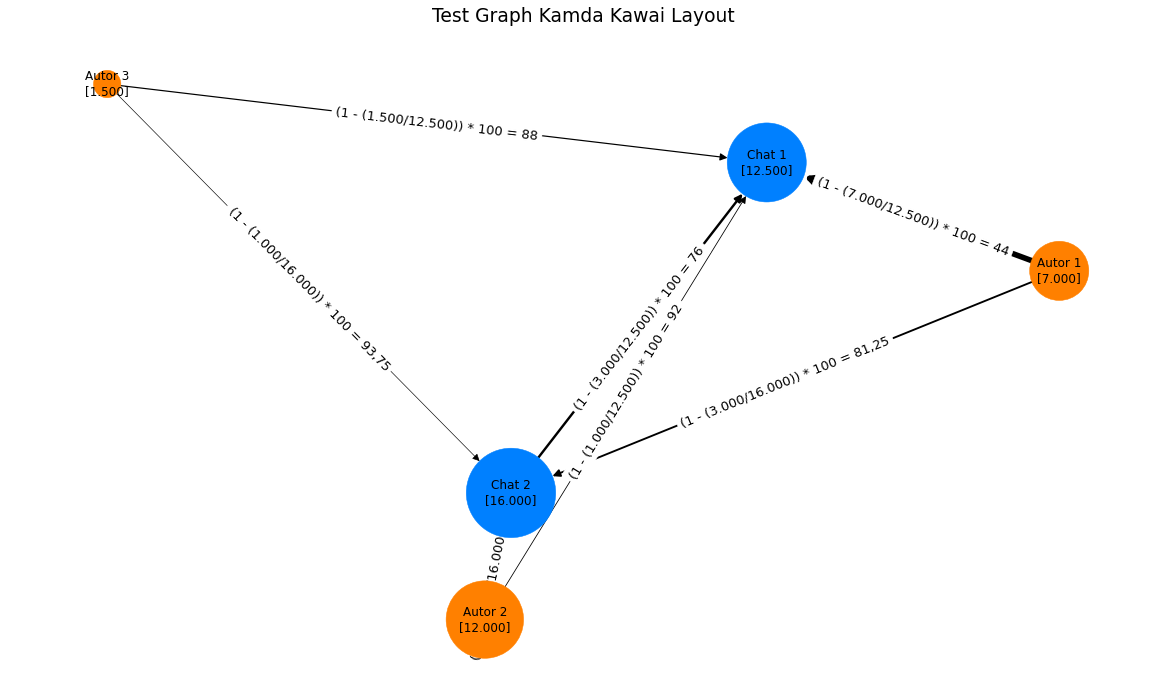

[Stopwatch stopped >>Social Graph Plot<< (0.311s)]


In [74]:
drawSocialGraph(
    G = generatedTestGraph,
    layoutSelector=1,
    configFactorEdge = 10,
    configFactorNode = 2,
    configArrowSize = 15,
    configPlotWidth = 16,
    configPlotHeight = 9,
    outputFilename = "social-graph-s-sample.svg",
    outputTitle = "Test Graph Kamda Kawai Layout"
)

[Stopwatch started >>Social Graph Plot<<]


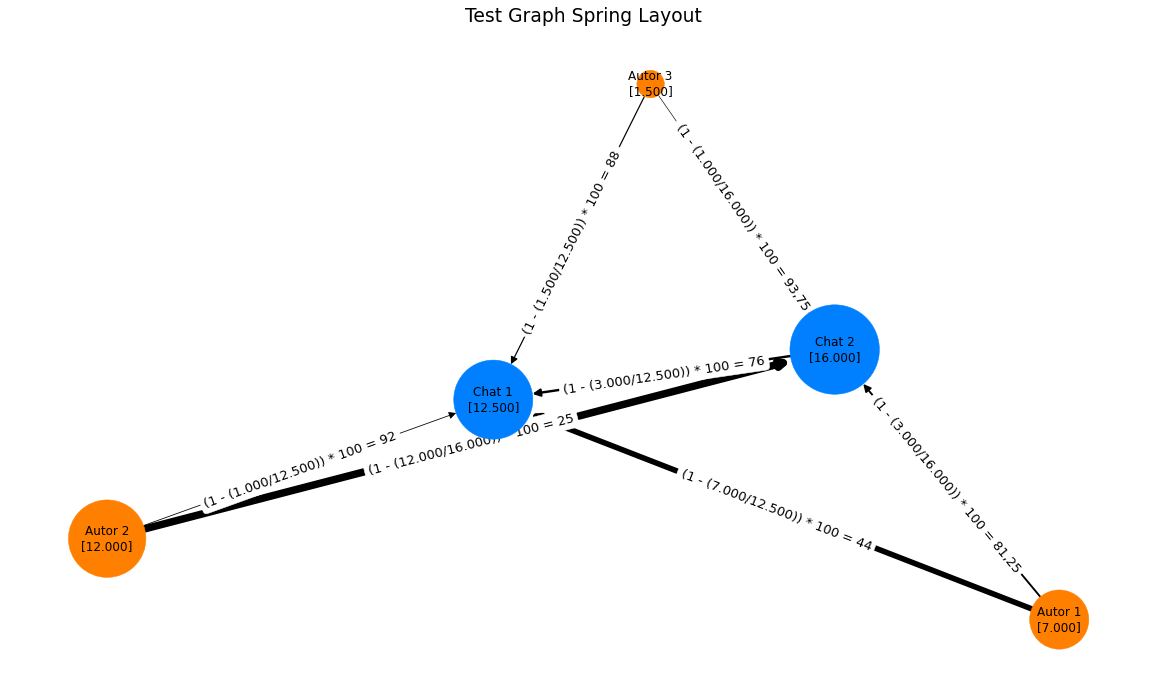

[Stopwatch stopped >>Social Graph Plot<< (0.205s)]


In [75]:
drawSocialGraph(
    G = generatedTestGraph,
    layoutSelector=2,
    configFactorEdge = 10,
    configFactorNode = 2,
    configArrowSize = 15,
    configPlotWidth = 16,
    configPlotHeight = 9,
    outputFilename = "",
    outputTitle = "Test Graph Spring Layout"
)

[Stopwatch started >>Social Graph Plot<<]


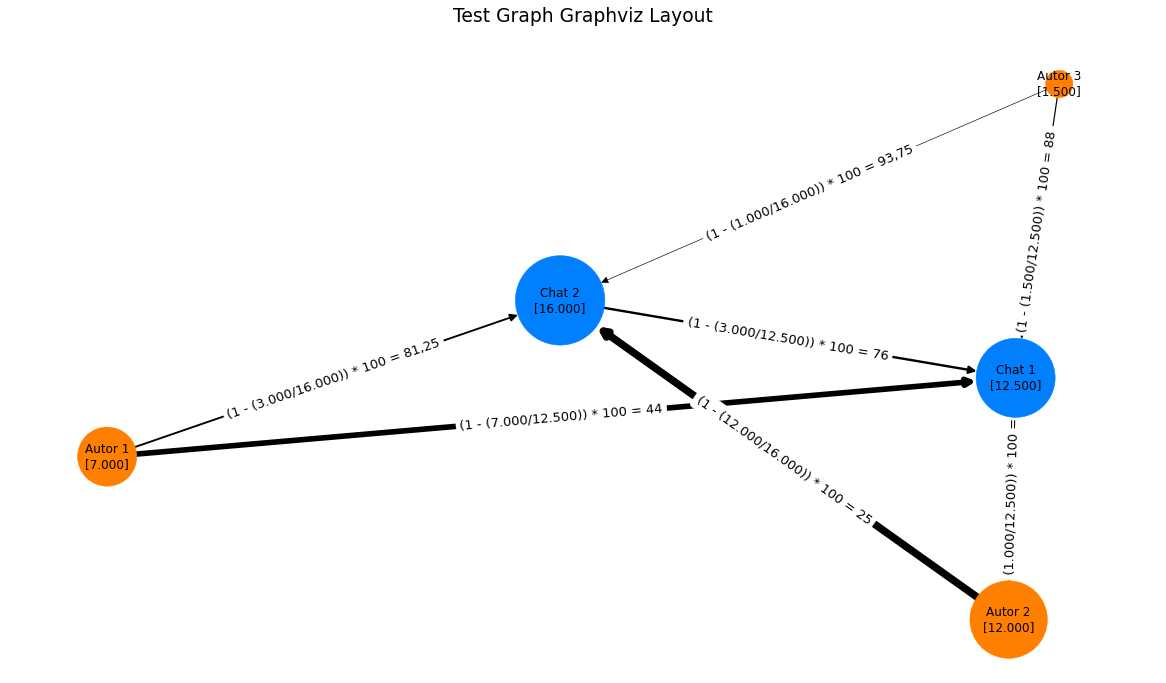

[Stopwatch stopped >>Social Graph Plot<< (0.618s)]


In [76]:
drawSocialGraph(
    G = generatedTestGraph,
    layoutSelector=3,
    configFactorEdge = 10,
    configFactorNode = 2,
    configArrowSize = 15,
    configPlotWidth = 16,
    configPlotHeight = 9,
    outputFilename = "",
    outputTitle = "Test Graph Graphviz Layout"
)

#### Visualisierung-Möglichkeiten von heruntergeladenen Chats

##### Implementierung

Hilfsfunktion für Gewichte

In [77]:
# Add node weight to dict
# Only adds new weight if newWeight > oldWeight
def addSocialGraphNodeWeight(chatName, chatWeight, targetDict):
    
    if(chatName in targetDict):
        oldWeight = targetDict[chatName]
        if(chatWeight > oldWeight):
            targetDict[chatName] = chatWeight
    else:
        targetDict[chatName] = chatWeight

Graph berechnen

- ``configTopNInfluencer``: e.g. For top 10 = 10
- ``configMinRefs``: e.g. 1 must have > 1 % forwarded messages
- ``listFilePaths``: List process filePaths
- ``socialGraphTargetDict``: e.g. forwarded from dict or hashtag dict
- ``socialGraphTargetAttribute``: e.g. ftQrIsForwarded (for calc percent)
- ``configFlagDebugLabel``: e.g. show debug info on label

In [78]:
def generateSocialGraph(configTopNInfluencer, configMinRefs, listFilePaths, socialGraphTargetDict, socialGraphTargetAttribute, configFlagDebugLabel):
    
    # Save node weights to dict
    dictSocialNodeWeights   = dict()

    # Flag downloaded nodes (exact node weight)
    dictExactNodesLabels    = {}
    
    gloStartStopwatch("Social Graph")
    
    # Generate directed graph
    G_weighted = nx.DiGraph()
    
    print("- Add edges")
    for fP in listFilePaths:
        
        # Query own params
        chatName                        = queryChatName(fP)
        chatNumberOfMessages            = queryNumberOfMessages(fP)
        chatNumberOfTargetMessages      = queryNumberOfMessagesByAttEqTrue(fP, socialGraphTargetAttribute)

        gloStartStopwatch("SG-Extract " + chatName + "(" + str(chatNumberOfTargetMessages) + "/" + str(chatNumberOfMessages) + " messages)")
        
        # Add exact node size (chat downloaded) and flag node
        addSocialGraphNodeWeight(chatName, chatNumberOfMessages, dictSocialNodeWeights)
        dictExactNodesLabels[chatName] = str(chatName) + "\n=[" + str(chatNumberOfTargetMessages) + "/" + str(chatNumberOfMessages) + "]"

        # Extract social graph data and get top influencer
        socialGraphData = socialGraphTargetDict[fP]
        socialGraphData = socialGraphData.most_common(configTopNInfluencer)
        
        # Iterate over forwarder
        for oChatName, oChatRefs in socialGraphData:
            
            # Query other params
            oChatName    = gloConvertToSafeChatName(str(oChatName))
            oChatRefs    = oChatRefs

            # If has forwarder
            if(oChatName != "nan"):
        
                # Calc percent (forwarded_messages)
                per = (oChatRefs/chatNumberOfTargetMessages) * 100

                # Filter unimportant forwarders
                if(per > configMinRefs):
                
                    # Add estimanted node size (chat not downloaded)
                    addSocialGraphNodeWeight(oChatName, oChatRefs, dictSocialNodeWeights)

                    # Invert percent (distance)
                    wei = 100 - per

                    # Label
                    if(configFlagDebugLabel):
                        lab = str(round(per, 3)) + "% (" + str(oChatRefs) + "/" + str(chatNumberOfTargetMessages) + "≙" + str(round(wei, 3)) + ")"
                    else:
                        lab = ""

                    # Add edge
                    G_weighted.add_edge(
                        chatName,
                        oChatName,
                        weight=wei,
                        tLabel = lab
                    )

        gloStopStopwatch("SG-Extract " + chatName + "(" + str(chatNumberOfTargetMessages) + "/" + str(chatNumberOfMessages) + " messages)")
        
    print("- Add different nodes")
    for aNode in dictSocialNodeWeights:
        
        # Query node params
        nodeName   = str(aNode)
        nodeWeight = dictSocialNodeWeights[aNode]

        # Set defaults
        tValueColor = "#ff8000"
        tLabel = str(nodeName) + "\n≈[" + str(nodeWeight) + "]"

        # Overwrite (if chat downloaded = exact weight)
        if(nodeName in dictExactNodesLabels):
            tValueColor = "#0080ff"
            tLabel = dictExactNodesLabels[nodeName]
        
        G_weighted.add_node(
            nodeName,
            weight=nodeWeight,
            tLabel = tLabel,
            tColor=tValueColor
        )
        
    gloStopStopwatch("Social Graph")
        
    return G_weighted

##### Top 25 Forwarded From (DataSet0)

[Stopwatch started >>Social Graph<<]
- Add edges
[Stopwatch started >>SG-Extract ATTILA HILDMANN (9148/37612 messages)<<]
[Stopwatch stopped >>SG-Extract ATTILA HILDMANN (9148/37612 messages)<< (0.004s)]
[Stopwatch started >>SG-Extract Oliver Janich oeffentlich(16856/47026 messages)<<]
[Stopwatch stopped >>SG-Extract Oliver Janich oeffentlich(16856/47026 messages)<< (0.003s)]
[Stopwatch started >>SG-Extract Eva Herman Offiziell(4949/36523 messages)<<]
[Stopwatch stopped >>SG-Extract Eva Herman Offiziell(4949/36523 messages)<< (0.003s)]
[Stopwatch started >>SG-Extract Xavier Naidoo inoffiziell(8934/12214 messages)<<]
[Stopwatch stopped >>SG-Extract Xavier Naidoo inoffiziell(8934/12214 messages)<< (0.004s)]
- Add different nodes
[Stopwatch stopped >>Social Graph<< (0.358s)]
[Stopwatch started >>Social Graph Plot<<]


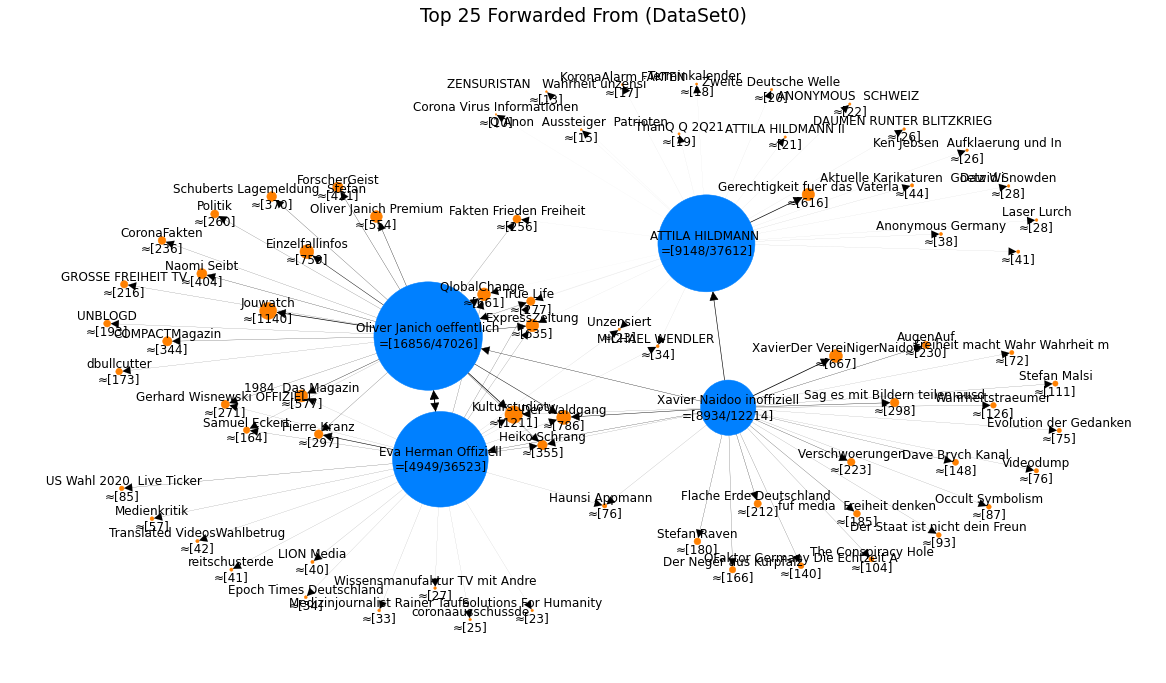

[Stopwatch stopped >>Social Graph Plot<< (1.910s)]


In [79]:
drawSocialGraph(
    generateSocialGraph(
        configTopNInfluencer = 25,  
        configMinRefs = 0,       
        listFilePaths = list(dfInputFiles[dfInputFiles.inputLabel == "dataSet0"].inputPath),
        socialGraphTargetDict = dictSGD_ForwardedFrom,
        socialGraphTargetAttribute = "ftQrIsForwarded",
        configFlagDebugLabel = False
    ),
    layoutSelector = 1,
    configFactorEdge = 10,
    configFactorNode = 4,
    configArrowSize = 20,
    configPlotWidth = 16,
    configPlotHeight = 9,
    outputFilename = "social-graph-dataSet0-forwarded-from.svg",
    outputTitle = "Top 25 Forwarded From (DataSet0)"
)

##### Top 25 Hashtags (DataSet0)

[Stopwatch started >>Social Graph<<]
- Add edges
[Stopwatch started >>SG-Extract ATTILA HILDMANN (86/37612 messages)<<]
[Stopwatch stopped >>SG-Extract ATTILA HILDMANN (86/37612 messages)<< (0.002s)]
[Stopwatch started >>SG-Extract Oliver Janich oeffentlich(1476/47026 messages)<<]
[Stopwatch stopped >>SG-Extract Oliver Janich oeffentlich(1476/47026 messages)<< (0.003s)]
[Stopwatch started >>SG-Extract Eva Herman Offiziell(558/36523 messages)<<]
[Stopwatch stopped >>SG-Extract Eva Herman Offiziell(558/36523 messages)<< (0.003s)]
[Stopwatch started >>SG-Extract Xavier Naidoo inoffiziell(1943/12214 messages)<<]
[Stopwatch stopped >>SG-Extract Xavier Naidoo inoffiziell(1943/12214 messages)<< (0.002s)]
- Add different nodes
[Stopwatch stopped >>Social Graph<< (0.249s)]
[Stopwatch started >>Social Graph Plot<<]


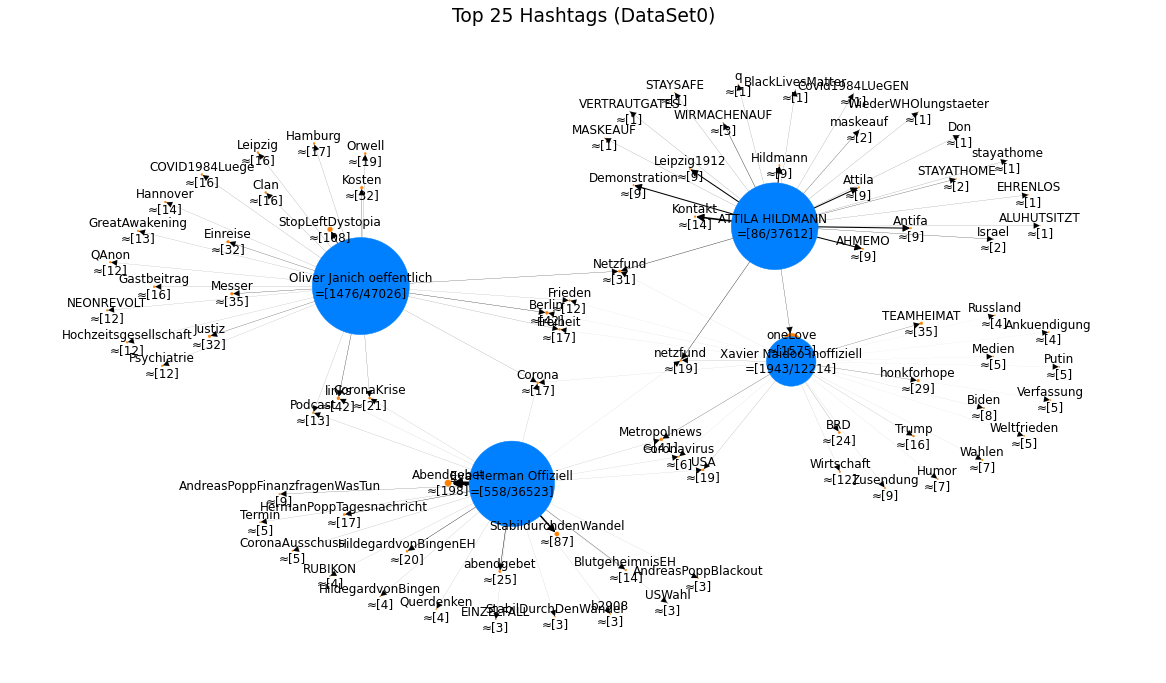

[Stopwatch stopped >>Social Graph Plot<< (1.746s)]


In [80]:
drawSocialGraph(
    generateSocialGraph(
        configTopNInfluencer = 25,  
        configMinRefs = 0,        
        listFilePaths = list(dfInputFiles[dfInputFiles.inputLabel == "dataSet0"].inputPath),
        socialGraphTargetDict = dictSGD_Hashtag,
        socialGraphTargetAttribute = "ftQrCoHashtags",
        configFlagDebugLabel = False
    ),
    layoutSelector = 1,
    configFactorEdge = 10,
    configFactorNode = 5,
    configArrowSize = 15,
    configPlotWidth = 16,
    configPlotHeight = 9,
    outputFilename = "",
    outputTitle = "Top 25 Hashtags (DataSet0)"
)

##### Top 25 Hosts (DataSet0)

[Stopwatch started >>Social Graph<<]
- Add edges
[Stopwatch started >>SG-Extract ATTILA HILDMANN (13760/37612 messages)<<]
[Stopwatch stopped >>SG-Extract ATTILA HILDMANN (13760/37612 messages)<< (0.003s)]
[Stopwatch started >>SG-Extract Oliver Janich oeffentlich(31088/47026 messages)<<]
[Stopwatch stopped >>SG-Extract Oliver Janich oeffentlich(31088/47026 messages)<< (0.004s)]
[Stopwatch started >>SG-Extract Eva Herman Offiziell(27327/36523 messages)<<]
[Stopwatch stopped >>SG-Extract Eva Herman Offiziell(27327/36523 messages)<< (0.005s)]
[Stopwatch started >>SG-Extract Xavier Naidoo inoffiziell(4457/12214 messages)<<]
[Stopwatch stopped >>SG-Extract Xavier Naidoo inoffiziell(4457/12214 messages)<< (0.004s)]
- Add different nodes
[Stopwatch stopped >>Social Graph<< (0.399s)]
[Stopwatch started >>Social Graph Plot<<]


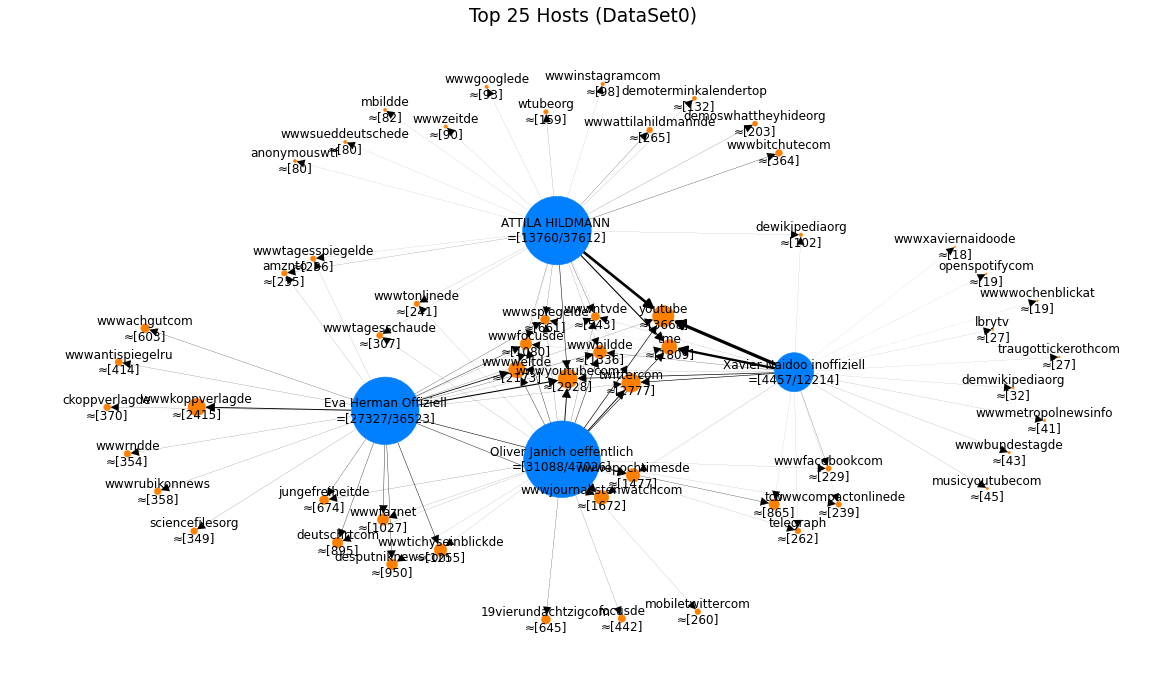

[Stopwatch stopped >>Social Graph Plot<< (1.371s)]


In [81]:
drawSocialGraph(
    generateSocialGraph(
        configTopNInfluencer = 25,  
        configMinRefs = 0,        
        listFilePaths = list(dfInputFiles[dfInputFiles.inputLabel == "dataSet0"].inputPath),
        socialGraphTargetDict = dictSGD_Host,
        socialGraphTargetAttribute = "ftQrCoUrls",
        configFlagDebugLabel = False
    ),
    layoutSelector = 1,
    configFactorEdge = 10,
    configFactorNode = 8,
    configArrowSize = 20,
    configPlotWidth = 16,
    configPlotHeight = 9,
    outputFilename = "",
    outputTitle = "Top 25 Hosts (DataSet0)"
)

##### Top 25 Emojis (dDataSet0)

[Stopwatch started >>Social Graph<<]
- Add edges
[Stopwatch started >>SG-Extract ATTILA HILDMANN (12275/37612 messages)<<]
[Stopwatch stopped >>SG-Extract ATTILA HILDMANN (12275/37612 messages)<< (0.008s)]
[Stopwatch started >>SG-Extract Oliver Janich oeffentlich(4512/47026 messages)<<]
[Stopwatch stopped >>SG-Extract Oliver Janich oeffentlich(4512/47026 messages)<< (0.007s)]
[Stopwatch started >>SG-Extract Eva Herman Offiziell(1998/36523 messages)<<]
[Stopwatch stopped >>SG-Extract Eva Herman Offiziell(1998/36523 messages)<< (0.015s)]
[Stopwatch started >>SG-Extract Xavier Naidoo inoffiziell(4534/12214 messages)<<]
[Stopwatch stopped >>SG-Extract Xavier Naidoo inoffiziell(4534/12214 messages)<< (0.007s)]
- Add different nodes
[Stopwatch stopped >>Social Graph<< (0.301s)]
[Stopwatch started >>Social Graph Plot<<]


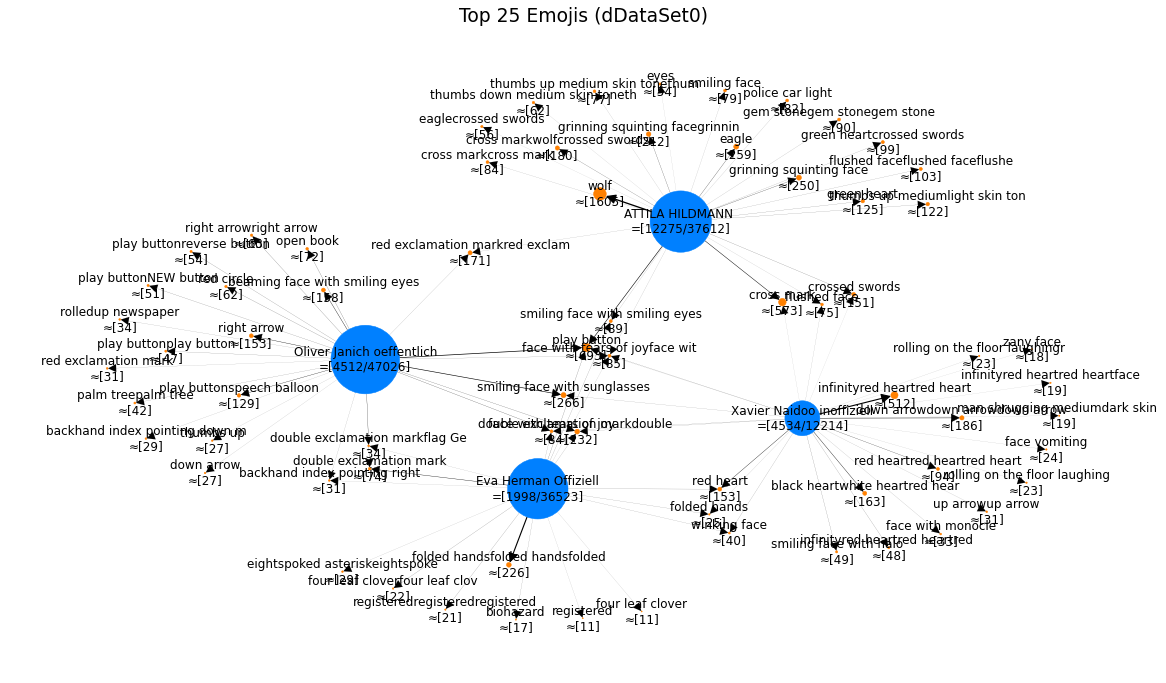

[Stopwatch stopped >>Social Graph Plot<< (1.484s)]


In [82]:
drawSocialGraph(
    generateSocialGraph(
        configTopNInfluencer = 25,  
        configMinRefs = 0,        
        listFilePaths = list(dfInputFiles[dfInputFiles.inputLabel == "dataSet0"].inputPath),
        socialGraphTargetDict = dictSGD_Emoji,
        socialGraphTargetAttribute = "ftQrCoEmojis",
        configFlagDebugLabel = False
    ),
    layoutSelector = 1,
    configFactorEdge = 10,
    configFactorNode = 10,
    configArrowSize = 20,
    configPlotWidth = 16,
    configPlotHeight = 9,
    outputFilename = "",
    outputTitle = "Top 25 Emojis (dDataSet0)"
)

##### Top 25 From (DataSet1a)

[Stopwatch started >>Social Graph<<]
- Add edges
[Stopwatch started >>SG-Extract FREIHEITSCHAT(226156/377365 messages)<<]
[Stopwatch stopped >>SG-Extract FREIHEITSCHAT(226156/377365 messages)<< (0.007s)]
[Stopwatch started >>SG-Extract FREIHEITSCHAT  BLITZ(101657/125958 messages)<<]
[Stopwatch stopped >>SG-Extract FREIHEITSCHAT  BLITZ(101657/125958 messages)<< (0.004s)]
[Stopwatch started >>SG-Extract Livestreaming fuer Deutschland(6120/7092 messages)<<]
[Stopwatch stopped >>SG-Extract Livestreaming fuer Deutschland(6120/7092 messages)<< (0.003s)]
- Add different nodes
[Stopwatch stopped >>Social Graph<< (1.809s)]
[Stopwatch started >>Social Graph Plot<<]


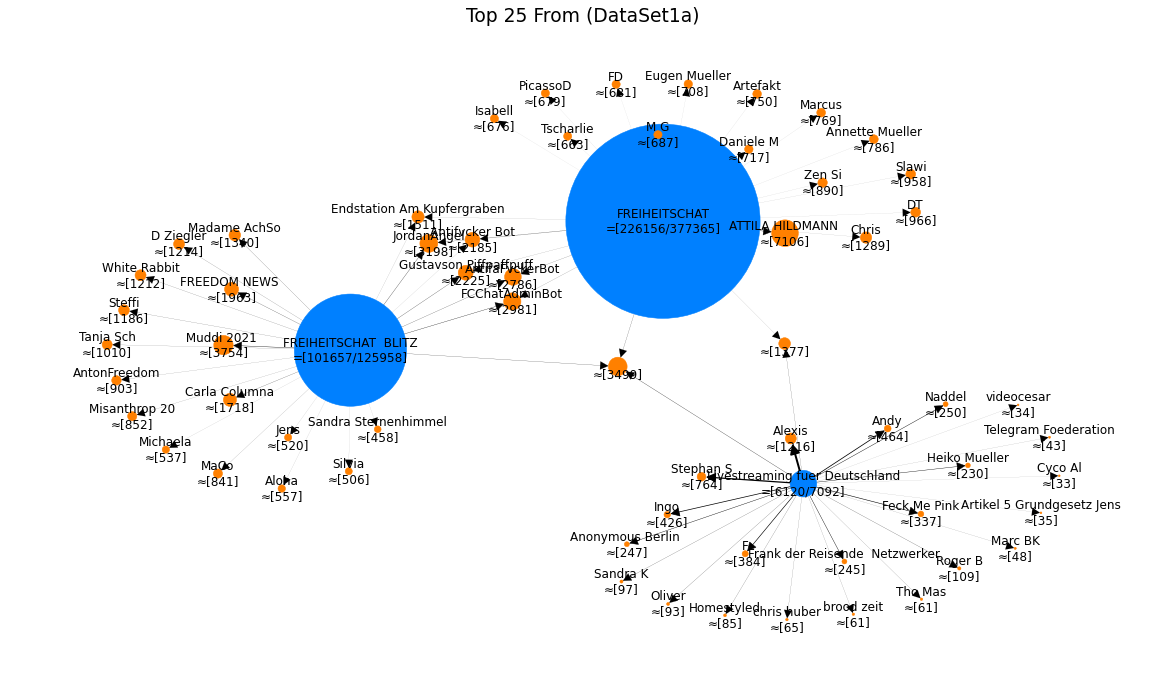

[Stopwatch stopped >>Social Graph Plot<< (1.564s)]


In [83]:
if("dataSet1a" in C_LOAD_DATASETS):
    drawSocialGraph(
        generateSocialGraph(
            configTopNInfluencer = 25,  
            configMinRefs = 0,        
            listFilePaths = list(dfInputFiles[dfInputFiles.inputLabel == "dataSet1a"].inputPath),
            socialGraphTargetDict = dictSGD_From,
            socialGraphTargetAttribute = "ftQrIsValidText",
            configFlagDebugLabel = False
        ),
        layoutSelector = 1,
        configFactorEdge = 10,
        configFactorNode = 10,
        configArrowSize = 20,
        configPlotWidth = 16,
        configPlotHeight = 9,
        outputFilename = "social-graph-dataSet1a-from.svg",
        outputTitle = "Top 25 From (DataSet1a)"
    )

### Dimension Zeit

#### Wie aufbereiten?

##### Anzahl Nachrichten bis zu Stichtach (mit Term-Filter)

- ``targetDate``: e.g. 1970-01-01
- ``fP``: filePath
- ``highlightWord``: set "" = no filter

In [84]:
def queryNumberOfMessagesByDate(targetDate, fP, highlightWord):

    df = dictMessages[fP].copy()

    df = df[df.ftQrIsValidText == True]

    df["date"] = pd.to_datetime(df["date"])
    
    df = df[df.date <= targetDate]

    if(highlightWord != ""):
        df = df[df.ftTdSafeLowerText.str.contains(highlightWord)]

    l = len(df.index)

    if(l > 0):
        return l
    else:
        return np.nan

##### MatPlot-Umsetzung

- ``filePathList``: filePathList
- ``outputFilename``: set "" = no output file
- ``highlightWords``: list of highlight words (leave empty if not used)
- ``configFrequency``: e.g. 1D or 1M

In [85]:
# TODO: Add percent to label

def drawTimePlot(filePathList, outputFilename, highlightWords, configFrequency):

    gloStartStopwatch("Time Plot")

    plt.figure(figsize=(16, 9))

    df = pd.DataFrame(
        index=pd.date_range( #m/d/y
            start='9/1/2018',
            end='2/1/2021',
            freq=configFrequency
            )
        )

    # Add date to process
    df["date"] = df.index

    vLineHeight = -1

    for fP in filePathList:
        #gloStartStopwatch("Time Plot >>" + fP + "<<")

        # Plot Graph Var 1
        if not highlightWords:
            # Plot
            plt.plot(
                df.index, #x
                df.apply(lambda x: queryNumberOfMessagesByDate(x.date, fP, highlightWord = ""), axis=1), #y
                label = queryChatName(fP) #label
            )
            # Set vline height
            currentHeight = queryNumberOfMessagesByAttEqTrue(fP, "ftQrIsValidText")
            if(currentHeight > vLineHeight):
                vLineHeight = currentHeight

        # Plot High Light Word Graph / Var 2
        for hWord in highlightWords:
            y = df.apply(lambda x: queryNumberOfMessagesByDate(x.date, fP, highlightWord = hWord), axis=1)
            # Plot
            plt.plot(
                df.index, #x
                y, #y
                label = queryChatName(fP) + " usages of '" + hWord + "'" #label
            )
            # Set vline height
            currentHeight = y.max()
            if(currentHeight > vLineHeight):
                vLineHeight = currentHeight

        #gloStopStopwatch("Time Plot >>" + fP + "<<")

    # yy - mm - dd
    # TODO: Double check https://www.bundesgesundheitsministerium.de/coronavirus/chronik-coronavirus.html?stand=20210104
    plt.vlines(x = ["2018-12-10"], ymin=0, ymax=vLineHeight, color="orange", ls='--', label="Global Compact for Migration (2018-12-10)")
    plt.vlines(x = ["2020-01-27"], ymin=0, ymax=vLineHeight, color="grey", ls='--', label="Corona Patient Zero Germany")
    plt.vlines(x = ["2020-03-23"], ymin=0, ymax=vLineHeight, color="purple", ls='--', label="1. Lockdown Germany (2020-03-23)")
    plt.vlines(x = ["2020-11-02"], ymin=0, ymax=vLineHeight, color="purple", ls='--', label="2. Lockdown light Germany (2020-11-02)")
    plt.vlines(x = ["2020-12-16"], ymin=0, ymax=vLineHeight, color="purple", ls='--', label="3. Lockdown Germany (2020-12-16)")

    plt.gcf().autofmt_xdate()
    _ = plt.legend()

    if(outputFilename != ""):
        plt.savefig(dir_var_output + outputFilename)

    gloStopStopwatch("Time Plot")

#### Normaler Time Plot

[Stopwatch started >>Time Plot<<]
[Stopwatch stopped >>Time Plot<< (1.864s)]


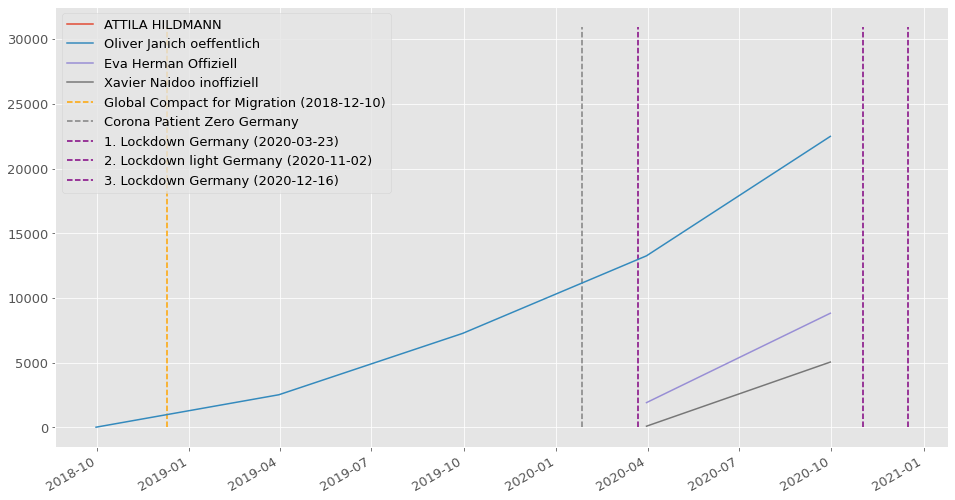

In [86]:
if(C_SHORT_RUN == False):
    drawTimePlot(
        filePathList = list(dfInputFiles[dfInputFiles.inputLabel == "dataSet0"].inputPath),
        outputFilename = "time-plot-dataSet0.svg",
        highlightWords = [],
        configFrequency=C_TIME_PLOT_FREQ
    )

[Stopwatch started >>Time Plot<<]
[Stopwatch stopped >>Time Plot<< (5.161s)]


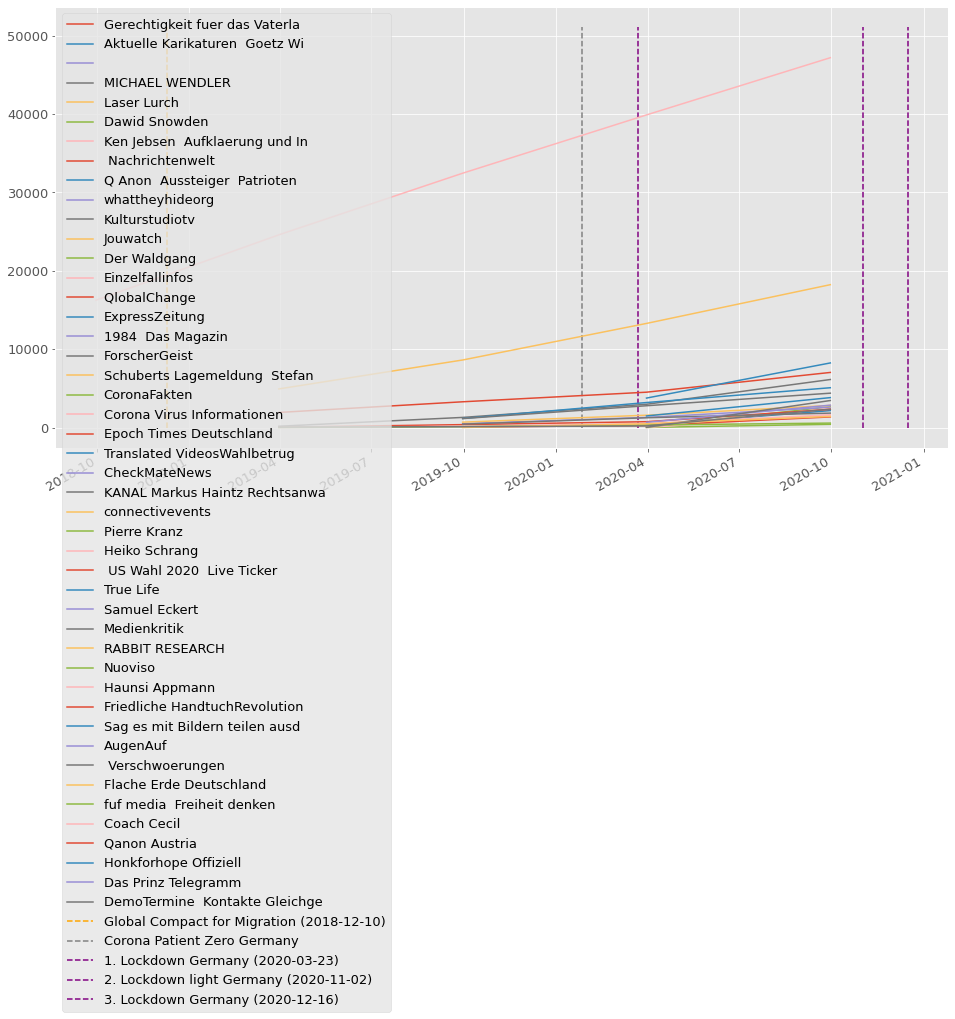

In [87]:
if(C_SHORT_RUN == False):
    if("dataSet1" in C_LOAD_DATASETS):
        drawTimePlot(
            filePathList = list(dfInputFiles[dfInputFiles.inputLabel == "dataSet1"].inputPath),
            outputFilename = "time-plot-dataSet1.svg",
            highlightWords = [],
            configFrequency=C_TIME_PLOT_FREQ
        )

[Stopwatch started >>Time Plot<<]
[Stopwatch stopped >>Time Plot<< (7.882s)]


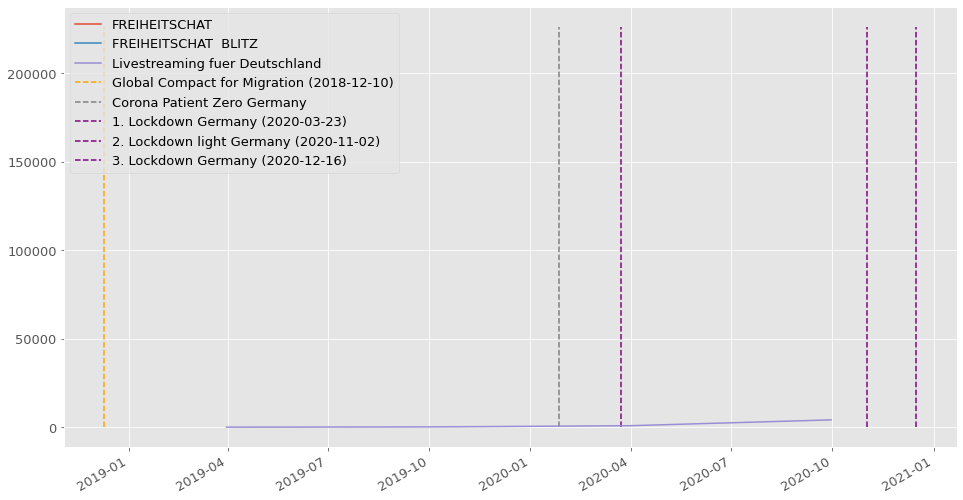

In [88]:
if(C_SHORT_RUN == False):
    if("dataSet1a" in C_LOAD_DATASETS):
        drawTimePlot(
            filePathList = list(dfInputFiles[dfInputFiles.inputLabel == "dataSet1a"].inputPath),
            outputFilename = "time-plot-dataSet1a.svg",
            highlightWords = [],
            configFrequency=C_TIME_PLOT_FREQ
        )

[Stopwatch started >>Time Plot<<]
[Stopwatch stopped >>Time Plot<< (2.284s)]


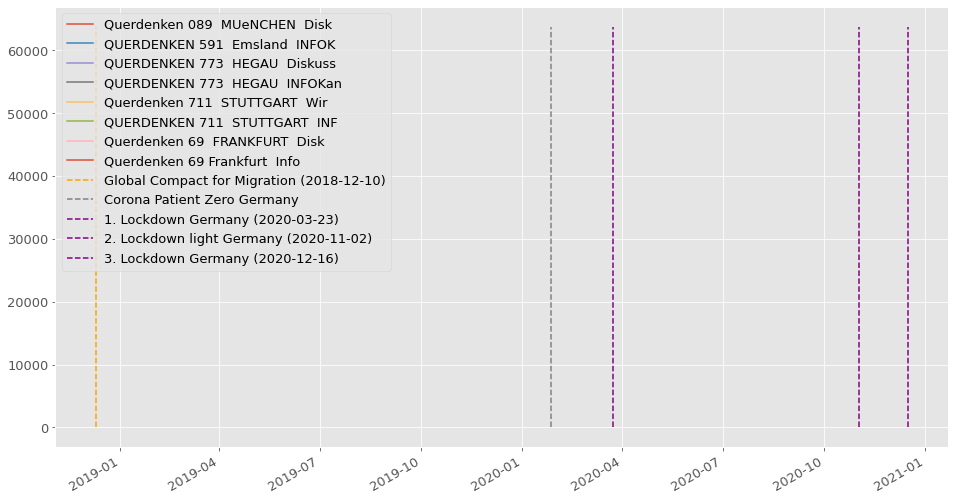

In [89]:
if(C_SHORT_RUN == False):
    if("dataSet2" in C_LOAD_DATASETS):
        drawTimePlot(
            filePathList = list(dfInputFiles[dfInputFiles.inputLabel == "dataSet2"].inputPath),
            outputFilename = "time-plot-dataSet2.svg",
            highlightWords = [],
            configFrequency=C_TIME_PLOT_FREQ
        )

#### Word Tracer

In [90]:
# https://www.bundestag.de/parlament/plenum/sitzverteilung_19wp
highlightwords = ["cdu", "spd", "afd", "fdp", "linke", "gruenen", "merkel"]

[Stopwatch started >>Time Plot<<]
[Stopwatch stopped >>Time Plot<< (4.694s)]


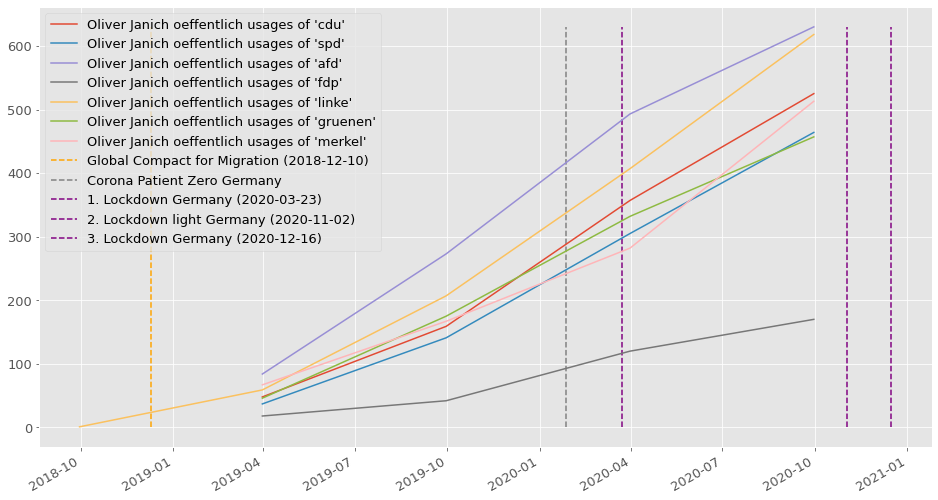

In [91]:
if(C_SHORT_RUN == False):
    drawTimePlot(
        filePathList = list(["DS-05-01-2021/ChatExport_2021-01-05-janich"]),
        outputFilename = "word-tracer-oliver-janich.svg",
        highlightWords = highlightwords,
        configFrequency=C_TIME_PLOT_FREQ
    )

[Stopwatch started >>Time Plot<<]
[Stopwatch stopped >>Time Plot<< (3.362s)]


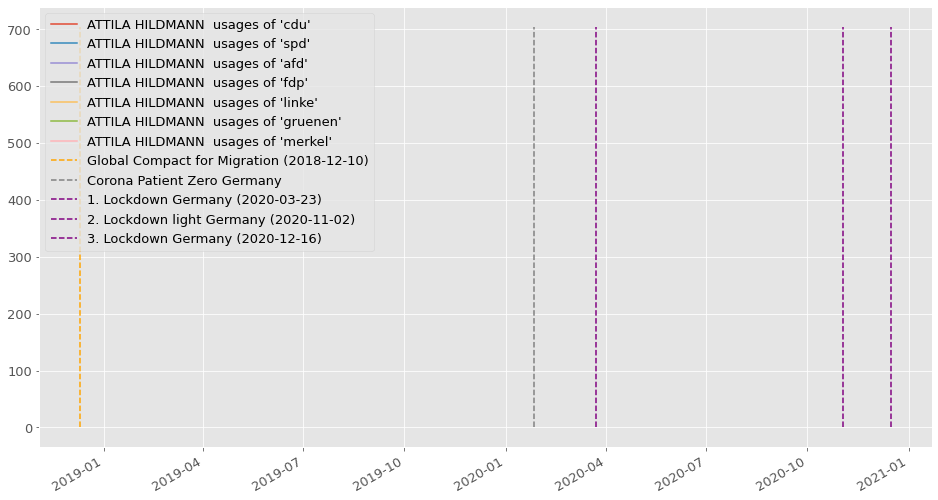

In [92]:
if(C_SHORT_RUN == False):
    drawTimePlot(
        filePathList = list(["DS-05-01-2021/ChatExport_2021-01-05-hildmann"]),
        outputFilename = "word-tracer-attila-hildmann.svg",
        highlightWords = highlightwords,
        configFrequency=C_TIME_PLOT_FREQ
    )

[Stopwatch started >>Time Plot<<]
[Stopwatch stopped >>Time Plot<< (2.763s)]


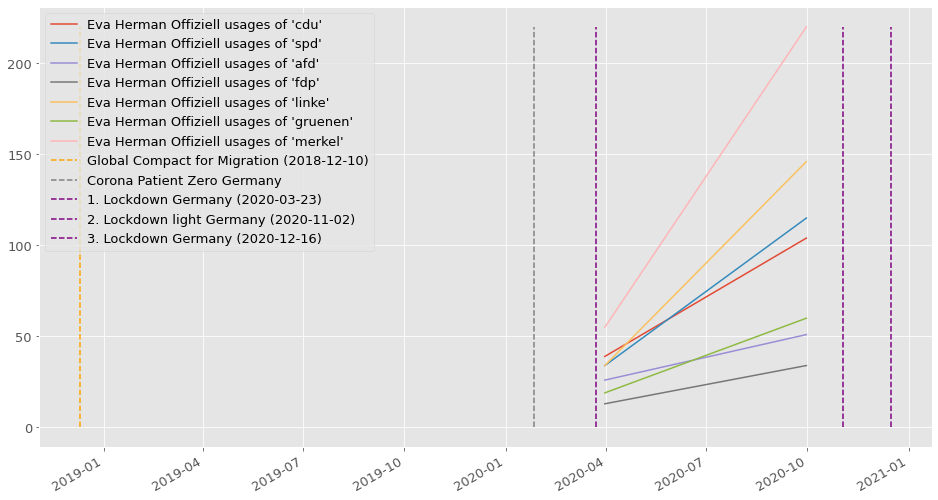

In [93]:
if(C_SHORT_RUN == False):
    drawTimePlot(
        filePathList = list(["DS-05-01-2021/ChatExport_2021-01-05-evaherman"]),
        outputFilename = "word-tracer-eva-herman.svg",
        highlightWords = highlightwords,
        configFrequency=C_TIME_PLOT_FREQ
    )

[Stopwatch started >>Time Plot<<]
[Stopwatch stopped >>Time Plot<< (1.334s)]


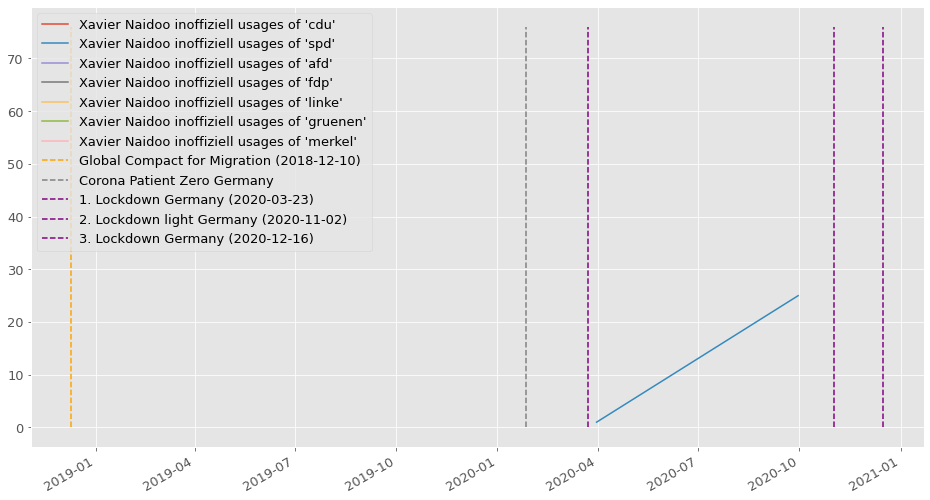

In [94]:
if(C_SHORT_RUN == False):
    drawTimePlot(
        filePathList = list(["DS-05-01-2021/ChatExport_2021-01-05-xavier"]),
        outputFilename = "word-tracer-xavier-naidoo.svg",
        highlightWords = highlightwords,
        configFrequency=C_TIME_PLOT_FREQ
    )

## Text Mining

### Verwertbarkeit von Textnachrichten

In [95]:
def removeTextLengthOutliersFromDataFrame(df, interval, maxTextLength):
    df = df.copy()
    df = df[df.ftTdTextLength < maxTextLength]
    return df[np.abs(df.ftTdTextLength-df.ftTdTextLength.mean()) <= (interval*df.ftTdTextLength.std())]

In [96]:
# param outputFilename set "" == no output file
def textLengthHistPlotter(outputFilename):
    dfMessages = dfAllDataMessages.copy()
    print("Number of all messages:\t\t\t\t\t\t" + str(len(dfMessages.index)))

    dfMessages = dfMessages[dfMessages.ftQrIsValidText == True]
    print("Number of valid text messages:\t\t\t\t\t" + str(len(dfMessages.index)))

    dfMessagesOT = removeTextLengthOutliersFromDataFrame(
        dfMessages,
        interval = 3,               #Default is 3
        maxTextLength = 999999999   #TODO: Maybe enable max text length
        )
    print("Number of valid text messages (after outliers filtering):\t" + str(len(dfMessagesOT.index)))

    print()
    print("Text Length Hist (after normalization)")
    plt.figure(figsize=(16,9))
    _ = dfMessagesOT.ftTdTextLength.hist(bins=20)
    plt.title('Histogram Text Length (after normalization - global) (20 bins)')

    if(outputFilename != ""):
        plt.savefig(dir_var_output + outputFilename)

Number of all messages:						1088996
Number of valid text messages:					741277
Number of valid text messages (after outliers filtering):	725684

Text Length Hist (after normalization)


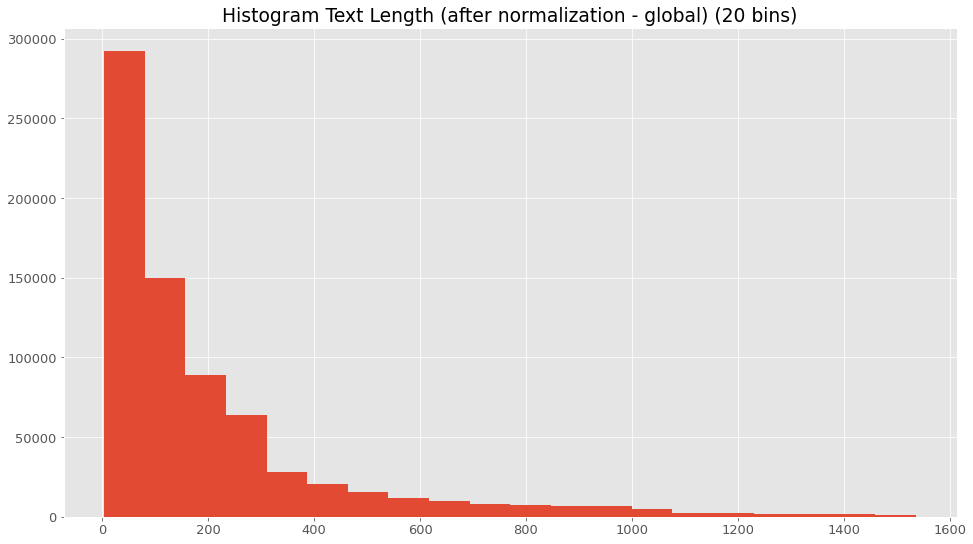

In [97]:
textLengthHistPlotter(outputFilename = "meta-text-length-hist.svg")

### Word Clouds

- ``targetDataFrame``: DataFrame
- ``outputFilename``: filename in outputdir (set "" == no output file)
- ``filterList``: Exclude list
- ``flagShow``: Set true == show wordcloud
- ``configPlotWidth``: e.g. 1920
- ``configPlotHeight``: e.g. 1080

In [98]:
# param rowID e.g. ftTdSafeText
def gloGenerateTextFromChat(df, rowID):
    df = df.copy()
    df = df[df.ftQrIsValidText == True]
    
    # Iterate over text (global text from group)
    textList = []
    for index, row in df.iterrows():
        textList.append(" " + row[rowID])
        
    textString = ''.join(textList)

    return textString

In [99]:
def generateWordCloud(targetDataFrame, outputFilename, filterList, flagShow, configPlotWidth, configPlotHeight):
    
    dfMessages = targetDataFrame.copy()
    
    textString = gloGenerateTextFromChat(dfMessages, rowID="ftTdSafeText")
    
    stopWordsList = gloGetStopWordsList(filterList)
    
    # Generate word cloud and save it to file
    wordcloud = WordCloud(
                background_color="white",
                width=configPlotWidth,
                height=configPlotHeight,
                stopwords=stopWordsList
            ).generate(textString)

    if(outputFilename != ""):
        wordcloud.to_file(dir_var_output + outputFilename)
    
    if(flagShow):
        # Show top 20
        print()
        print("Top 20 occ:\n" + str(pd.Series(wordcloud.words_).head(20)))
        print()
        
        # Show word cloud
        print("- Start generate figure")
        plt.figure(figsize=(14, 14))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.show()

#### Über gesamten Chat (DataSet0)


Top 20 occ:
Deutschland    1.000000
Menschen       0.871322
Video          0.805806
Polizei        0.622989
Trump          0.598666
Corona         0.541781
Berlin         0.467242
Prozent        0.420557
Fall           0.402511
Welt           0.383288
Kinder         0.365634
AfD            0.362495
kommt          0.344056
deutschen      0.340526
Jahr           0.324441
seit           0.303648
sogar          0.300902
dafuer         0.299725
worden         0.296195
sehen          0.295018
dtype: float64

- Start generate figure


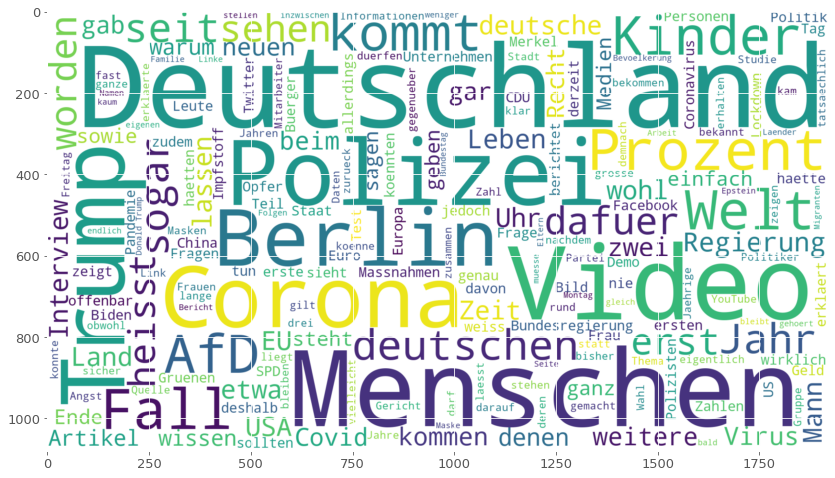

In [100]:
# Oliver Janich öffentlich (public_channel - dataSet0)
generateWordCloud(
    dictMessages["DS-05-01-2021/ChatExport_2021-01-05-janich"],
    "wordcloud-oliver-janich.png",
    ["bitte", "danke", "dabei", "natuerlich", "gut", "gerade", "gehen", "möglich", "bereit", "ja", "wer", "wegen", "heute", "macht", "muessen", "viele", "geht", "sagte", "gibt", "neue", "sollen", "laut", "ab", "sagt", "bereits", "seien", "waere", "U"],
    flagShow = True,
    configPlotWidth = 1920,
    configPlotHeight = 1080
)


Top 20 occ:
Deutschland        1.000000
Menschen           0.658382
Merkel             0.587520
Corona             0.496563
NWO                0.442623
Video              0.386039
Deutschen          0.386039
Korona             0.377049
Gate               0.377049
kommt              0.337388
China              0.326811
Freiheit           0.312533
Demo               0.309360
einfach            0.303543
Welt               0.282919
TEILEN             0.280804
ATTILA HILDMANN    0.279746
Berlin             0.273400
deutsche           0.270756
CHAT BEITRETEN     0.270227
dtype: float64

- Start generate figure


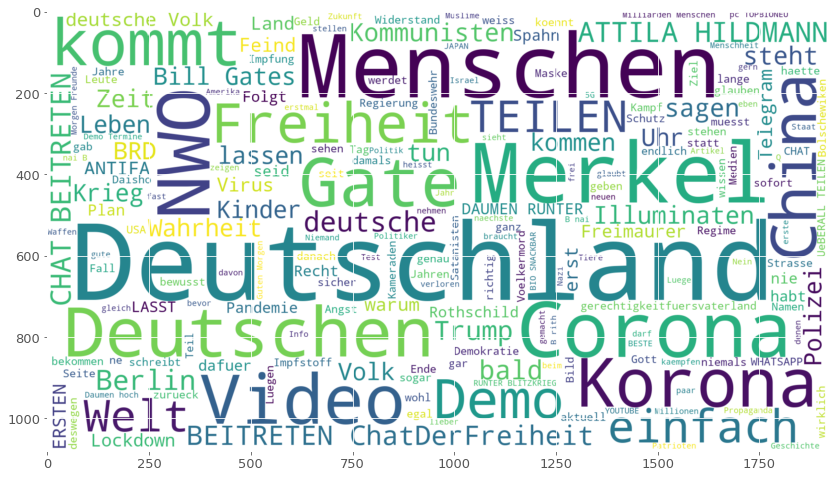

In [101]:
# ATTILA HILDMANN OFFICIAL (public_channel - dataSet0)
if(C_SHORT_RUN == False):
    generateWordCloud(
        dictMessages["DS-05-01-2021/ChatExport_2021-01-05-hildmann"],
        "wordcloud-attila-hildmann.png",
        ["bitte", "danke", "Wolf", "folgen", "folg", "ATTILAHILDMANN", "heute", "dabei", "natuerlich", "gut", "gerade", "gehen", "möglich", "bereit", "ja", "wer", "wegen", "heute", "macht", "muessen", "viele", "geht", "sagte", "gibt", "neue", "sollen", "laut", "ab", "sagt", "bereits", "seien", "waere", "U"],
        flagShow = True,
        configPlotWidth = 1920,
        configPlotHeight = 1080
    )


Top 20 occ:
Menschen       1.000000
Deutschland    0.623908
Corona         0.517241
Welt           0.451034
Zeit           0.402759
Liebe Eva      0.400460
Kinder         0.393563
Video          0.380690
Leben          0.375632
Trump          0.326897
Coronavirus    0.297931
Virus          0.289655
USA            0.289655
China          0.286437
Zuschrift      0.270805
einfach        0.262989
moechte        0.252874
Berlin         0.251034
Licht          0.248276
Covid          0.245977
dtype: float64

- Start generate figure


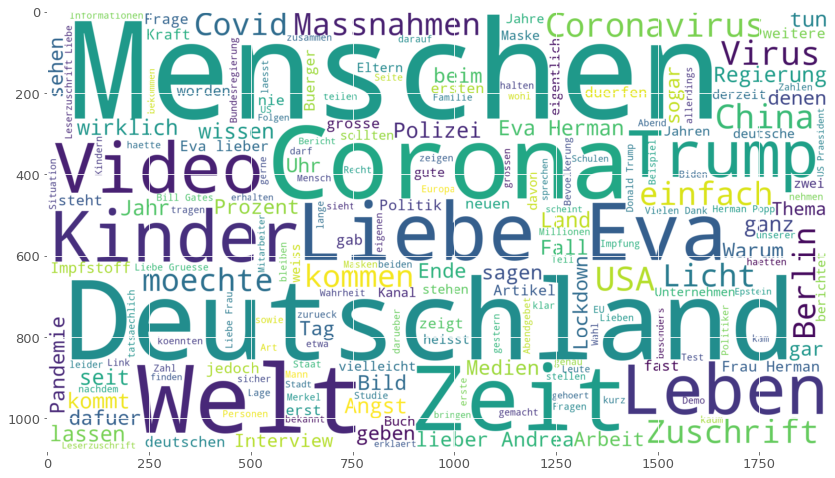

In [102]:
# Eva Herman Offiziell (public_channel - dataSet0)
if(C_SHORT_RUN == False):
    generateWordCloud(
        dictMessages["DS-05-01-2021/ChatExport_2021-01-05-evaherman"],
        "wordcloud-eva-herman.png",
        ["bitte", "danke", "heute", "dabei", "natuerlich", "gut", "gerade", "gehen", "möglich", "bereit", "ja", "wer", "wegen", "heute", "macht", "muessen", "viele", "geht", "sagte", "gibt", "neue", "sollen", "laut", "ab", "sagt", "bereits", "seien", "waere", "U"],
        flagShow = True,
        configPlotWidth = 1920,
        configPlotHeight = 1080
    )


Top 20 occ:
oneLove                        1.000000
Menschen                       0.318105
Deutschland                    0.219120
Video                          0.186548
Wahrheit                       0.176819
Liebe                          0.159052
Kinder                         0.156091
Corona                         0.152707
politische bildersprueche      0.146785
Kanaele                        0.127750
Zeit                           0.123096
Werbegruppe deutschsprachig    0.116328
Welt                           0.115482
drin politische                0.114213
Berlin                         0.113367
Warum                          0.109983
einfach                        0.109137
Leben                          0.107445
Gute                           0.102792
kommt                          0.101523
dtype: float64

- Start generate figure


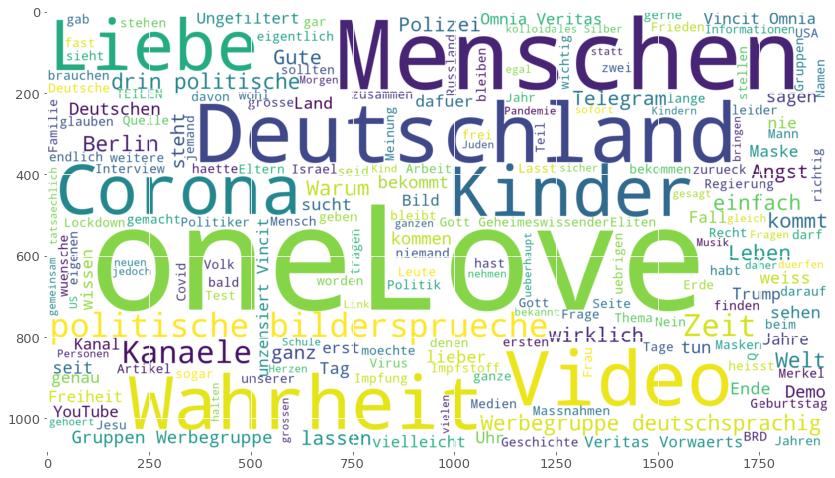

In [103]:
# Xavier Naidoo (public_channel - dataSet0)
if(C_SHORT_RUN == False):
    generateWordCloud(
        dictMessages["DS-05-01-2021/ChatExport_2021-01-05-xavier"],
        "wordcloud-xavier-naidoo.png",
        ["bitte", "danke", "xavier", "naidoo", "heute", "dabei", "natuerlich", "gut", "gerade", "gehen", "möglich", "bereit", "ja", "wer", "wegen", "heute", "macht", "muessen", "viele", "geht", "sagte", "gibt", "neue", "sollen", "laut", "ab", "sagt", "bereits", "seien", "waere", "U"],
        flagShow = True,
        configPlotWidth = 1920,
        configPlotHeight = 1080
    )


Top 20 occ:
Demo           1.000000
Polizei        0.852941
Berlin         0.735294
Uhr            0.676471
Maske          0.617647
Querdenken     0.588235
Corona         0.558824
Video          0.558824
Versammlung    0.470588
Flyer          0.441176
Eltern         0.441176
Schule         0.411765
Dr             0.411765
Attest         0.411765
kommen         0.382353
Masken         0.382353
Samstag        0.352941
kommt          0.352941
darauf         0.352941
Menschen       0.352941
dtype: float64

- Start generate figure


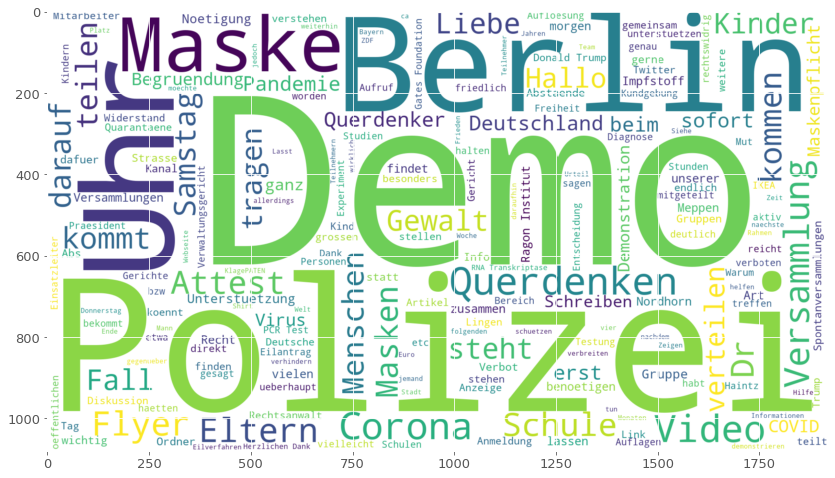

In [104]:
if(C_SHORT_RUN == False):
    if("dataSet2" in C_LOAD_DATASETS):
        generateWordCloud(
            dictMessages["DS-13-01-2021/ChatExport_2021-01-13-querdenken591Info"],
            "wordcloud-querdenken-591-info.png",
            ["bitte", "danke", "heute", "dabei", "natuerlich", "gut", "gerade", "gehen", "möglich", "bereit", "ja", "wer", "wegen", "heute", "macht", "muessen", "viele", "geht", "sagte", "gibt", "neue", "sollen", "laut", "ab", "sagt", "bereits", "seien", "waere", "U"],
            flagShow = True,
            configPlotWidth = 1920,
            configPlotHeight = 1080
        )

#### Zeitlicher Verlauf

##### Bestimmter Zeitraum aus DataFrame und Perioden berechnen

In [105]:
def extractTimePeriodDataFrame(df, timeStart, timeStop):

    #print("- Got Start " + str(timeStart) + " and Stop " + str(timeStop))

    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    
    dfNew = df[df.date <= timeStop]
    dfNew = dfNew[dfNew.date >= timeStart]

    dfNew = dfNew.set_index("date")
    dfNew = dfNew.sort_index()

    return dfNew

##### Perioden berechnen

In [106]:
def generateWCPeriod():
    return list(pd.date_range( #m/d/y
            start='1/1/2018',
            end='2/1/2021',
            #freq="W-MON",
            freq="1M"
            ))

##### Wrapper

- ``fP``: filePath
- ``label``: e.g. chatName
- ``filterList``: additional stopWords

In [107]:
def generateWordCloudAuto(fP, label, filterList):

    gloStartStopwatch("Generate World Cloud Auto >>" + fP + "<<")

    periods = generateWCPeriod()

    dictSaved = {}

    prevStart = periods[0]

    for period in periods:

        stop = period

        e = extractTimePeriodDataFrame(dictMessages[fP], timeStart = prevStart, timeStop = stop)

        if(prevStart != stop and len(e.index) > 0):
            fileName = "autoWordCloud/" + queryChatName(fP) + "-" + str(prevStart) + "-" + str(stop) + ".png"
            generateWordCloud(
                e,
                fileName,
                filterList,
                flagShow = False,
                configPlotWidth = 1280,
                configPlotHeight = 720
            )
            #print("- Save file " + fileName)
            dictSaved[fileName] = str(prevStart) + " - " + str(stop)

        """
        else:
            print("- Start and Stop equal or no message found")
        """

        prevStart = stop

    gloWriteDictToFile("auto-wordcloud-" + label + ".csv", dictSaved)

    gloStopStopwatch("Generate World Cloud Auto >>" + fP + "<<")

##### Anwenden auf DataSet0

In [108]:
if(C_SHORT_RUN == False):
    generateWordCloudAuto(
        fP = "DS-05-01-2021/ChatExport_2021-01-05-janich",
        label = "oliver-janich",
        filterList = []
    )

[Stopwatch started >>Generate World Cloud Auto >>DS-05-01-2021/ChatExport_2021-01-05-janich<<<<]
[Stopwatch stopped >>Generate World Cloud Auto >>DS-05-01-2021/ChatExport_2021-01-05-janich<<<< (56.349s)]


In [109]:
if(C_SHORT_RUN == False):
    generateWordCloudAuto(
        fP = "DS-05-01-2021/ChatExport_2021-01-05-hildmann",
        label = "attila-hildmann",
        filterList = []
    )

[Stopwatch started >>Generate World Cloud Auto >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<<]
[Stopwatch stopped >>Generate World Cloud Auto >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<< (21.408s)]


In [110]:
if(C_SHORT_RUN == False):
    generateWordCloudAuto(
        fP = "DS-05-01-2021/ChatExport_2021-01-05-evaherman",
        label = "eva-herman",
        filterList = []
    )

[Stopwatch started >>Generate World Cloud Auto >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<<<]
[Stopwatch stopped >>Generate World Cloud Auto >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<<< (32.196s)]


In [111]:
if(C_SHORT_RUN == False):
    generateWordCloudAuto(
        fP = "DS-05-01-2021/ChatExport_2021-01-05-xavier",
        label = "xavier-naidoo",
        filterList = []
    )

[Stopwatch started >>Generate World Cloud Auto >>DS-05-01-2021/ChatExport_2021-01-05-xavier<<<<]
[Stopwatch stopped >>Generate World Cloud Auto >>DS-05-01-2021/ChatExport_2021-01-05-xavier<<<< (19.420s)]


### N grams

#### Text zu N grams

In [112]:
def generateNGram(text, n):
    # https://albertauyeung.github.io/2018/06/03/generating-ngrams.html
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    tokens = [token for token in text.split(" ") if token != ""]
    
    return list(ngrams(tokens, n))

##### Beispiele (1-3)

In [113]:
sampleText = "Mir geht es heute gut!"
sampleText

'Mir geht es heute gut!'

In [114]:
generateNGram(sampleText, 1)

[('mir',), ('geht',), ('es',), ('heute',), ('gut',)]

In [115]:
generateNGram(sampleText, 2)

[('mir', 'geht'), ('geht', 'es'), ('es', 'heute'), ('heute', 'gut')]

In [116]:
generateNGram(sampleText, 3)

[('mir', 'geht', 'es'), ('geht', 'es', 'heute'), ('es', 'heute', 'gut')]

#### Top N grams pro Chat

##### Implementierung

In [117]:
def generateNGramChat(fP, n, mostCommon):
    return Counter(
        generateNGram(
            gloGenerateTextFromChat(dictMessages[fP], rowID="ftTdSafeText"),
            n = n
        )
    ).most_common(mostCommon)

In [118]:
def generateNGramAuto(filePathList, n, mostCommon):
    for fP in filePathList:

        print()
        print("Analyse now >>" + fP + "<<")

        c = generateNGramChat(
            fP,
            n = n,
            mostCommon = mostCommon
        )

        print ("\n".join(map(str, c)))

##### Angwendet auf DataSet 0 (später: Identifizierung von Autoren)

In [119]:
generateNGramAuto(
    dfInputFiles[dfInputFiles.inputLabel == "dataSet0"].inputPath,
    n = 1,
    mostCommon = 10
)


Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<
(('die',), 19991)
(('und',), 19245)
(('der',), 14186)
(('in',), 8755)
(('sie',), 8360)
(('ist',), 7404)
(('das',), 7267)
(('attilahildmann',), 6421)
(('es',), 5942)
(('mit',), 5496)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-janich<<
(('die',), 51629)
(('der',), 45032)
(('und',), 32527)
(('in',), 26898)
(('das',), 18638)
(('von',), 15942)
(('zu',), 15564)
(('den',), 14732)
(('ist',), 13516)
(('nicht',), 12851)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<
(('die',), 35061)
(('und',), 29809)
(('der',), 28652)
(('in',), 18662)
(('das',), 13121)
(('zu',), 11909)
(('von',), 11014)
(('den',), 9992)
(('ist',), 9797)
(('es',), 9647)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-xavier<<
(('die',), 9605)
(('und',), 9102)
(('der',), 7289)
(('in',), 4755)
(('das',), 4186)
(('ist',), 3860)
(('es',), 3364)
(('xavier',), 3312)
(('nicht',), 3269)
(('zu',), 3262)


In [120]:
generateNGramAuto(
    dfInputFiles[dfInputFiles.inputLabel == "dataSet0"].inputPath,
    n = 2,
    mostCommon = 10
)


Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<
(('folgen', 'attilahildmann'), 2066)
(('dem', 'wolf'), 1709)
(('wolf', 'attilahildmann'), 1708)
(('folg', 'dem'), 1707)
(('in', 'der'), 1339)
(('und', 'die'), 998)
(('fuer', 'die'), 806)
(('in', 'den'), 805)
(('es', 'ist'), 797)
(('auf', 'die'), 563)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-janich<<
(('in', 'der'), 4109)
(('in', 'den'), 2352)
(('fuer', 'die'), 2182)
(('dass', 'die'), 1621)
(('und', 'die'), 1611)
(('von', 'der'), 1368)
(('auf', 'die'), 1338)
(('mit', 'dem'), 1265)
(('mit', 'der'), 1251)
(('in', 'deutschland'), 1212)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<
(('in', 'der'), 3068)
(('in', 'den'), 1785)
(('fuer', 'die'), 1508)
(('und', 'die'), 1284)
(('auf', 'die'), 1084)
(('mit', 'dem'), 1001)
(('dass', 'die'), 980)
(('von', 'der'), 952)
(('ueber', 'die'), 876)
(('liebe', 'eva'), 871)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-xavier<<
(('xavier', 'naidoo'), 2876)
(('onelo

In [121]:
generateNGramAuto(
    dfInputFiles[dfInputFiles.inputLabel == "dataSet0"].inputPath,
    n = 3,
    mostCommon = 10
)


Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<
(('dem', 'wolf', 'attilahildmann'), 1708)
(('folg', 'dem', 'wolf'), 1707)
(('attilahildmann', 'chat', 'beitreten'), 505)
(('wolf', 'attilahildmann', 'chat'), 501)
(('chat', 'beitreten', 'chatderfreiheit'), 499)
(('das', 'deutsche', 'volk'), 340)
(('teilen', 'folgen', 'attilahildmann'), 326)
(('folgt', 'uns', 'auf'), 211)
(('uns', 'auf', 'gerechtigkeitfuersvaterland'), 207)
(('auf', 'die', 'strasse'), 184)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-janich<<
(('in', 'den', 'usa'), 247)
(('im', 'premium', 'kanal'), 203)
(('kommentierung', 'meiner', 'videos'), 198)
(('und', 'kommentierung', 'meiner'), 194)
(('meiner', 'videos', 'im'), 194)
(('videos', 'im', 'premium'), 194)
(('fruehzugriff', 'und', 'kommentierung'), 192)
(('sars', 'cov', '2'), 190)
(('die', 'zahl', 'der'), 181)
(('exklusive', 'inhalte', 'fruehzugriff'), 181)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<
(('eva', 'lieber', 'andreas'), 384

##### Angwendet auf DataSet 0 (Muster Erkennung)

In [122]:
generateNGramAuto(
    dfInputFiles[dfInputFiles.inputLabel == "dataSet0"].inputPath,
    n = 8,
    mostCommon = 10
)


Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<
(('5', 'gutschein', 'fuer', 'alle', 'die', 'zum', 'ersten', 'mal'), 148)
(('gutschein', 'fuer', 'alle', 'die', 'zum', 'ersten', 'mal', 'bei'), 148)
(('fuer', 'alle', 'die', 'zum', 'ersten', 'mal', 'bei', 'mir'), 148)
(('alle', 'die', 'zum', 'ersten', 'mal', 'bei', 'mir', 'bestellen'), 128)
(('die', 'zum', 'ersten', 'mal', 'bei', 'mir', 'bestellen', 'pc'), 125)
(('zum', 'ersten', 'mal', 'bei', 'mir', 'bestellen', 'pc', 'topbioneu'), 125)
(('echter', 'matcha', 'kommt', 'aus', 'japan', 'der', 'beste', 'ist'), 91)
(('matcha', 'kommt', 'aus', 'japan', 'der', 'beste', 'ist', 'von'), 91)
(('kommt', 'aus', 'japan', 'der', 'beste', 'ist', 'von', 'attila'), 91)
(('aus', 'japan', 'der', 'beste', 'ist', 'von', 'attila', 'hildmann'), 91)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-janich<<
(('fruehzugriff', 'und', 'kommentierung', 'meiner', 'videos', 'im', 'premium', 'kanal'), 187)
(('exklusive', 'inhalte', 'fruehzugriff', 'und', 

### POS-Tagging - Eigennamen

#### Implementierung

In [123]:
# param outputFilename, if "" - no output
def plotFreqNouns(inputText, outputFilename, mostCommon, flagRemoveStopwords):
    # https://textmining.wp.hs-hannover.de/Preprocessing.html
    nouns = []
    sentences_tok = [nltk.tokenize.word_tokenize(sent) for sent in getTokenFromText(inputText)]

    for sent in sentences_tok:
        tags = hanoverTagger.tag_sent(sent) 
        nouns_from_sent = [lemma for (word,lemma,pos) in tags if pos == "NE"] # pos == "NN" or 
        nouns.extend(nouns_from_sent)

    pNouns = list()

    if(flagRemoveStopwords):

        print("- Warn: remove stopWords")
        stopWords = gloGetStopWordsList(filterList = list())
        for n in nouns:
            if n.lower() not in stopWords:
                pNouns.append(n)

    else:
        pNouns = nouns

    # Thank you https://stackoverflow.com/questions/52908305/how-to-save-a-nltk-freqdist-plot
    fig = plt.figure(figsize = (16,9))
    plt.gcf().subplots_adjust(bottom=0.15)

    fdist = nltk.FreqDist(pNouns)    

    fdist.plot(mostCommon,cumulative=False)

    _ = plt.show()

    if(outputFilename != ""):
        fig.savefig(dir_var_output + outputFilename, bbox_inches="tight")

#### Über einen gesamten Chat

In [124]:
def generateFreqNounsPlot(fP, mostCommon, outputFilename):

    gloStartStopwatch("Generate text")
    df = dictMessages[fP].copy()
    inputText = gloGenerateTextFromChat(df, "ftTdCleanText")
    gloStopStopwatch("Generate text")

    gloStartStopwatch("Process data")
    plotFreqNouns(inputText, outputFilename=outputFilename, mostCommon=mostCommon, flagRemoveStopwords=True)
    gloStopStopwatch("Process data")

##### Angewendet auf DataSet0

[Stopwatch started >>Generate text<<]
[Stopwatch stopped >>Generate text<< (2.610s)]
[Stopwatch started >>Process data<<]
- Warn: remove stopWords


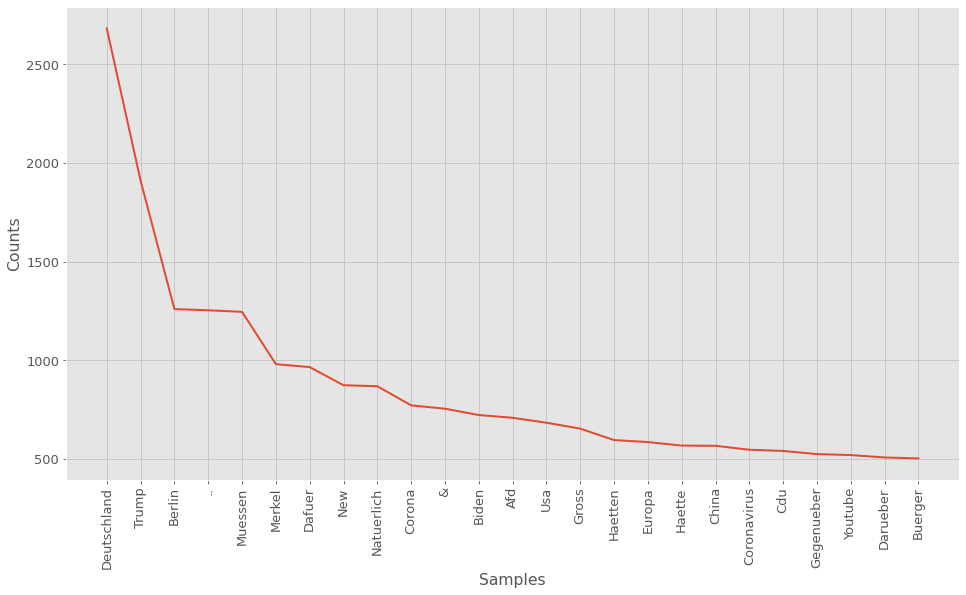

[Stopwatch stopped >>Process data<< (667.060s)]


In [125]:
if(C_SHORT_RUN == False):
    generateFreqNounsPlot("DS-05-01-2021/ChatExport_2021-01-05-janich", mostCommon=25, outputFilename = "freq-nouns-oliver-janich.svg")

[Stopwatch started >>Generate text<<]
[Stopwatch stopped >>Generate text<< (1.664s)]
[Stopwatch started >>Process data<<]
- Warn: remove stopWords


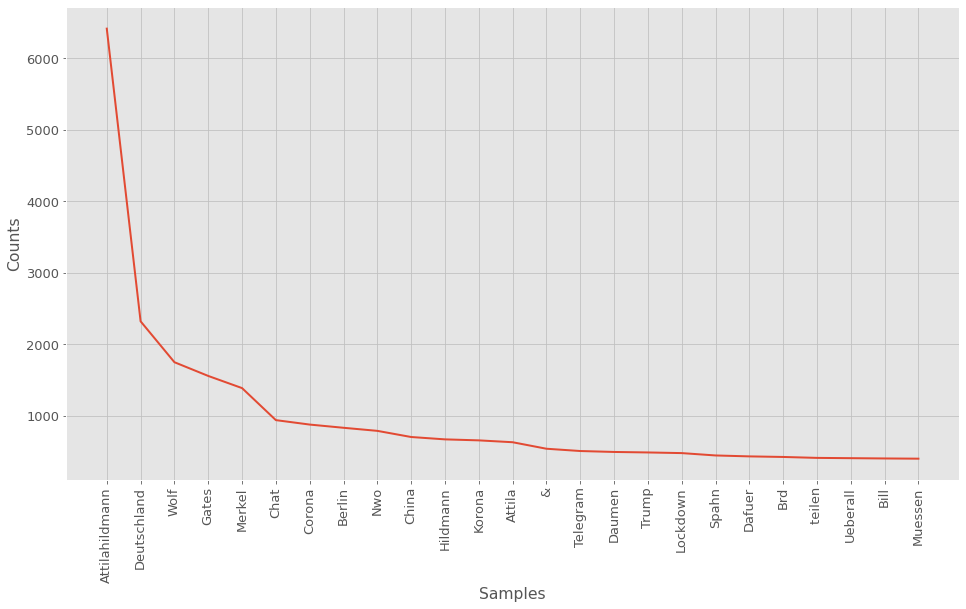

[Stopwatch stopped >>Process data<< (254.947s)]


In [126]:
if(C_SHORT_RUN == False):
    generateFreqNounsPlot("DS-05-01-2021/ChatExport_2021-01-05-hildmann", mostCommon=25, outputFilename = "freq-nouns-attila-hildmann.svg")

[Stopwatch started >>Generate text<<]
[Stopwatch stopped >>Generate text<< (1.017s)]
[Stopwatch started >>Process data<<]
- Warn: remove stopWords


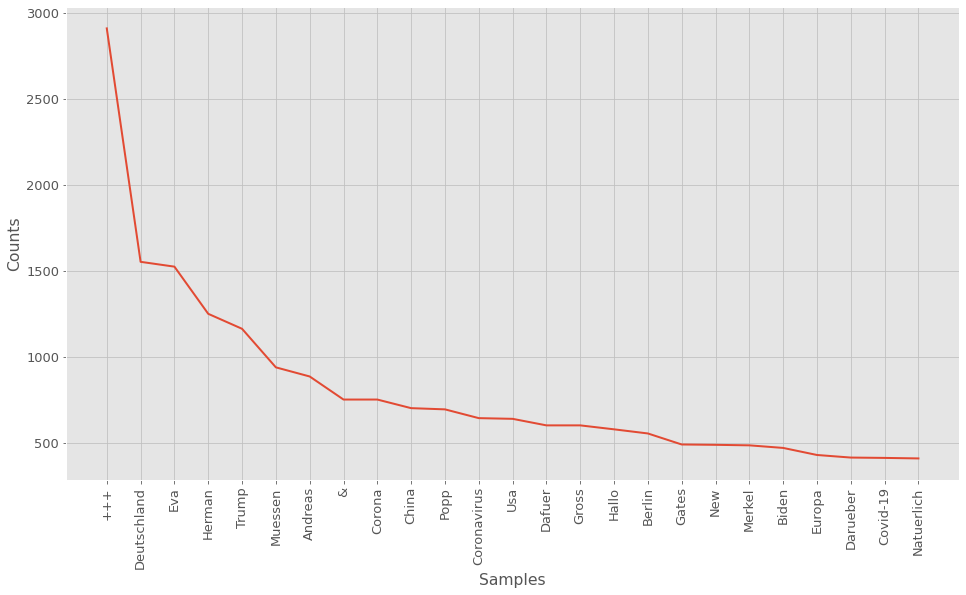

[Stopwatch stopped >>Process data<< (415.984s)]


In [127]:
if(C_SHORT_RUN == False):
    generateFreqNounsPlot("DS-05-01-2021/ChatExport_2021-01-05-evaherman", mostCommon=25, outputFilename = "freq-nouns-eva-herman.svg")

[Stopwatch started >>Generate text<<]
[Stopwatch stopped >>Generate text<< (0.632s)]
[Stopwatch started >>Process data<<]
- Warn: remove stopWords


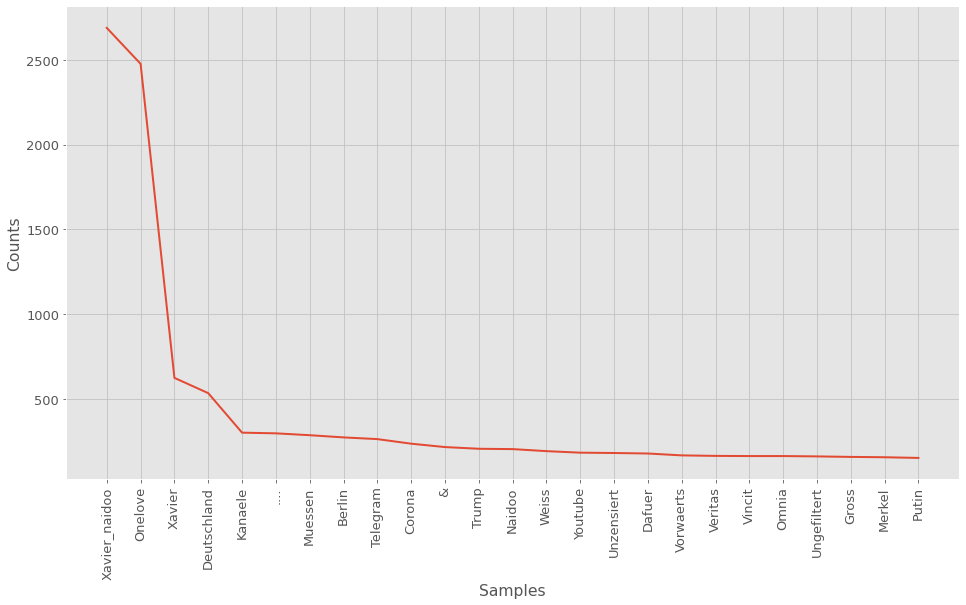

[Stopwatch stopped >>Process data<< (132.212s)]


In [128]:
if(C_SHORT_RUN == False):
    generateFreqNounsPlot("DS-05-01-2021/ChatExport_2021-01-05-xavier", mostCommon=25, outputFilename = "freq-nouns-xavier-naidoo.svg")

### Named-entity recognition (NER)

#### Beispiele

In [129]:
sampleText = "Hallo, mein Name ist Maximilian Mustermann und ich lebe in Deutschland in Europa."
sampleText

'Hallo, mein Name ist Maximilian Mustermann und ich lebe in Deutschland in Europa.'

In [130]:
processNerPipeline(sampleText, "ner-bert", 0)

{}

In [131]:
processNerPipeline(sampleText, "ner-xlm-roberta", 0)

{}

#### Angwendet auf DataSet0

In [132]:
def evalNerPipeline(pipelineKey, inputSelector, configTopN):

    if(inputSelector in C_TRANSFORMERS_DATASETS):
        
        filePaths = dfInputFiles[dfInputFiles.inputLabel == inputSelector].inputPath

        for fP in filePaths:
            
            gloStartStopwatch("Process now >>" + str(fP) + "<<")

            if(pipelineKey == "ftTrNerRoberta" or pipelineKey == "ftTrNerBert"):
                
                df = dictMessages[fP].copy()
                df = df[df.ftQrIsValidText == True]
                
                listPer     = list()
                listMisc    = list()
                listOrg     = list()
                listLoc     = list()

                for index, row in df.iterrows():

                    d = row[pipelineKey]
                    
                    listPer.extend(d["per"])
                    listMisc.extend(d["misc"])
                    listOrg.extend(d["org"])
                    listLoc.extend(d["loc"])

                print("- Top per -")
                print ("\n".join(map(str, Counter(listPer).most_common(configTopN))))
                print()

                print("- Top misc -")
                print ("\n".join(map(str, Counter(listMisc).most_common(configTopN))))
                print()

                print("- Top org -")
                print ("\n".join(map(str, Counter(listOrg).most_common(configTopN))))
                print()

                print("- Top loc -")
                print ("\n".join(map(str, Counter(listLoc).most_common(configTopN))))
                print()

            else:
                print("Error pipeline not found >>" + str(pipelineKey) + "<<")

            gloStopStopwatch("Process now >>" + str(fP) + "<<")

    else:
        print("Error data not found >>" + inputSelector + "<<")

In [133]:
evalNerPipeline("ftTrNerRoberta", "dataSet0", configTopN = 20)

[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<<]
- Top per -
('TTI', 6208)
('LAH', 6131)
('MAN', 6127)
('A', 6062)
('IL', 5935)
('D', 5846)
('N', 5744)
('▁Gates', 1063)
('▁Merkel', 1007)
('▁A', 411)
('▁Trump', 398)
('WO', 387)
('mann', 385)
('LD', 382)
('▁HI', 359)
('h', 354)
('▁Spa', 350)
('n', 336)
('LF', 330)
('TT', 329)

- Top misc -
('-', 2086)
('▁Corona', 845)
('▁DE', 838)
('UT', 717)
('▁deutsche', 649)
('WO', 443)
('S', 433)
('▁Deutschen', 409)
('▁N', 409)
('sche', 383)
('▁deutschen', 378)
('▁Deutsche', 336)
('D', 333)
('▁', 326)
('▁Kommun', 304)
('▁Bol', 283)
('▁BR', 222)
('na', 211)
('ed', 210)
('▁KOMMUN', 210)

- Top org -
('N', 782)
('▁N', 748)
('WO', 737)
('D', 717)
('MAN', 616)
('F', 602)
('rei', 545)
('heit', 545)
('Chat', 534)
('Der', 530)
('-', 469)
('IL', 365)
('▁B', 353)
('igkeit', 330)
('erland', 322)
('▁', 319)
('lumina', 319)
('gerecht', 318)
('ers', 316)
('fu', 314)

- Top loc -
('▁Deutschland', 1455)
('▁DE', 938)
('UT', 917)
('

In [134]:
evalNerPipeline("ftTrNerBert", "dataSet0", configTopN = 20)

[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<<]
- Top per -
('##d', 5375)
('##hil', 4756)
('att', 4409)
('##ila', 3966)
('@', 2726)
('merk', 1327)
('ga', 1131)
('hil', 673)
('##mann', 530)
('##tes', 463)
('##lf', 395)
('bill', 375)
('sp', 358)
('##el', 348)
('rot', 318)
('tr', 313)
('cor', 285)
('##hs', 274)
('wo', 267)
('ma', 226)

- Top misc -


- Top org -
('##d', 931)
('@', 721)
('nw', 685)
('att', 526)
('##ila', 436)
('##o', 415)
('##hil', 414)
('wo', 397)
('br', 387)
('##lf', 377)
('##mann', 336)
('bundes', 317)
('tel', 289)
('ch', 283)
('na', 280)
('##tu', 271)
('##at', 265)
('cor', 247)
('you', 247)
('##be', 215)

- Top loc -
('deutsch', 2202)
('##land', 1033)
('ber', 816)
('ch', 714)
('##lin', 639)
('##ina', 423)
('##ien', 243)
('kor', 209)
('japan', 188)
('usa', 185)
('europa', 176)
('israel', 170)
('amer', 169)
('##en', 158)
('##n', 150)
('##ika', 150)
('bayer', 145)
('##nk', 142)
('fra', 140)
('lei', 137)

[Stopwatch stopped >>Process no

### Sentiment analysis

In [135]:
def evalSenPipeline(pipelineKey, inputSelector, outputFilename, configRolling, configShowScatter):

    if(inputSelector in C_TRANSFORMERS_DATASETS):
        
        filePaths = dfInputFiles[dfInputFiles.inputLabel == inputSelector].inputPath

        plt.figure(figsize=(16, 9))

        for fP in filePaths:
            
            gloStartStopwatch("Process now >>" + str(fP) + "<<")

            if(pipelineKey == "sen-bert"):
                
                df = dictMessages[fP].copy()
                df = df[df.ftQrIsValidText == True]

                df["date"] = pd.to_datetime(df["date"])
                df = df.set_index("date")
                df = df.sort_index()

                # key = x = time / value = y = score
                dictData = {}

                for index, row in df.iterrows():
                    
                    date = index
                    score = row["ftTrSenBert"]

                    if(score != -1):
                        dictData[date] = score

                # Plot
                x,y = zip(*sorted(dictData.items()))
                
                df = pd.DataFrame(list(zip(x, y)), columns =['x', 'y'])

                df['rolling'] = df.y.rolling(configRolling).mean()

                sns.lineplot(data=df, x="x", y="rolling", label = queryChatName(fP))

                if(configShowScatter):
                    sns.scatterplot(data=df, x="x", y="y", label = queryChatName(fP), marker="+")

                plt.gcf().autofmt_xdate()

                # Add vlines
                vLineMin = 2
                vLineMax = 4

            elif(pipelineKey=="sentiment"):

                df = dictMessages[fP].copy()
                df = df[df.ftQrIsValidText == True]

                df["date"] = pd.to_datetime(df["date"])
                df = df.set_index("date")
                df = df.sort_index()

                # key = x = time / value = y = score
                dictData = {}

                for index, row in df.iterrows():
                    
                    date = index
                    retDict = row["ftSenTb"]

                    if(retDict != None):
                        polarity = retDict["polarity"]
                        dictData[date] = polarity

                # Plot
                x,y = zip(*sorted(dictData.items()))

                df = pd.DataFrame(list(zip(x, y)), columns =['x', 'y'])

                df['rolling'] = df.y.rolling(configRolling).mean()

                sns.lineplot(data=df, x="x", y="rolling", label = queryChatName(fP))

                if(configShowScatter):
                    sns.scatterplot(data=df, x="x", y="y", label = queryChatName(fP), marker="+")

                plt.gcf().autofmt_xdate()

                # Add vlines
                vLineMin = -0.05
                vLineMax = 0.175

            elif(pipelineKey=="subjectivity"):

                df = dictMessages[fP].copy()
                df = df[df.ftQrIsValidText == True]

                df["date"] = pd.to_datetime(df["date"])
                df = df.set_index("date")
                df = df.sort_index()

                # key = x = time / value = y = score
                dictData = {}

                for index, row in df.iterrows():
                    
                    date = index
                    retDict = row["ftSenTb"]

                    if(retDict != None):

                        subjectivity = retDict["subjectivity"]
                        dictData[date] = subjectivity

                # Plot
                x,y = zip(*sorted(dictData.items()))

                df = pd.DataFrame(list(zip(x, y)), columns =['x', 'y'])

                df['rolling'] = df.y.rolling(configRolling).mean()

                sns.lineplot(data=df, x="x", y="rolling", label = queryChatName(fP))

                if(configShowScatter):
                    sns.scatterplot(data=df, x="x", y="y", label = queryChatName(fP), marker="+")

                plt.gcf().autofmt_xdate()

                # Add vlines
                vLineMin = 0
                vLineMax = 0.10
                
            else:
                print("Error pipeline not found >>" + str(pipelineKey) + "<<")

            gloStopStopwatch("Process now >>" + str(fP) + "<<")

        # yy - mm - dd
        # TODO: Double check https://www.bundesgesundheitsministerium.de/coronavirus/chronik-coronavirus.html?stand=20210104
        plt.vlines(x = ["2018-12-10"], ymin=vLineMin, ymax=vLineMax, color="orange", ls='--', label="Global Compact for Migration (2018-12-10)")
        plt.vlines(x = ["2020-01-27"], ymin=vLineMin, ymax=vLineMax, color="grey", ls='--', label="Corona Patient Zero Germany")
        plt.vlines(x = ["2020-03-23"], ymin=vLineMin, ymax=vLineMax, color="purple", ls='--', label="1. Lockdown Germany (2020-03-23)")
        plt.vlines(x = ["2020-11-02"], ymin=vLineMin, ymax=vLineMax, color="purple", ls='--', label="2. Lockdown light Germany (2020-11-02)")
        plt.vlines(x = ["2020-12-16"], ymin=vLineMin, ymax=vLineMax, color="purple", ls='--', label="3. Lockdown Germany (2020-12-16)")

        _ = plt.legend()

        if(outputFilename != ""):
            plt.savefig(dir_var_output + outputFilename)

    else:
        print("Error data not found >>" + inputSelector + "<<")

#### TextBlob

##### Beispiele

In [136]:
print(str(processSentimentAnalysisPython("Heute ist ein toller Tag. Ich freue mich hier zu sein!")))

{'polarity': 0.5, 'subjectivity': 0.0}


In [137]:
print(str(processSentimentAnalysisPython("Heute war ein furchtbarer Tag. Ich hasse alles.")))

{'polarity': -0.5, 'subjectivity': 0.0}


##### DataSet0

Implementierung für beiden

Polarity

[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<<]
[Stopwatch stopped >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<< (2.437s)]
[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-janich<<<<]
[Stopwatch stopped >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-janich<<<< (3.270s)]
[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<<<]
[Stopwatch stopped >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<<< (1.574s)]
[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-xavier<<<<]
[Stopwatch stopped >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-xavier<<<< (0.980s)]


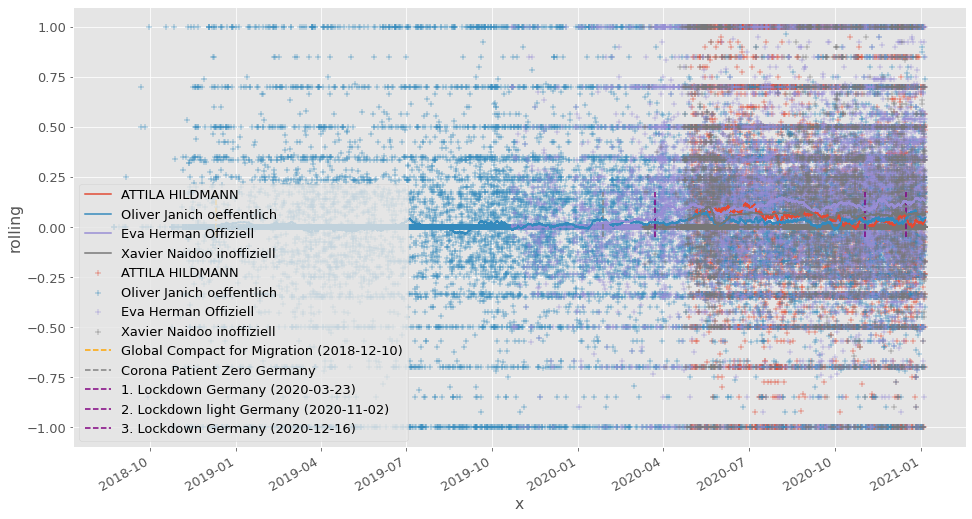

In [138]:
evalSenPipeline("sentiment", "dataSet0", outputFilename = "", configRolling = 600, configShowScatter = True)

[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<<]
[Stopwatch stopped >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<< (2.375s)]
[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-janich<<<<]
[Stopwatch stopped >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-janich<<<< (3.153s)]
[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<<<]
[Stopwatch stopped >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<<< (1.535s)]
[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-xavier<<<<]
[Stopwatch stopped >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-xavier<<<< (0.967s)]


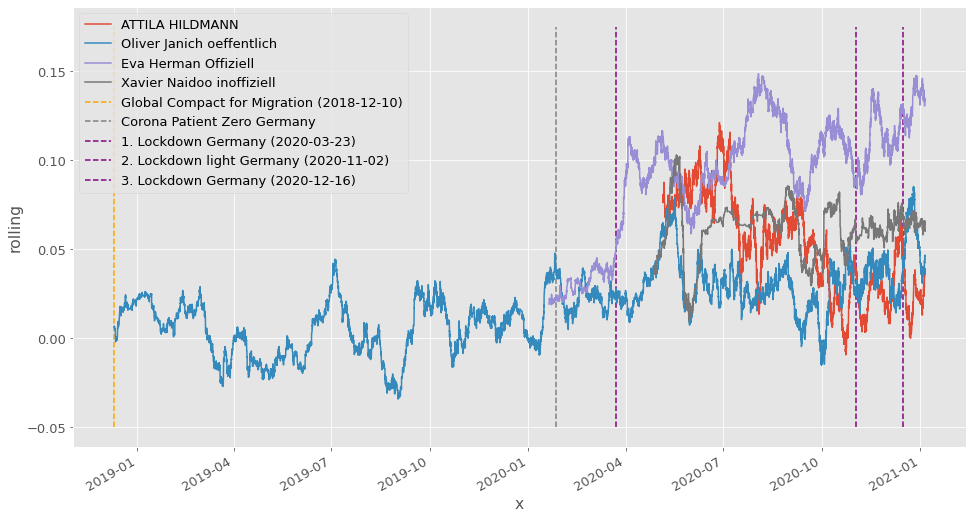

In [139]:
evalSenPipeline("sentiment", "dataSet0", outputFilename = "eval-pipeline-sen-textblob-dataSet0.svg", configRolling = 600, configShowScatter = False)

Subjectivity

[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<<]
[Stopwatch stopped >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<< (2.423s)]
[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-janich<<<<]
[Stopwatch stopped >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-janich<<<< (3.192s)]
[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<<<]
[Stopwatch stopped >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<<< (3.985s)]
[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-xavier<<<<]
[Stopwatch stopped >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-xavier<<<< (0.960s)]


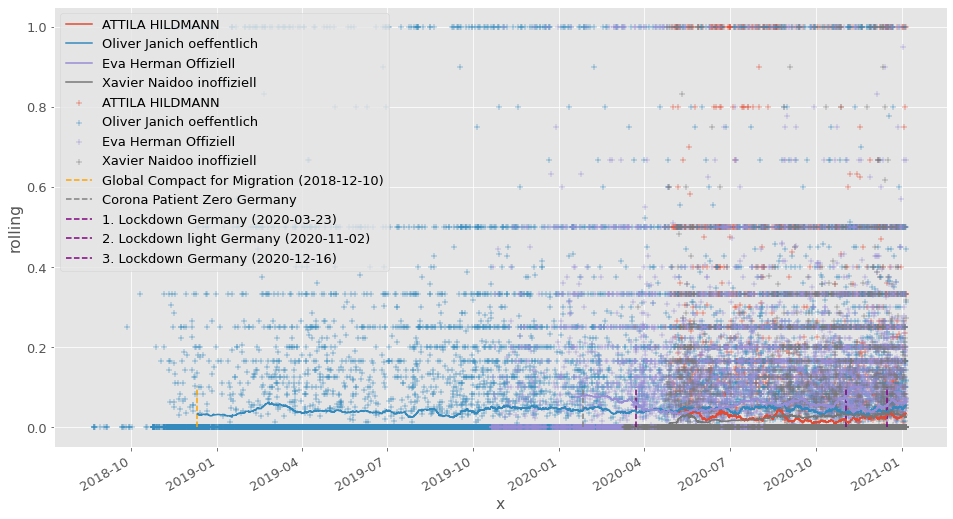

In [140]:
evalSenPipeline("subjectivity", "dataSet0", outputFilename = "", configRolling = 600, configShowScatter = True)

[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<<]
[Stopwatch stopped >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<< (2.438s)]
[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-janich<<<<]
[Stopwatch stopped >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-janich<<<< (3.115s)]
[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<<<]
[Stopwatch stopped >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<<< (1.522s)]
[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-xavier<<<<]
[Stopwatch stopped >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-xavier<<<< (0.900s)]


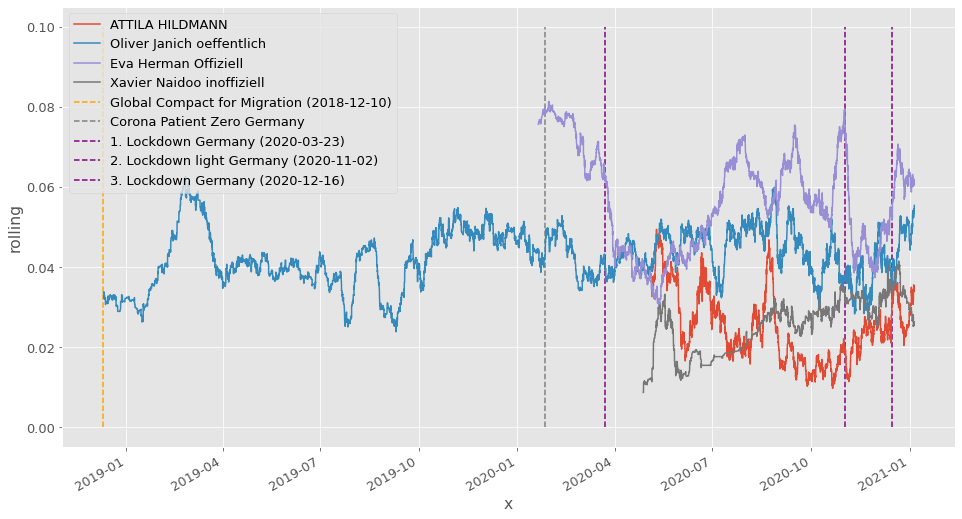

In [141]:
evalSenPipeline("subjectivity", "dataSet0", outputFilename = "eval-pipeline-subjectivity-dataSet0.svg", configRolling = 600, configShowScatter = False)

#### Transformers

##### Beispiele

In [142]:
processSenPipeline("Das ist toll. Ich würde es mir wieder kaufen!", "sen-bert", 0)

-1

In [143]:
processSenPipeline("Das ist toll. Ich würde es aber nicht mehr kaufen!", "sen-bert", 0)

-1

In [144]:
processSenPipeline("Das funktioniert nicht.", "sen-bert", 0)

-1

##### DataSet0

[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<<]
[Stopwatch stopped >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<< (2.434s)]
[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-janich<<<<]
[Stopwatch stopped >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-janich<<<< (3.145s)]
[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<<<]
[Stopwatch stopped >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<<< (1.523s)]
[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-xavier<<<<]
[Stopwatch stopped >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-xavier<<<< (0.957s)]


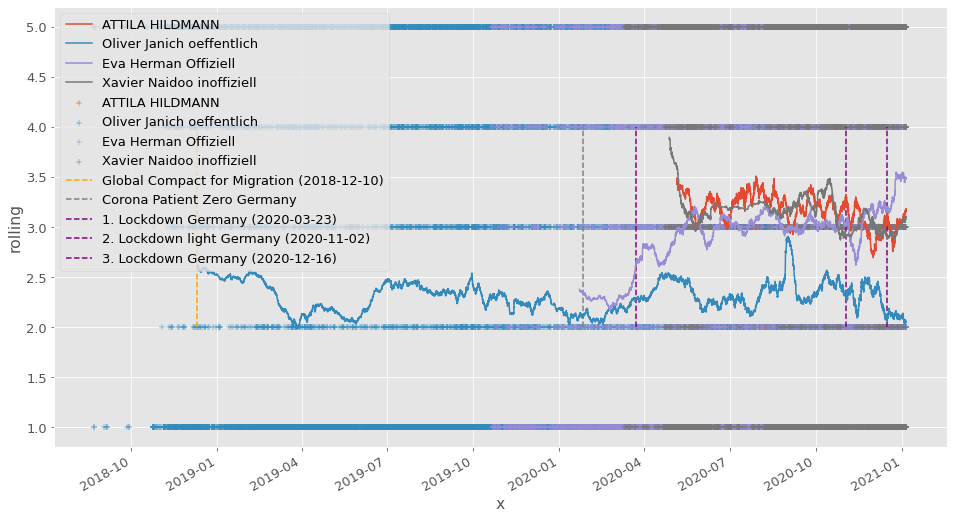

In [145]:
evalSenPipeline("sen-bert", "dataSet0", outputFilename = "", configRolling = 600, configShowScatter = True)

[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<<]
[Stopwatch stopped >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<< (2.392s)]
[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-janich<<<<]
[Stopwatch stopped >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-janich<<<< (3.134s)]
[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<<<]
[Stopwatch stopped >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<<< (1.479s)]
[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-xavier<<<<]
[Stopwatch stopped >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-xavier<<<< (0.950s)]


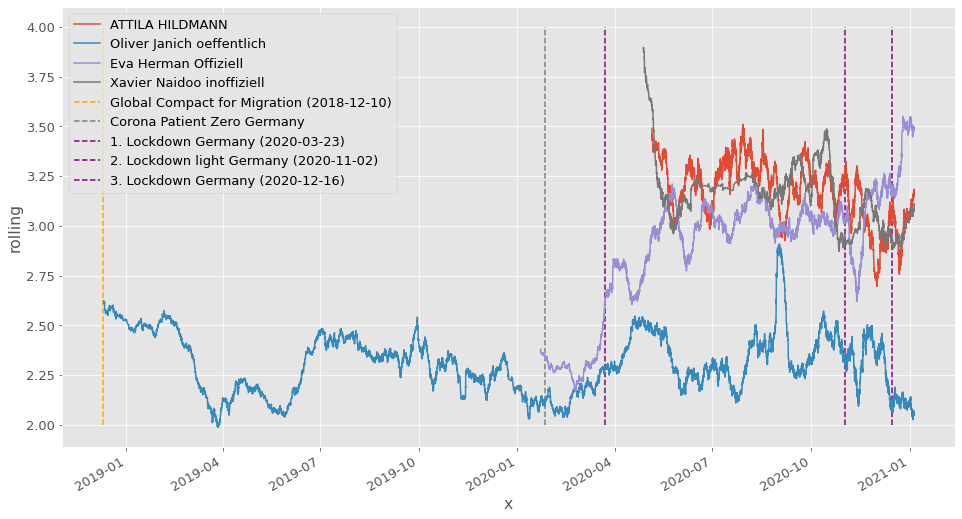

In [146]:
evalSenPipeline("sen-bert", "dataSet0", outputFilename = "eval-pipeline-sen-dataSet0.svg", configRolling = 600, configShowScatter = False)

### Latent Dirichlet Allocation (LDA)

Inspiriert von: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

Beispiel Topic Models Implementierungen in Python: https://nlpforhackers.io/topic-modeling/

- LDA (Probabilistic Graphical Models)
- LSA or LSI (Linear Algebra Singular Value Decomposition)
- NMF (Linear Algebra Non-Negative Matrix Factorization)

#### Beispiele

##### LDA Aufbereitung - Text

In [147]:
sampleList = ["Studenten sind faul", "und Studenten essen gerne Eis"]
sampleList

['Studenten sind faul', 'und Studenten essen gerne Eis']

In [148]:
def gensimPreprocess(sentences):
    for sentence in sentences:
        # deacc= removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
sampleList = list(gensimPreprocess(sampleList))
sampleList

[['studenten', 'sind', 'faul'], ['und', 'studenten', 'essen', 'gerne', 'eis']]

In [149]:
def gensimRemoveStopwords(inputList, stop_words):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in inputList]

sampleList = gensimRemoveStopwords(inputList = sampleList, stop_words=gloGetStopWordsList(filterList = []))
sampleList

[['studenten', 'faul'], ['studenten', 'essen', 'gerne', 'eis']]

##### LDA Aufbereitung - Dictionary

In [150]:
def ldaGetDictionary(inputList):
    return corpora.Dictionary(inputList)

sampleDictonary = ldaGetDictionary(sampleList)

In [151]:
sampleDictonary.num_docs

2

In [152]:
sampleDictonary.num_pos

6

In [153]:
sampleDictonary.token2id

{'faul': 0, 'studenten': 1, 'eis': 2, 'essen': 3, 'gerne': 4}

##### LDA Aufbereitung - Bag-Of-Words (BOW)

In [154]:
def ldaGetBOW(dictonary, inputList):
    return [dictonary.doc2bow(text) for text in inputList]

ldaGetBOW(sampleDictonary, sampleList)

[[(0, 1), (1, 1)], [(1, 1), (2, 1), (3, 1), (4, 1)]]

#### Implementierung

Return

- ``lda_model``
- ``corpus``
- ``id2word``

In [155]:
def processLda(df, num_topics, debugPrint, stopWords):

    df = df.copy()

    df = df[df.ftQrIsValidText == True]

    df = df[["date", "ftTdSafeLowerText"]]

    df = df.set_index("date")
    df = df.sort_index()

    inputList = df.ftTdSafeLowerText.values.tolist()

    inputList = list(gensimPreprocess(inputList))
    inputList  = gensimRemoveStopwords(inputList, stopWords)

    dictionary = ldaGetDictionary(inputList)

    # Term Document Frequency (dict to bag of words)
    corpus = ldaGetBOW(dictionary, inputList)

    # Build LDA model
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics)

    if(debugPrint):
        pprint(lda_model.print_topics())
        #doc_lda = lda_model[corpus] # TODO: ?

    return (lda_model, corpus, dictionary)

Lda zu Html

In [156]:
def ldaToHtml(lda_model, corpus, id2word, outputLabel):

    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

    pyLDAvis.save_html(LDAvis_prepared, dir_var_output + 'pyLDAvis/' + outputLabel + '-report.html')

Wrapper

In [157]:
# param outputLabel required
def autoLda(df, debugPrint, outputLabel, filterList, listNumberTopics):

    for iTopics in listNumberTopics:

        iLabel = outputLabel + "-t-" + str(iTopics)

        gloStartStopwatch("Process LDA (" + str(iTopics) + " topics) >> "+ iLabel + "<<")
               
        try:
            
            lda_model, corpus, id2word = processLda(
                    df = df,
                    num_topics = iTopics,
                    debugPrint = debugPrint,
                    stopWords = gloGetStopWordsList(filterList)
                )

            ldaToHtml(
                    lda_model = lda_model,
                    corpus = corpus,
                    id2word = id2word,
                    outputLabel = iLabel
                )

        except:
            print("Error in process lda")

        gloStopStopwatch("Process LDA (" + str(iTopics) + " topics) >> "+ iLabel + "<<")

##### LDA auf DataSet0

In [158]:
if(C_SHORT_RUN == False):
    autoLda(
        df = dictMessages["DS-05-01-2021/ChatExport_2021-01-05-janich"],
        debugPrint = False,
        outputLabel = "oliver-janich",
        filterList = [],
        listNumberTopics = [2,4,8,16]
    )

[Stopwatch started >>Process LDA (2 topics) >> oliver-janich-t-2<<<<]
[Stopwatch stopped >>Process LDA (2 topics) >> oliver-janich-t-2<<<< (27.482s)]
[Stopwatch started >>Process LDA (4 topics) >> oliver-janich-t-4<<<<]
[Stopwatch stopped >>Process LDA (4 topics) >> oliver-janich-t-4<<<< (23.310s)]
[Stopwatch started >>Process LDA (8 topics) >> oliver-janich-t-8<<<<]
[Stopwatch stopped >>Process LDA (8 topics) >> oliver-janich-t-8<<<< (22.540s)]
[Stopwatch started >>Process LDA (16 topics) >> oliver-janich-t-16<<<<]
[Stopwatch stopped >>Process LDA (16 topics) >> oliver-janich-t-16<<<< (23.494s)]


In [159]:
if(C_SHORT_RUN == False):
    autoLda(
        df = dictMessages["DS-05-01-2021/ChatExport_2021-01-05-hildmann"],
        debugPrint = False,
        outputLabel = "attila-hildmann",
        filterList = [],
        listNumberTopics = [2,4,8,16]
    )

[Stopwatch started >>Process LDA (2 topics) >> attila-hildmann-t-2<<<<]
[Stopwatch stopped >>Process LDA (2 topics) >> attila-hildmann-t-2<<<< (14.796s)]
[Stopwatch started >>Process LDA (4 topics) >> attila-hildmann-t-4<<<<]
[Stopwatch stopped >>Process LDA (4 topics) >> attila-hildmann-t-4<<<< (13.689s)]
[Stopwatch started >>Process LDA (8 topics) >> attila-hildmann-t-8<<<<]
[Stopwatch stopped >>Process LDA (8 topics) >> attila-hildmann-t-8<<<< (12.526s)]
[Stopwatch started >>Process LDA (16 topics) >> attila-hildmann-t-16<<<<]
[Stopwatch stopped >>Process LDA (16 topics) >> attila-hildmann-t-16<<<< (13.149s)]


In [160]:
if(C_SHORT_RUN == False):
    autoLda(
        df = dictMessages["DS-05-01-2021/ChatExport_2021-01-05-evaherman"],
        debugPrint = False,
        outputLabel = "eva-herman",
        filterList = [],
        listNumberTopics = [2,4,8,16]
    )

[Stopwatch started >>Process LDA (2 topics) >> eva-herman-t-2<<<<]
[Stopwatch stopped >>Process LDA (2 topics) >> eva-herman-t-2<<<< (15.069s)]
[Stopwatch started >>Process LDA (4 topics) >> eva-herman-t-4<<<<]
[Stopwatch stopped >>Process LDA (4 topics) >> eva-herman-t-4<<<< (14.597s)]
[Stopwatch started >>Process LDA (8 topics) >> eva-herman-t-8<<<<]
[Stopwatch stopped >>Process LDA (8 topics) >> eva-herman-t-8<<<< (14.234s)]
[Stopwatch started >>Process LDA (16 topics) >> eva-herman-t-16<<<<]
[Stopwatch stopped >>Process LDA (16 topics) >> eva-herman-t-16<<<< (15.193s)]


In [161]:
if(C_SHORT_RUN == False):
    autoLda(
        df = dictMessages["DS-05-01-2021/ChatExport_2021-01-05-xavier"],
        debugPrint = False,
        outputLabel = "xavier-naidoo",
        filterList = [],
        listNumberTopics = [2,4,8,16]
    )

[Stopwatch started >>Process LDA (2 topics) >> xavier-naidoo-t-2<<<<]
[Stopwatch stopped >>Process LDA (2 topics) >> xavier-naidoo-t-2<<<< (7.319s)]
[Stopwatch started >>Process LDA (4 topics) >> xavier-naidoo-t-4<<<<]
[Stopwatch stopped >>Process LDA (4 topics) >> xavier-naidoo-t-4<<<< (6.603s)]
[Stopwatch started >>Process LDA (8 topics) >> xavier-naidoo-t-8<<<<]
[Stopwatch stopped >>Process LDA (8 topics) >> xavier-naidoo-t-8<<<< (6.555s)]
[Stopwatch started >>Process LDA (16 topics) >> xavier-naidoo-t-16<<<<]
[Stopwatch stopped >>Process LDA (16 topics) >> xavier-naidoo-t-16<<<< (6.913s)]


##### LDA auf DataSet1a

In [162]:
if(C_SHORT_RUN == False):
    if("dataSet1a" in C_LOAD_DATASETS):
        autoLda(
            df = dictMessages["DS-05-01-2021a/ChatExport_2021-01-05-freiheitsChat"],
            debugPrint = False,
            outputLabel = "group-freiheitsChat",
            filterList = [],
            listNumberTopics = [2,4,8,16,32]
        )

[Stopwatch started >>Process LDA (2 topics) >> group-freiheitsChat-t-2<<<<]
[Stopwatch stopped >>Process LDA (2 topics) >> group-freiheitsChat-t-2<<<< (130.749s)]
[Stopwatch started >>Process LDA (4 topics) >> group-freiheitsChat-t-4<<<<]
[Stopwatch stopped >>Process LDA (4 topics) >> group-freiheitsChat-t-4<<<< (123.929s)]
[Stopwatch started >>Process LDA (8 topics) >> group-freiheitsChat-t-8<<<<]
[Stopwatch stopped >>Process LDA (8 topics) >> group-freiheitsChat-t-8<<<< (119.263s)]
[Stopwatch started >>Process LDA (16 topics) >> group-freiheitsChat-t-16<<<<]
[Stopwatch stopped >>Process LDA (16 topics) >> group-freiheitsChat-t-16<<<< (117.575s)]
[Stopwatch started >>Process LDA (32 topics) >> group-freiheitsChat-t-32<<<<]
[Stopwatch stopped >>Process LDA (32 topics) >> group-freiheitsChat-t-32<<<< (130.518s)]


In [163]:
if(C_SHORT_RUN == False):
    if("dataSet1a" in C_LOAD_DATASETS):
        autoLda(
            df = dictMessages["DS-05-01-2021a/ChatExport_2021-01-05-freiheitsChatBlitz"],
            debugPrint = False,
            outputLabel = "group-freiheitsChatBlitz",
            filterList = [],
            listNumberTopics = [2,4,8,16,32]
        )

[Stopwatch started >>Process LDA (2 topics) >> group-freiheitsChatBlitz-t-2<<<<]
[Stopwatch stopped >>Process LDA (2 topics) >> group-freiheitsChatBlitz-t-2<<<< (52.876s)]
[Stopwatch started >>Process LDA (4 topics) >> group-freiheitsChatBlitz-t-4<<<<]
[Stopwatch stopped >>Process LDA (4 topics) >> group-freiheitsChatBlitz-t-4<<<< (47.261s)]
[Stopwatch started >>Process LDA (8 topics) >> group-freiheitsChatBlitz-t-8<<<<]
[Stopwatch stopped >>Process LDA (8 topics) >> group-freiheitsChatBlitz-t-8<<<< (47.252s)]
[Stopwatch started >>Process LDA (16 topics) >> group-freiheitsChatBlitz-t-16<<<<]
[Stopwatch stopped >>Process LDA (16 topics) >> group-freiheitsChatBlitz-t-16<<<< (53.590s)]
[Stopwatch started >>Process LDA (32 topics) >> group-freiheitsChatBlitz-t-32<<<<]
[Stopwatch stopped >>Process LDA (32 topics) >> group-freiheitsChatBlitz-t-32<<<< (46.099s)]


In [164]:
if(C_SHORT_RUN == False):
    if("dataSet1a" in C_LOAD_DATASETS):
        autoLda(
            df = dictMessages["DS-05-01-2021a/ChatExport_2021-01-05-liveFuerDeOsSc"],
            debugPrint = False,
            outputLabel = "group-liveFuerDeOsSc",
            filterList = [],
            listNumberTopics = [2,4,8,16,32]
        )

[Stopwatch started >>Process LDA (2 topics) >> group-liveFuerDeOsSc-t-2<<<<]
[Stopwatch stopped >>Process LDA (2 topics) >> group-liveFuerDeOsSc-t-2<<<< (3.356s)]
[Stopwatch started >>Process LDA (4 topics) >> group-liveFuerDeOsSc-t-4<<<<]
[Stopwatch stopped >>Process LDA (4 topics) >> group-liveFuerDeOsSc-t-4<<<< (2.932s)]
[Stopwatch started >>Process LDA (8 topics) >> group-liveFuerDeOsSc-t-8<<<<]
[Stopwatch stopped >>Process LDA (8 topics) >> group-liveFuerDeOsSc-t-8<<<< (2.934s)]
[Stopwatch started >>Process LDA (16 topics) >> group-liveFuerDeOsSc-t-16<<<<]
[Stopwatch stopped >>Process LDA (16 topics) >> group-liveFuerDeOsSc-t-16<<<< (3.263s)]
[Stopwatch started >>Process LDA (32 topics) >> group-liveFuerDeOsSc-t-32<<<<]
[Stopwatch stopped >>Process LDA (32 topics) >> group-liveFuerDeOsSc-t-32<<<< (3.249s)]


### Ausblick Textgenerierung

Globale Stopuhr beenden

In [165]:
gloStopStopwatch("Global notebook")

[Stopwatch stopped >>Global notebook<< (3705.709s)]


Bsp Text

In [166]:
sampleText = "Hallo, mein Name ist Max und ich esse gerne Eis. Ich schreibe gerade an meiner Masterarbeit und teste neue Verfahren. Ich komme aus dem Großraum München und bin Informatiker."
sampleText

'Hallo, mein Name ist Max und ich esse gerne Eis. Ich schreibe gerade an meiner Masterarbeit und teste neue Verfahren. Ich komme aus dem Großraum München und bin Informatiker.'

In [167]:
def processTextGenPipeline(inputText, pipelineKey, cMaxLength):
    if(pipelineKey in pipelineKeys):
        return dictPipelines[pipelineKey](inputText, max_length=cMaxLength)

##### gpt2

In [168]:
processTextGenPipeline(sampleText, "text-gen-gpt2", cMaxLength = 100)

##### gpt2-faust

In [169]:
processTextGenPipeline(sampleText, "text-gen-gpt2-faust", cMaxLength = 100)

## Mehr lesen / Inspirationen

- https://towardsai.net/p/data-mining/text-mining-in-python-steps-and-examples-78b3f8fd913b
- https://towardsdatascience.com/text-mining-for-dummies-text-classification-with-python-98e47c3a9deb
- https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/
- https://realpython.com/python-keras-text-classification/
- https://www.tidytextmining.com/ngrams.html
- http://seaborn.pydata.org/tutorial/categorical.html?highlight=bar%20plot
- https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166
- https://www.kirenz.com/post/2019-08-13-network_analysis/
- https://tgstat.com
- https://huggingface.co/bert-base-german-cased
- https://github.com/sekhansen/text-mining-tutorial/tree/master
- https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
- https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
- https://github.com/sekhansen/text-mining-tutorial/blob/master/tutorial_notebook.ipynb
- https://textmining.wp.hs-hannover.de/Preprocessing.html
- https://likegeeks.com/nlp-tutorial-using-python-nltk/
- https://www.datacamp.com/community/tutorials/text-analytics-beginners-nltk
- https://data-flair.training/blogs/nltk-python-tutorial/
- https://github.com/expectocode/telegram-analysis
- https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
- https://stackoverflow.com/questions/6718633/python-regular-expression-again-match-url